<a href="https://colab.research.google.com/github/naive1899/Base/blob/main/sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Базовый SQL

1 - select * from SALES_ORDER

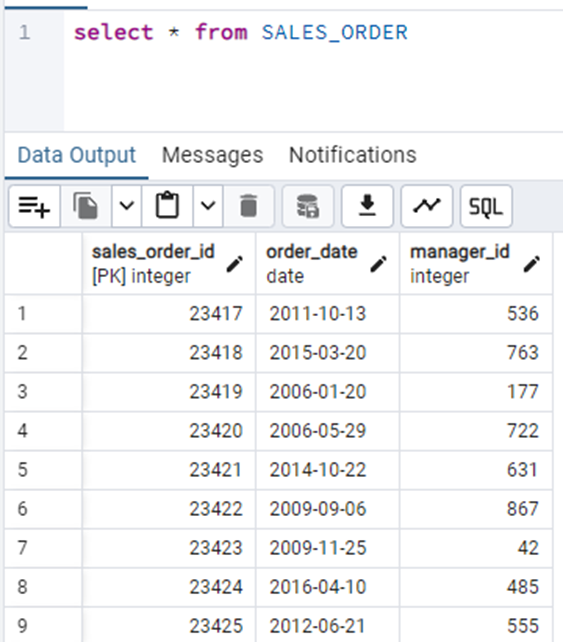

2 – select * from SALES_ORDER where order_date > date'2016-01-01'

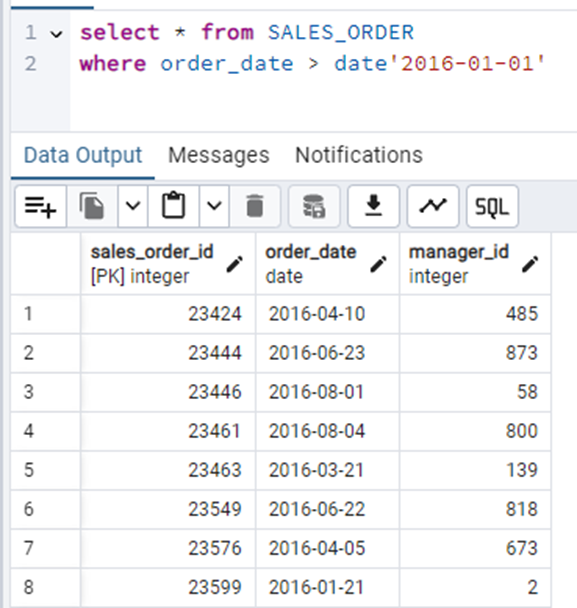

3 –  select * from SALES_ORDER
where order_date > date'2016-01-01' and order_date < date'2016-07-15'


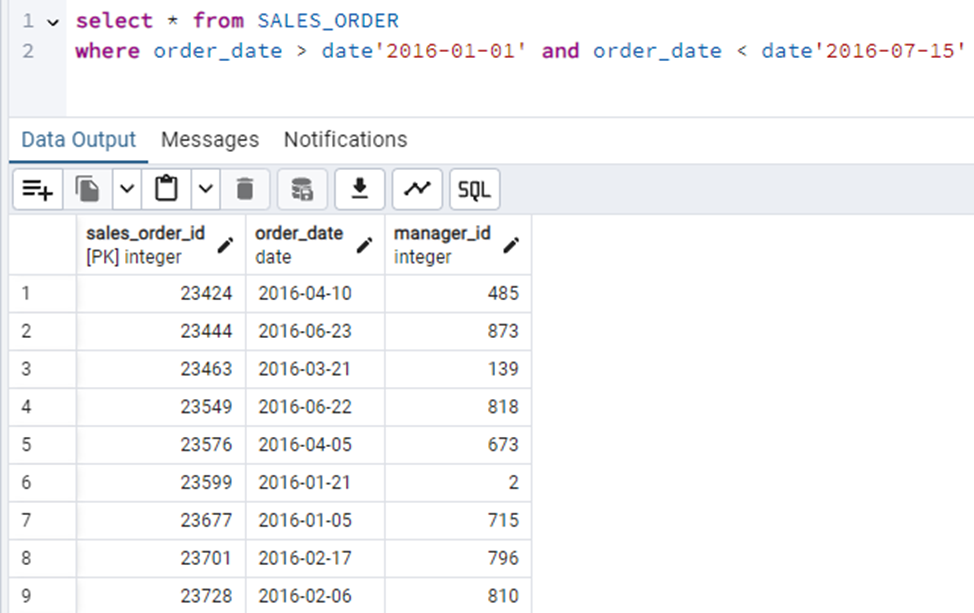

4 – Найти менеджеров с именем 'Henry'
SELECT * FROM MANAGER
WHERE MANAGER_FIRST_NAME = 'Henry'


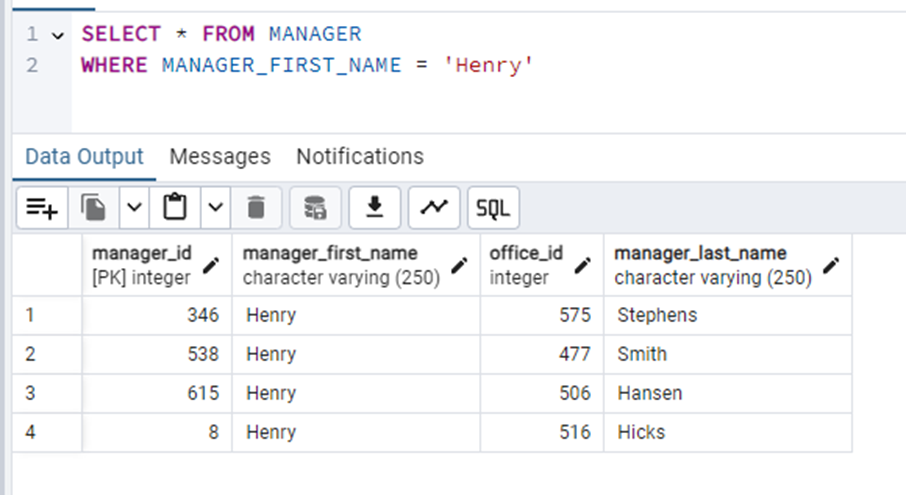

5 – Выбрать все заказы менеджеров с именем Henry

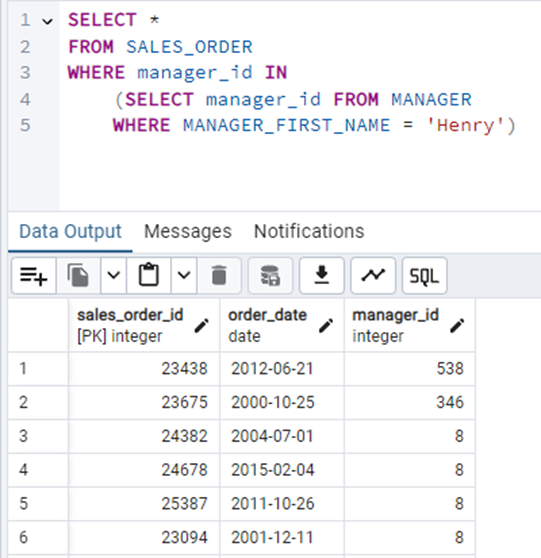

6 – Выбрать все уникальные страны из таблицы CITY

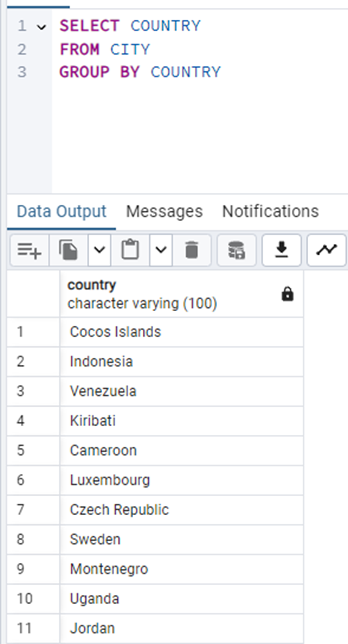

7 – Выбрать все уникальные комбинации страны и региона из таблицы CITY

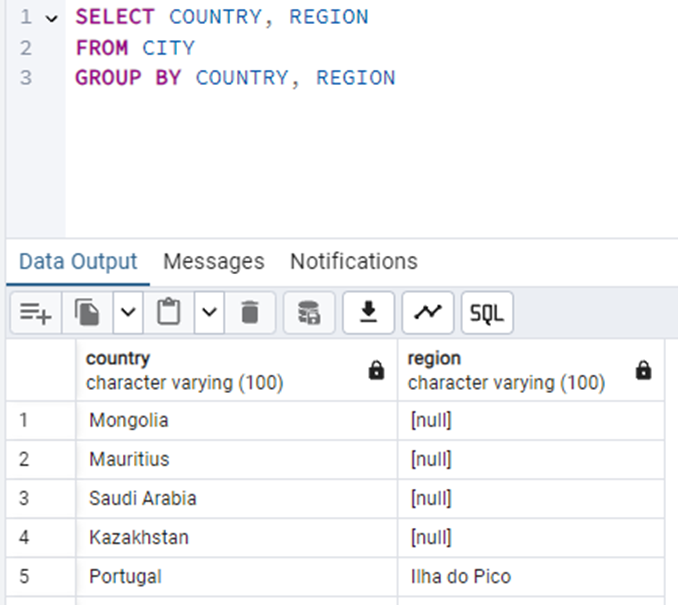

8 Выбрать все страны из таблицы CITY с количеством городов в них.

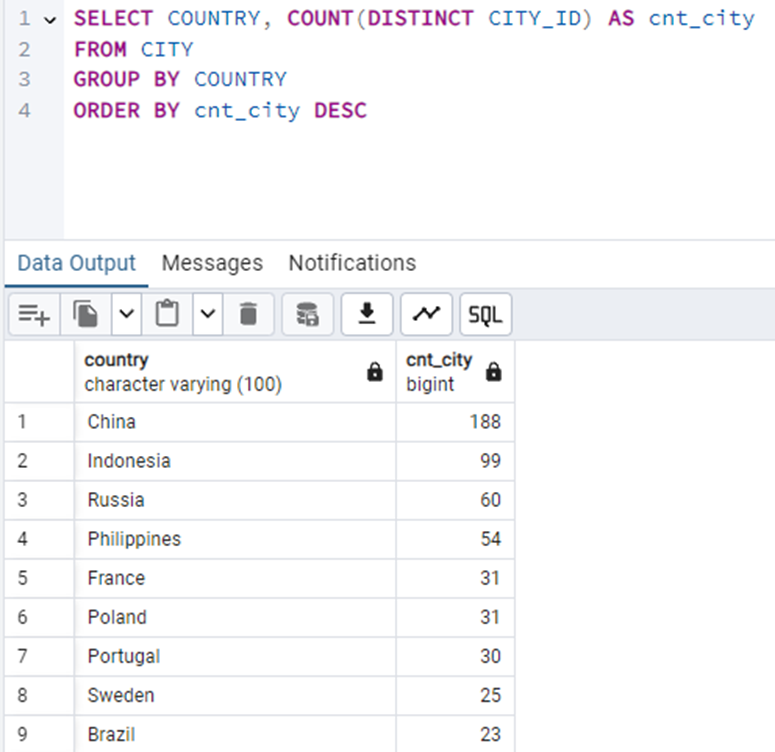

9 Выбрать количество товаров (QTY), проданное с 1 по 30 января 2016 года

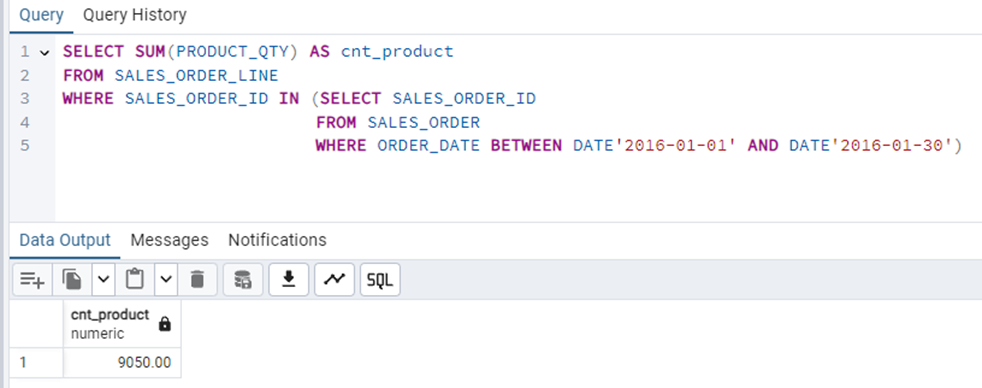

10 Выбрать все уникальные названия городов, регионов и стран в одной колонке одним запросом

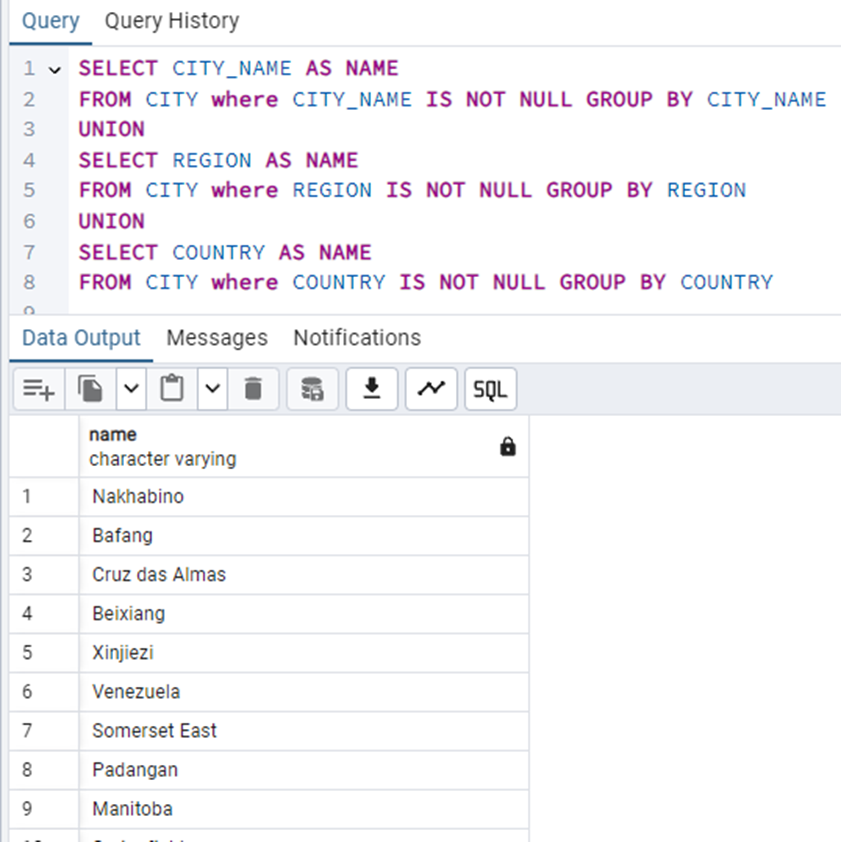

11 Вывести имена и фамилии менеджер(ов), продавшего товаров в январе 2016 года на наибольшую сумму.



```sql
WITH cur_mng AS (
-- Находим менеджеров, кто продовал в январе 16 года
SELECT *
FROM SALES_ORDER
WHERE date_trunc ('MONTH', ORDER_DATE) = DATE'2016-01-01'),
-- Выбирает все записи, где ORDER_DATE попадает в январь 2016 года.

-- Составим лидерборд по продажам
top_sales AS (
select  MANAGER_FIRST_NAME,
		MANAGER_LAST_NAME,
		SUM(PRODUCT_PRICE * PRODUCT_QTY) as total_price
FROM cur_mng
JOIN SALES_ORDER_LINE sol ON cur_mng.SALES_ORDER_ID = sol.SALES_ORDER_ID
JOIN MANAGER m ON m.MANAGER_ID = cur_mng.MANAGER_ID
GROUP BY MANAGER_FIRST_NAME, MANAGER_LAST_NAME
)

SELECT	MANAGER_FIRST_NAME,
		MANAGER_LAST_NAME,
		total_price
FROM top_sales
WHERE total_price = (SELECT MAX(total_price) FROM top_sales)

```

Аналогично

```sql
WITH manager_sales AS (
    SELECT
        m.MANAGER_FIRST_NAME,
        m.MANAGER_LAST_NAME,
        SUM(sol.PRODUCT_PRICE * sol.PRODUCT_QTY) as total_price,
        RANK() OVER (ORDER BY SUM(sol.PRODUCT_PRICE * sol.PRODUCT_QTY) DESC) as sales_rank
    FROM SALES_ORDER so
    JOIN SALES_ORDER_LINE sol ON so.SALES_ORDER_ID = sol.SALES_ORDER_ID
    JOIN MANAGER m ON m.MANAGER_ID = so.MANAGER_ID
    WHERE date_trunc('MONTH', so.ORDER_DATE) = DATE '2016-01-01'
    GROUP BY m.MANAGER_FIRST_NAME, m.MANAGER_LAST_NAME
)
SELECT MANAGER_FIRST_NAME, MANAGER_LAST_NAME, total_price
FROM manager_sales
WHERE sales_rank = 1;
```


еще
```sql
SELECT
    m.MANAGER_FIRST_NAME,
    m.MANAGER_LAST_NAME,
    SUM(sol.PRODUCT_PRICE * sol.PRODUCT_QTY) as total_price
FROM SALES_ORDER so
JOIN SALES_ORDER_LINE sol ON so.SALES_ORDER_ID = sol.SALES_ORDER_ID
JOIN MANAGER m ON m.MANAGER_ID = so.MANAGER_ID
WHERE so.ORDER_DATE >= '2016-01-01'
  AND so.ORDER_DATE < '2016-02-01'
GROUP BY m.MANAGER_FIRST_NAME, m.MANAGER_LAST_NAME
ORDER BY total_price DESC
LIMIT 1;
```

еще


```sql
select m.manager_id, manager_first_name, manager_last_name, sum(sol.product_qty * sol.product_price) sum_amount
from sales_order so
inner join sales_order_line sol on sol.sales_order_id = so.sales_order_id
inner join manager m on m.manager_id = so.manager_id
where so.order_date between to_date('01-01-2016', 'DD-MM-YYYY') and to_date('31-01-2016', 'DD-MM-YYYY')
group by m.manager_id
order by sum_amount desc
limit 1
```



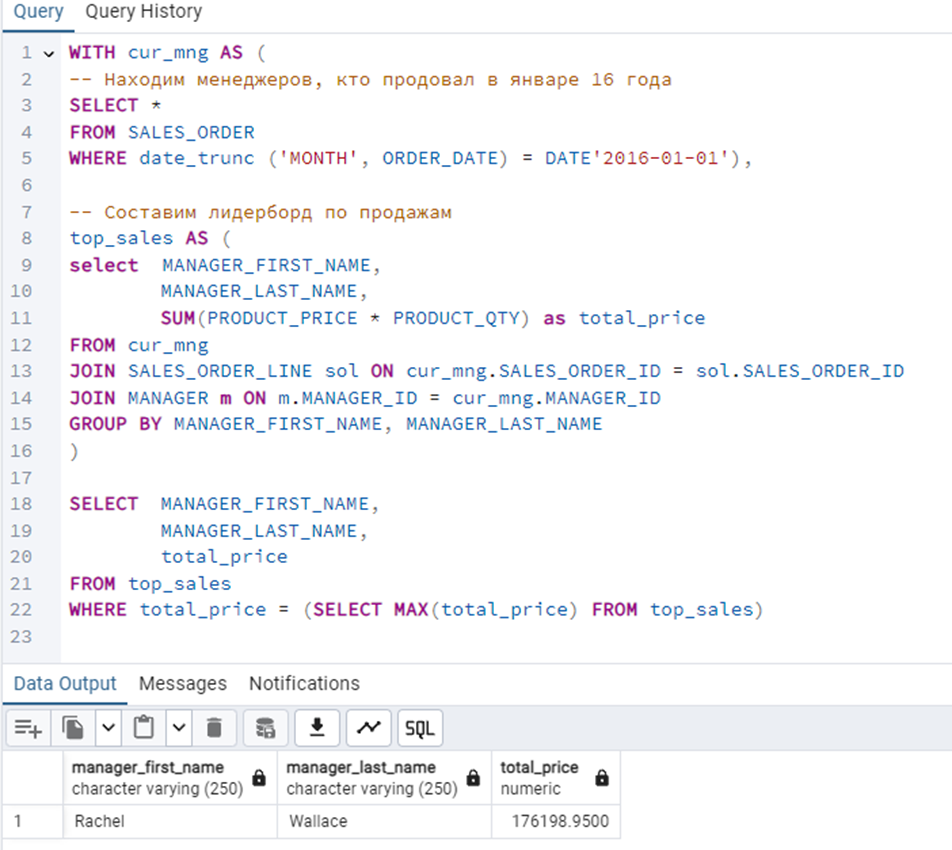

# Аналитический SQL

1. Каждый месяц компания выдает премию в размере 5% от суммы продаж менеджеру, который за предыдущие 3 месяца продал товаров на самую большую сумму
Выведите месяц, manager_id, manager_first_name, manager_last_name, премию за период с января по декабрь 2014 года



```sql
with all_managers as (
	select distinct manager_id, manager_first_name, manager_last_name from v_fact_sale
		where manager_id is not null and sale_date >= TO_DATE('01.10.2013', 'DD.MM.YYYY')
    and sale_date < TO_DATE('01.01.2015', 'DD.MM.YYYY')
),
all_months(sale_month) as (
	select generate_series(
        date_trunc('month', TO_DATE('01.10.2013', 'DD.MM.YYYY')),
        TO_DATE('01.12.2014', 'DD.MM.YYYY'), '1 month')::date as month
),
all_manager_months as (
 select manager_id, manager_first_name, manager_last_name, sale_month from all_managers cross join all_months
),
step1 as (
  select date_trunc('month', sale_date) sale_month, manager_id, manager_first_name, manager_last_name,
  sum(sale_amount) sale_amount
	from v_fact_sale
	where sale_date >= TO_DATE('01.10.2013', 'DD.MM.YYYY') and sale_date < TO_DATE('01.01.2015', 'DD.MM.YYYY')
	group by manager_id, manager_first_name, manager_last_name, date_trunc('month', sale_date)
	order by sale_month
),
step2 as (
	select m.sale_month, m.manager_id, m.manager_first_name, m.manager_last_name, coalesce(s.sale_amount, 0) sale_amount,
		sum(coalesce(s.sale_amount, 0)) OVER (PARTITION BY m.manager_id ORDER BY m.sale_month
    RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH PRECEDING) prev_sale_amount
	from step1 s right outer join all_manager_months m on (m.manager_id = s.manager_id and m.sale_month = s.sale_month)
),
step3 as (
	select sale_month, manager_id, manager_first_name, manager_last_name, sale_amount, prev_sale_amount,
		RANK() OVER (partition by sale_month ORDER BY prev_sale_amount desc)  manager_rank
	from step2
	where prev_sale_amount is not null
)
select sale_month, manager_id, manager_first_name, manager_last_name, prev_sale_amount * 0.05 premium from step3
where manager_rank = 1 and sale_month >= TO_DATE('01.01.2014', 'DD.MM.YYYY');

```



Улучшенный запрос

```sql
WITH all_months AS (
    SELECT
        generate_series(
            DATE '2013-10-01',
            DATE '2014-12-01',
            '1 month'
        )::date AS sale_month
),
manager_sales AS (
    SELECT
        DATE_TRUNC('month', sale_date) AS sale_month,
        manager_id,
        manager_first_name,
        manager_last_name,
        SUM(sale_amount) AS monthly_sales
    FROM v_fact_sale
    WHERE sale_date >= DATE '2013-10-01'
        AND sale_date < DATE '2015-01-01'
        AND manager_id IS NOT NULL
    GROUP BY 1, 2, 3, 4
),
three_month_totals AS (
    SELECT
        am.sale_month,
        m.manager_id,
        m.manager_first_name,
        m.manager_last_name,
        SUM(prev.monthly_sales) AS prev_three_month_sales
    FROM all_months am
    CROSS JOIN (
        SELECT DISTINCT manager_id, manager_first_name, manager_last_name
        FROM manager_sales
    ) m
    LEFT JOIN manager_sales prev
        ON prev.sale_month BETWEEN am.sale_month - INTERVAL '3 months'
                              AND am.sale_month - INTERVAL '1 month'
        AND prev.manager_id = m.manager_id
    WHERE am.sale_month >= DATE '2014-01-01'
    GROUP BY am.sale_month, m.manager_id, m.manager_first_name, m.manager_last_name
),
ranked_managers AS (
    SELECT *,
    RANK() OVER (PARTITION BY sale_month
    ORDER BY prev_three_month_sales DESC NULLS LAST
        ) AS manager_rank
    FROM three_month_totals
)
SELECT
    sale_month,
    manager_id,
    manager_first_name,
    manager_last_name,
    prev_three_month_sales * 0.05 AS premium
FROM ranked_managers
WHERE manager_rank = 1
ORDER BY sale_month;
```



Еще

```sql
WITH all_months AS (
    SELECT generate_series(DATE '2013-10-01', DATE '2014-12-01', '1 month')::date AS sale_month
),
all_managers AS (
    SELECT DISTINCT manager_id, manager_first_name, manager_last_name
    FROM V_FACT_SALE
    WHERE manager_id IS NOT NULL
),
monthly_sales AS (
    SELECT
        DATE_TRUNC('month', sale_date) AS sale_month,
        manager_id,
        manager_first_name,
        manager_last_name,
        SUM(sale_amount) AS total_sales
    FROM V_FACT_SALE
    WHERE sale_date BETWEEN '2013-10-01' AND '2014-12-31'
    GROUP BY 1, 2, 3, 4
),
manager_months AS (
    SELECT
        am.sale_month,
        m.manager_id,
        m.manager_first_name,
        m.manager_last_name
    FROM all_months am
    CROSS JOIN all_managers m
),
cumulative_sales AS (
    SELECT
        mm.sale_month,
        mm.manager_id,
        mm.manager_first_name,
        mm.manager_last_name,
        SUM(ms.total_sales) AS three_month_total
    FROM manager_months mm
    LEFT JOIN monthly_sales ms
        ON ms.sale_month BETWEEN mm.sale_month - INTERVAL '3 months'
                            AND mm.sale_month - INTERVAL '1 month'
        AND ms.manager_id = mm.manager_id
    WHERE mm.sale_month >= DATE '2014-01-01'
    GROUP BY 1, 2, 3, 4
),
ranked_managers AS (
    SELECT
        sale_month,
        manager_id,
        manager_first_name,
        manager_last_name,
        three_month_total,
        RANK() OVER (
            PARTITION BY sale_month
            ORDER BY three_month_total DESC NULLS LAST
        ) AS rank
    FROM cumulative_sales
)
SELECT
    TO_CHAR(MAKE_DATE(2014, EXTRACT(MONTH FROM sale_month)::int, 1), 'Month') AS month_name,
    -- равно выражению TO_CHAR(sale_month, 'Month')
    manager_id,
    manager_first_name,
    manager_last_name,
    three_month_total * 0.05 AS bonus
FROM ranked_managers
WHERE rank = 1
ORDER BY sale_month;
```



Возможные проблемы:

1.  Если два менеджера имеют точно одинаковые суммы продаж за 3 месяца, RANK() присвоит им обоим ранг 1.

Решение зависит от бизнес-правил:

- Если премия может выдаваться нескольким менеджерам: оставить как есть
- Если премия выдается только одному менеджеру: заменить на ROW_NUMBER()
```sql
ROW_NUMBER() OVER (
    PARTITION BY sale_month
    ORDER BY three_month_total DESC NULLS LAST,
             manager_id ASC  -- Добавляем вторичную сортировку
) AS rank
```

2.  При одинаковых значениях three_month_total порядок менеджеров недетерминирован.

Решение: добавить вторичную сортировку:
```sql
RANK() OVER (
    PARTITION BY sale_month
    ORDER BY three_month_total DESC NULLS LAST,
             manager_id ASC  -- Или другой уникальный идентификатор
) AS rank
```



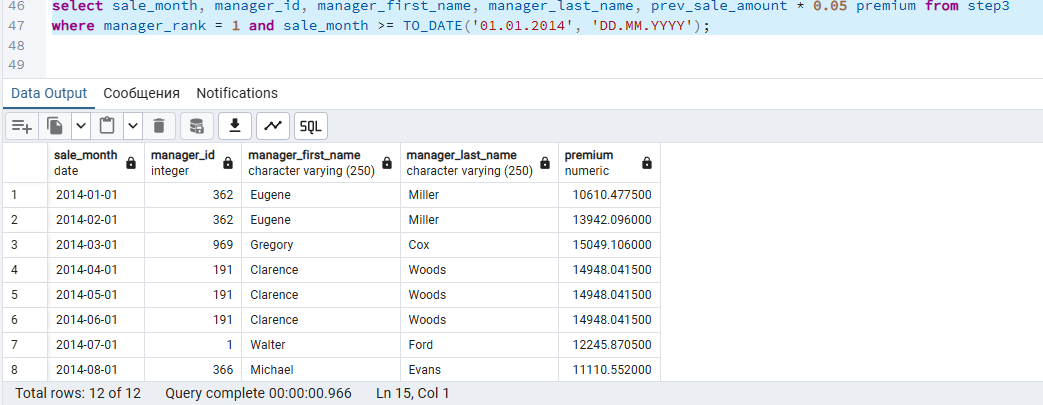

2. Компания хочет оптимизировать количество офисов, проанализировав относительные объемы продаж по офисам в течение периода с 2013-2014 гг.
Выведите год, office_id, city_name, country, относительный объем продаж за текущий год
Офисы, которые демонстрируют наименьший относительной объем в течение двух лет скорее всего будут закрыты.




```sql
WITH sales_data AS (
    SELECT
        office_id,
        city_name,
        country,
        SUM(sale_amount) AS total_sales
    FROM
        v_fact_sale
    WHERE
        sale_date >= TO_DATE('01.01.2013', 'DD.MM.YYYY') and sale_date < TO_DATE('01.01.2015', 'DD.MM.YYYY')
    GROUP BY
         office_id, city_name, country
),
relative_sales AS (
    SELECT
        office_id,
        city_name,
        country,
        total_sales,
        total_sales * 100.0 / SUM(total_sales) OVER () AS relative_sales
    FROM
        sales_data
)
SELECT
    office_id,
    city_name,
    country,
    relative_sales
FROM
    relative_sales
ORDER BY
     relative_sales asc;

```



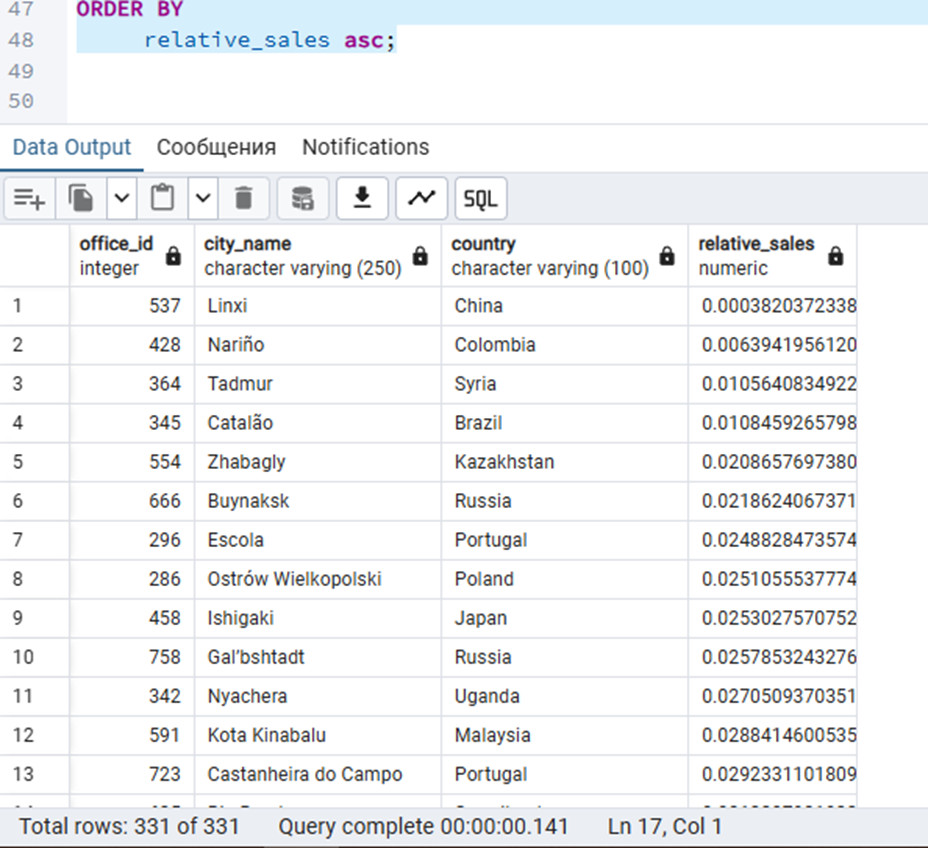


3. Для планирования закупок, компанию оценивает динамику роста продаж по товарам.
Динамика оценивается как отношение объема продаж в текущем месяце к предыдущему.
Выведите товары, которые демонстрировали наиболее высокие темпы роста продаж в течение первого полугодия 2014 года.




```sql
WITH monthly_sales AS (
    SELECT
        product_id,
        DATE_TRUNC('month', sale_date) AS month,
        SUM(sale_amount) AS total_sales
    FROM
        v_fact_sale
    WHERE
        DATE_TRUNC('month', sale_date) BETWEEN '2014-01-01' AND '2014-06-30'
    GROUP BY
        product_id,
        DATE_TRUNC('month', sale_date)
),
sales_growth AS (
    SELECT
        product_id,
        month,
        total_sales,
        LAG(total_sales) OVER (PARTITION BY product_id ORDER BY month) AS previous_sales
    FROM
        monthly_sales
)

SELECT
    product_id,
    month,
    total_sales,
    previous_sales,
    CASE
        WHEN previous_sales IS NOT NULL THEN (total_sales::float / previous_sales) - 1
        ELSE NULL
    END AS growth_rate
FROM
    sales_growth
WHERE
    previous_sales IS NOT NULL
ORDER BY
    growth_rate DESC
LIMIT 10;  -- Ограничиваем вывод 10-ю товарами с наибольшим темпом роста

```



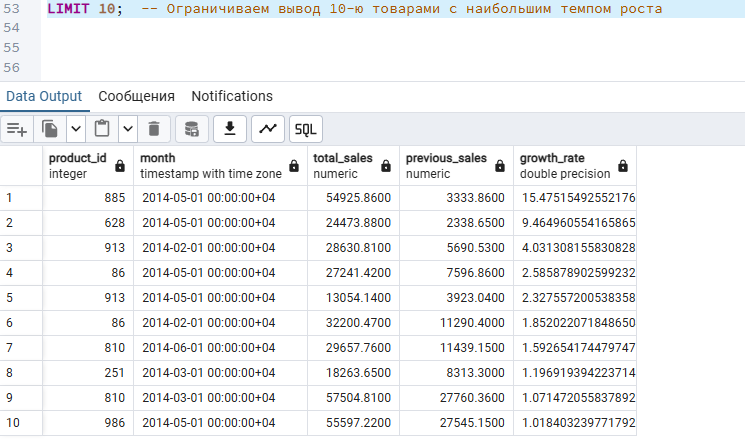

4. Напишите запрос, который выводит отчет о прибыли компании за 2014 год: помесячно и поквартально.
Отчет включает сумму прибыли за период и накопительную сумму прибыли с начала года по текущий период.



```sql
WITH quarterly_profit AS (
    SELECT
        DATE_TRUNC('quarter', sale_date) AS quarter,  -- Округляем дату до начала квартала
        SUM(sale_amount) AS quarterly_total             -- Суммируем прибыль за квартал
    FROM
        v_fact_sale
    WHERE
        sale_date BETWEEN '2014-01-01' AND '2014-12-31'  -- Ограничиваем период 2014 годом
    GROUP BY
        quarter
),
cumulative_quarterly_profit AS (
    SELECT
        quarter,
        quarterly_total,
        SUM(quarterly_total) OVER (ORDER BY quarter) AS cumulative_total  -- Накопительная сумма
    FROM
        quarterly_profit
)
SELECT
    quarter,
    quarterly_total,
    cumulative_total
FROM
    cumulative_quarterly_profit
ORDER BY
    quarter;

```



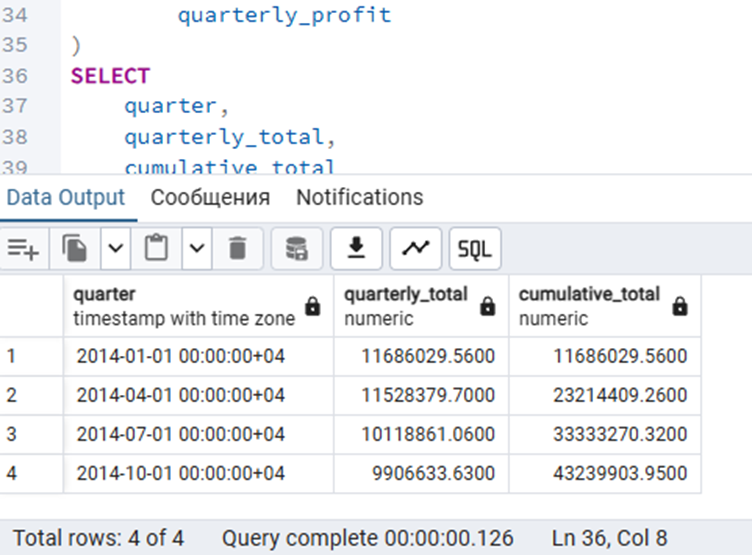

5. Найдите вклад в общую прибыль за 2014 год 10% наиболее дорогих товаров и 10% наиболее дешевых товаров.
Выведите product_id, product_name, total_sale_amount, percent



```sql
WITH total_profit AS (
    SELECT
        product_id,
        product_name,
        SUM(sale_amount) AS total_sale_amount
    FROM
        v_fact_sale
    WHERE
        DATE_TRUNC('year', sale_date) = '2014-01-01'  -- Ограничиваем на 2014 год
    GROUP BY
        product_id, product_name
),
ranked_products AS (
    SELECT
        product_id,
        product_name,
        total_sale_amount,
        NTILE(10) OVER (ORDER BY total_sale_amount DESC) AS price_rank_desc,
        NTILE(10) OVER (ORDER BY total_sale_amount ASC) AS price_rank_asc
    FROM
        total_profit
),
top_10_percent_products AS (
    SELECT
        product_id,
        product_name,
        total_sale_amount
    FROM
        ranked_products
    WHERE
        price_rank_desc = 1 OR price_rank_asc = 1
),
total_profit_year AS (
    SELECT
        SUM(total_sale_amount) AS total_sale_year
    FROM
        total_profit
)

SELECT
    p.product_id,
    p.product_name,
    p.total_sale_amount,
    (p.total_sale_amount::float / t.total_sale_year) * 100 AS percent
FROM
    top_10_percent_products p,
    total_profit_year t;


```



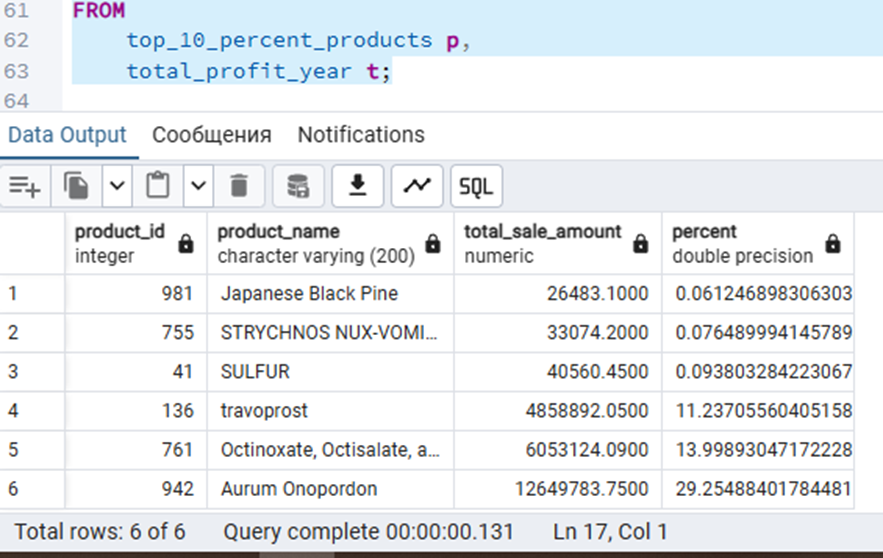


6. Компания хочет премировать трех наиболее продуктивных (по объему продаж, конечно) менеджеров в каждой стране в 2014 году.
Выведите country, <список manager_last_name manager_first_name, разделенный запятыми> которым будет выплачена премия



```sql
WITH total_sales_by_manager AS (
    SELECT
        manager_id,
        manager_first_name,
        manager_last_name,
        country,
        SUM(sale_amount) AS total_sales
    FROM
        v_fact_sale
    WHERE
        DATE_TRUNC('year', sale_date) = '2014-01-01'  -- Ограничиваем результаты 2014 годом
    GROUP BY
        manager_id, manager_first_name, manager_last_name, country
),
ranked_managers AS (
    SELECT
        country,
        manager_first_name,
        manager_last_name,
        total_sales,
        ROW_NUMBER() OVER (PARTITION BY country ORDER BY total_sales DESC) AS rank
    FROM
        total_sales_by_manager
)
SELECT
    country,
    STRING_AGG(manager_last_name || ' ' || manager_first_name, ', ' ORDER BY rank) AS top_managers
FROM
    ranked_managers
WHERE
    rank <= 3  -- Выбираем только трех самых продуктивных менеджеров
GROUP BY
    country
ORDER BY
    country;

```



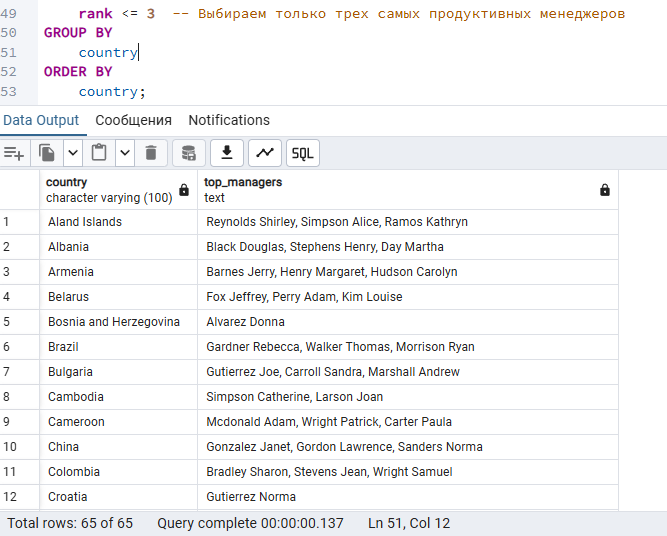

7. Выведите самый дешевый и самый дорогой товар, проданный за каждый месяц в течение 2014 года.
cheapest_product_id, cheapest_product_name, expensive_product_id, expensive_product_name, month, cheapest_price, expensive_price



```sql
WITH monthly_product_sales AS (
    SELECT
        product_id,
        product_name,
        sale_amount,
        DATE_TRUNC('month', sale_date) AS month
    FROM
        v_fact_sale
    WHERE
        DATE_TRUNC('year', sale_date) = '2014-01-01'  -- Ограничиваем результаты 2014 годом
),
ranked_products AS (
    SELECT
        product_id,
        product_name,
        sale_amount,
        month,
        ROW_NUMBER() OVER (PARTITION BY month ORDER BY sale_amount ASC) AS cheap_rank,
        ROW_NUMBER() OVER (PARTITION BY month ORDER BY sale_amount DESC) AS expensive_rank
    FROM
        monthly_product_sales
)
SELECT
    MIN(CASE WHEN cheap_rank = 1 THEN product_id END) AS cheapest_product_id,
    MIN(CASE WHEN cheap_rank = 1 THEN product_name END) AS cheapest_product_name,
    MIN(CASE WHEN expensive_rank = 1 THEN product_id END) AS expensive_product_id,
    MIN(CASE WHEN expensive_rank = 1 THEN product_name END) AS expensive_product_name,
    month,
    MIN(CASE WHEN cheap_rank = 1 THEN sale_amount END) AS cheapest_price,
    MIN(CASE WHEN expensive_rank = 1 THEN sale_amount END) AS expensive_price
FROM
    ranked_products
GROUP BY
    month
ORDER BY
    month;

```



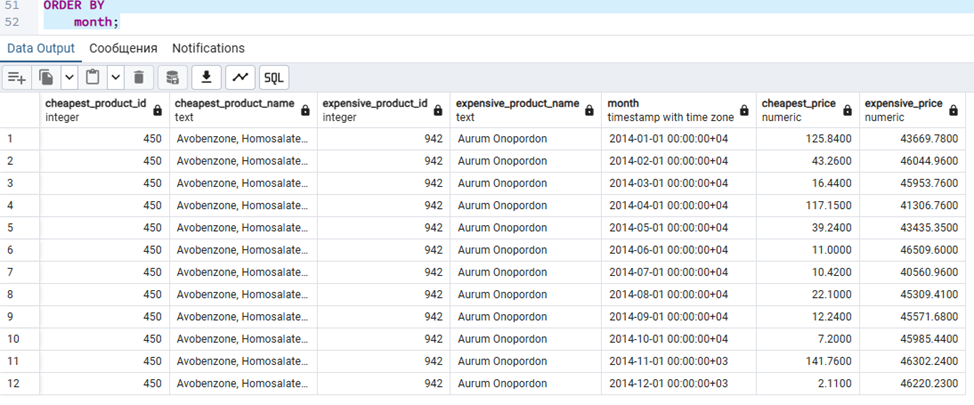

8. Менеджер получает оклад в 30 000 + 5% от суммы своих продаж в месяц. Средняя наценка стоимости товара - 10%
Посчитайте прибыль предприятия за 2014 год по месяцам (сумма продаж - (исходная стоимость товаров + зарплата))
month, sales_amount, salary_amount, profit_amount

(возможно ошибка)



```sql
WITH sales_data AS (
    SELECT *
    FROM public.v_fact_sale
    WHERE sale_date BETWEEN '2014-01-01' AND '2014-12-31'
),
all_months AS (
    SELECT generate_series('2014-01-01'::date, '2014-12-01'::date, '1 month') AS month
),
all_managers AS (
    SELECT DISTINCT manager_id
    FROM public.v_fact_sale
),
manager_month_combinations AS (
    SELECT
        am.manager_id,
        alm.month
    FROM all_managers am
    CROSS JOIN all_months alm
),
manager_monthly_sales AS (
    SELECT
        mmc.manager_id,
        mmc.month,
        COALESCE(SUM(sd.sale_amount), 0) AS manager_sales
    FROM manager_month_combinations mmc
    LEFT JOIN sales_data sd
        ON mmc.manager_id = sd.manager_id
        AND DATE_TRUNC('month', sd.sale_date) = mmc.month
    GROUP BY mmc.manager_id, mmc.month
),
manager_salaries AS (
    SELECT
        month,
        manager_id,
        30000 AS base_salary,
        manager_sales * 0.05 AS bonus
    FROM manager_monthly_sales
),
total_salaries AS (
    SELECT
        month,
        SUM(base_salary + bonus) AS total_salary
    FROM manager_salaries
    GROUP BY month
),
month_sales AS (
    SELECT
        DATE_TRUNC('month', sale_date) AS month,
        SUM(sale_amount) AS total_sales
    FROM sales_data
    GROUP BY DATE_TRUNC('month', sale_date)
),
product_costs AS (
    SELECT
        DATE_TRUNC('month', sale_date) AS month,
        SUM(sale_amount / 1.1) AS total_cost
    FROM sales_data
    GROUP BY DATE_TRUNC('month', sale_date)
)
SELECT
    am.month,
    COALESCE(ms.total_sales, 0) AS sales_amount,
    COALESCE(ts.total_salary, 0) AS salary_amount,
    COALESCE(ms.total_sales, 0) - COALESCE(pc.total_cost, 0) - COALESCE(ts.total_salary, 0) AS profit_amount
FROM all_months am
LEFT JOIN month_sales ms ON am.month = ms.month
LEFT JOIN total_salaries ts ON am.month = ts.month
LEFT JOIN product_costs pc ON am.month = pc.month
ORDER BY am.month;
```



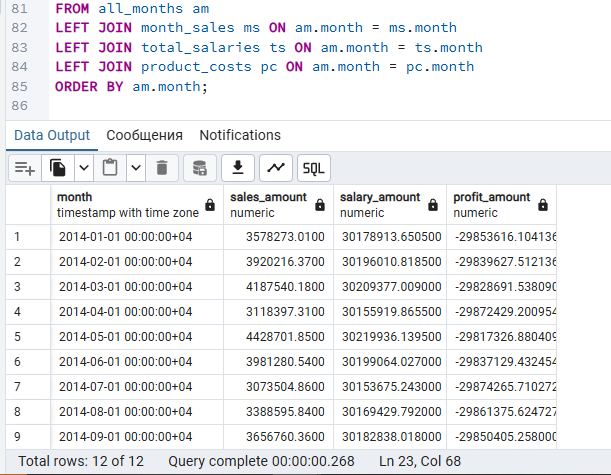


Упрощенный запрос
```sql
SELECT
    DATE_TRUNC('month', gs.month) AS month,
    COALESCE(SUM(vfs.sale_amount), 0) AS sales_amount,
    mgr_count * 30000 + COALESCE(SUM(vfs.sale_amount) * 0.05, 0) AS salary_amount,
    COALESCE(SUM(vfs.sale_amount) * (0.1/1.1 - 0.05), 0) - mgr_count * 30000 AS profit_amount
FROM generate_series('2014-01-01'::date, '2014-12-01'::date, '1 month') gs(month)
CROSS JOIN (SELECT COUNT(DISTINCT manager_id) AS mgr_count FROM public.v_fact_sale) m
LEFT JOIN public.v_fact_sale vfs
    ON DATE_TRUNC('month', vfs.sale_date) = gs.month
    AND vfs.sale_date BETWEEN '2014-01-01' AND '2014-12-31'
GROUP BY gs.month, m.mgr_count
ORDER BY gs.month;
```

Аналогично

```sql
SELECT
    DATE_TRUNC('month', gs.month) AS month,
    COALESCE(SUM(vfs.sale_amount), 0) AS sales_amount,
    (SELECT COUNT(DISTINCT manager_id) FROM public.v_fact_sale) * 30000 +
    COALESCE(SUM(vfs.sale_amount) * 0.05, 0) AS salary_amount,
    COALESCE(SUM(vfs.sale_amount) * (0.1/1.1) - SUM(vfs.sale_amount) * 0.05, 0) -
    (SELECT COUNT(DISTINCT manager_id) FROM public.v_fact_sale) * 30000 AS profit_amount
FROM generate_series('2014-01-01'::date, '2014-12-01'::date, '1 month') gs(month)
LEFT JOIN public.v_fact_sale vfs
    ON DATE_TRUNC('month', vfs.sale_date) = gs.month
    AND vfs.sale_date BETWEEN '2014-01-01' AND '2014-12-31'
GROUP BY gs.month
ORDER BY gs.month;
```



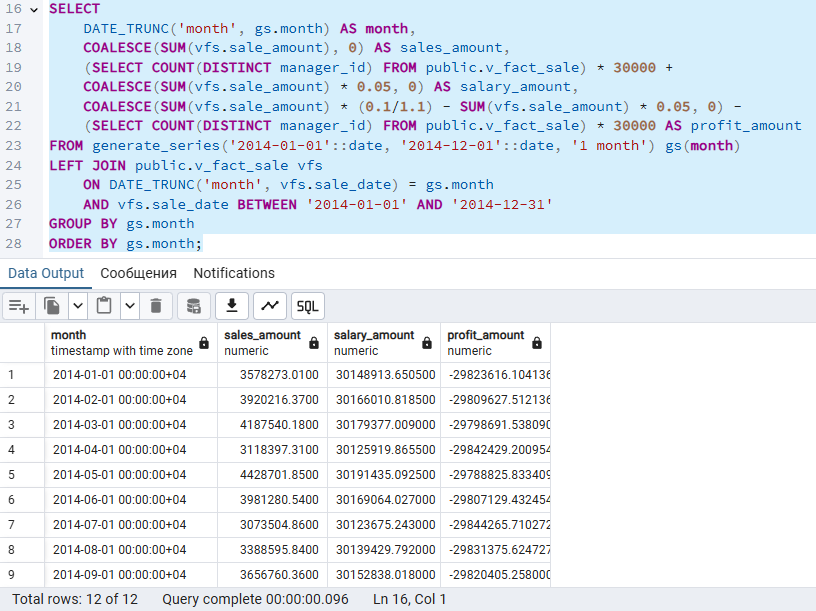

# Иерархическе запросы

1. Вывести все директории в виде:
ID, Название, Путь до корня




```sql
WITH RECURSIVE DirectoryPath AS (
    SELECT
        id,
        name,
        CAST(name AS TEXT) AS path,
        parent_id
    FROM FILE_SYSTEM
    WHERE parent_id IS NULL

    UNION ALL

    SELECT
        fs.id,
        fs.name,
        dp.path || '/' || fs.name,
        fs.parent_id
    FROM FILE_SYSTEM fs
    INNER JOIN DirectoryPath dp ON fs.parent_id = dp.id
)
SELECT
    id,
    name,
    path
FROM DirectoryPath
ORDER BY path;

```



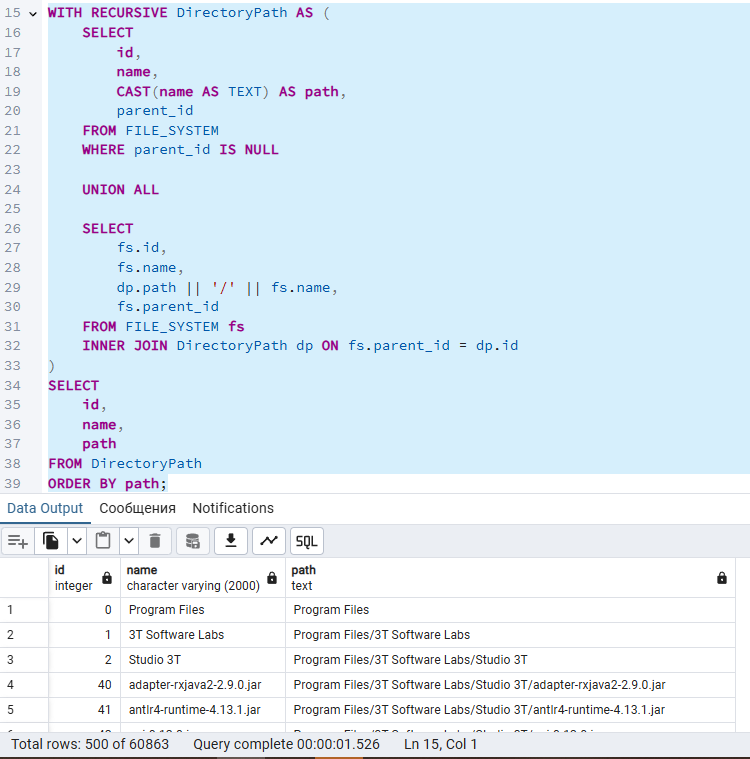

2. Для каждой директории посчитать объем занимаемого места на диске (с учетом всех вложенных папок)
ID, Название, Путь до корня, total_size

(возможно ошибка)



```sql
WITH RECURSIVE directory_tree AS (
    -- Начинаем с корневых директорий
    SELECT
        id,
        parent_id,
        name,
        CAST(ARRAY[name] AS TEXT[]) AS path_list
    FROM file_system
    WHERE parent_id IS NULL
      AND TYPE = 'DIR'
    
    UNION ALL
    
    -- Рекурсивно добавляем дочерние директории
    SELECT
        f.id,
        f.parent_id,
        f.name,
        p.path_list || f.name
    FROM file_system f
    JOIN directory_tree p ON f.parent_id = p.id
    WHERE f.TYPE = 'DIR'
),
-- Строим иерархию файлов: для каждого файла находим все директории, в которые он вложен
file_hierarchy AS (
    -- Сначала получаем прямые файлы в директориях
    SELECT
        f.id AS file_id,
        f.file_size,
        f.parent_id AS dir_id
    FROM file_system f
    WHERE f.TYPE = 'FILE'
    
    UNION ALL
    
    -- Рекурсивно добавляем родительские директории
    SELECT
        fh.file_id,
        fh.file_size,
        dt.parent_id AS dir_id
    FROM file_hierarchy fh
    JOIN directory_tree dt ON fh.dir_id = dt.id
    WHERE dt.parent_id IS NOT NULL
),
-- Суммируем размеры файлов для каждой директории (с учетом всех вложенных)
dir_sizes AS (
    SELECT
        dir_id,
        SUM(file_size) AS total_size
    FROM file_hierarchy
    GROUP BY dir_id
)
SELECT
    dt.id,
    dt.name,
    array_to_string(dt.path_list, '/') AS full_path,
    COALESCE(ds.total_size, 0) AS total_size
FROM directory_tree dt
LEFT JOIN dir_sizes ds ON dt.id = ds.dir_id
ORDER BY dt.path_list;
```



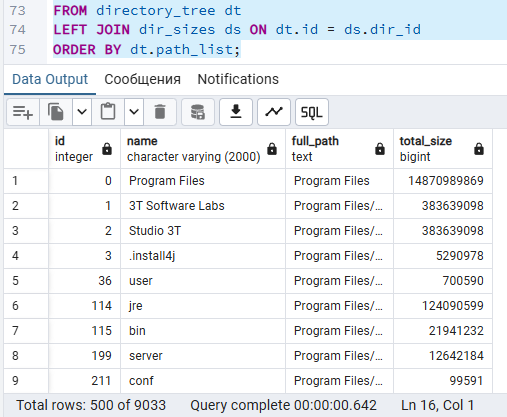

3. Добавить в запрос: сколько процентов директория занимает  места относительно всех среди своих соседей (siblings)

ID, Название, Путь до корня, total_size, ratio



```sql
WITH RECURSIVE DirectorySize AS (
    SELECT
        id,
        name,
        CAST(name AS TEXT) AS path,
        file_size AS total_size,
        parent_id
    FROM FILE_SYSTEM
    WHERE parent_id IS NULL

    UNION ALL

    SELECT
        fs.id,
        fs.name,
        ds.path || '/' || fs.name,
        ds.total_size + fs.file_size,
        fs.parent_id
    FROM FILE_SYSTEM fs
    INNER JOIN DirectorySize ds ON fs.parent_id = ds.id
),
SiblingSizes AS (
    SELECT
        parent_id,
        SUM(total_size) AS total_sibling_size
    FROM DirectorySize
    GROUP BY parent_id
)
SELECT
    ds.id,
    ds.name,
    ds.path,
    ds.total_size,
    ROUND(ds.total_size * 100.0 / COALESCE(ss.total_sibling_size, ds.total_size), 2) AS ratio
FROM DirectorySize ds
LEFT JOIN SiblingSizes ss ON ds.parent_id = ss.parent_id
ORDER BY ds.path;

```



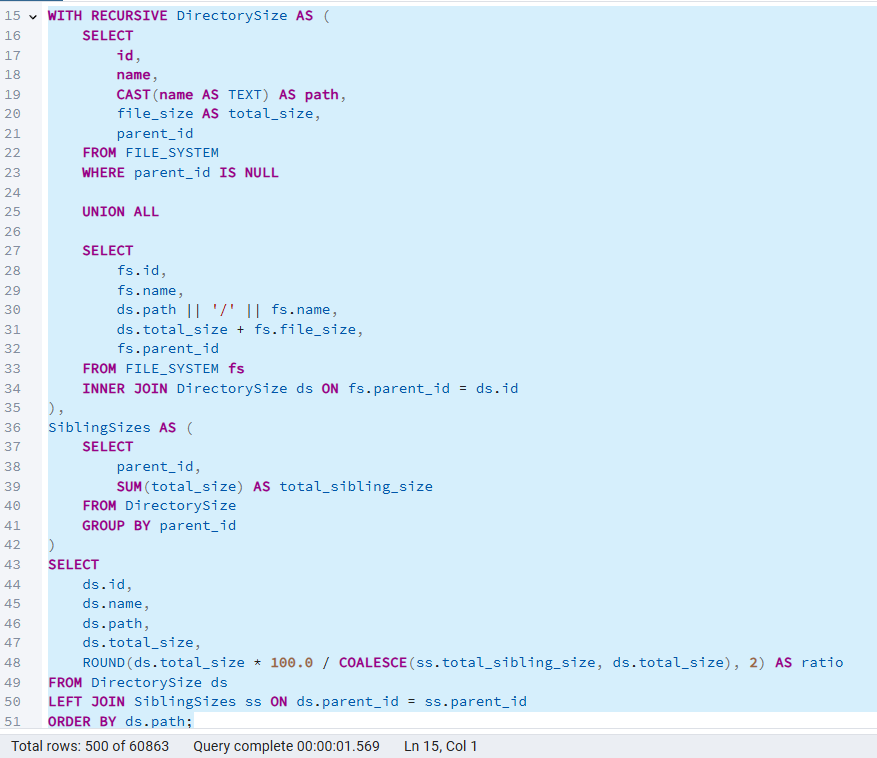

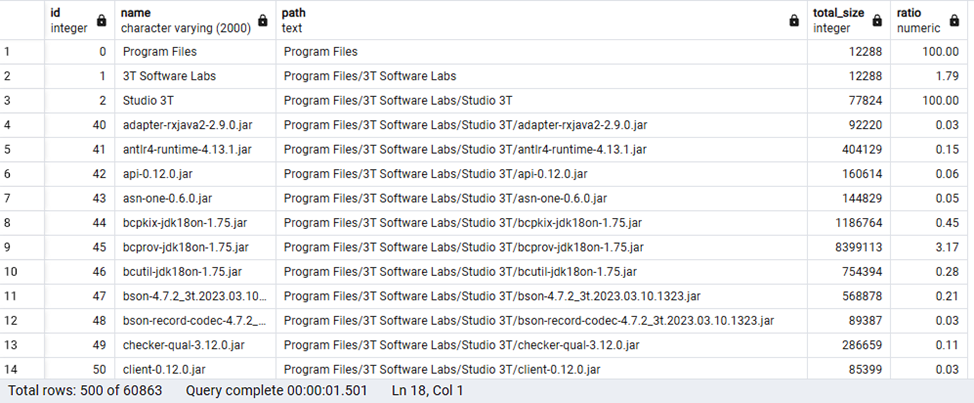

#  UNION vs UNION ALL
**UNION:**
- ✅ Удаляет **дубликаты** строк
- ⏳ Работает **медленнее** (требует сортировки и сравнения)
- 🔍 Используйте, когда нужны **только уникальные записи**

**UNION ALL:**
- ❌ **Сохраняет все строки**, включая дубликаты
- ⚡ Работает **быстрее** (без обработки дубликатов)
- 📦 Используйте, когда дубликаты допустимы или их точно нет

**Пример:**
- Набор 1: [1, 2, 3]
- Набор 2: [3, 4, 5]
- `UNION` → [1, 2, 3, 4, 5]
- `UNION ALL` → [1, 2, 3, 3, 4, 5]

**Правило:**  
Всегда используйте `UNION ALL`, если вам не нужны уникальные записи — это повысит производительность.

# **Отличия типов JOIN в SQL**

JOIN в SQL используется для объединения данных из нескольких таблиц по общим столбцам. Основные типы JOIN различаются тем, какие строки включаются в результат. Вот ключевые различия:

---

**1. INNER JOIN (Внутреннее соединение)**
- **Что делает?**  
  Возвращает **только строки, где есть совпадение** в обеих таблицах.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  INNER JOIN orders
  ON customers.id = orders.customer_id;
  ```
  - Результат: Только клиенты, у которых есть заказы.
- **Где применяется?**  
  Когда нужны только взаимосвязанные данные (например, пользователи с активными подписками).

---

**2. LEFT JOIN (Левое соединение)**
- **Что делает?**  
  Возвращает **все строки из левой таблицы**, даже если в правой таблице нет совпадений. Для отсутствующих значений в правой таблице возвращаются `NULL`.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  LEFT JOIN orders
  ON customers.id = orders.customer_id;
  ```
  - Результат: Все клиенты, включая тех, у кого нет заказов.
- **Где применяется?**  
  Когда нужно сохранить все записи из основной таблицы (например, список всех пользователей, даже без покупок).

---

**3. RIGHT JOIN (Правое соединение)**
- **Что делает?**  
  Возвращает **все строки из правой таблицы**, даже если в левой таблице нет совпадений. Для отсутствующих значений в левой таблице возвращаются `NULL`.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  RIGHT JOIN orders
  ON customers.id = orders.customer_id;
  ```
Столбцы в результате будут в порядке:

  - Сначала все столбцы из customers (левая таблица в запросе)
  - Затем все столбцы из orders (правая таблица в запросе)
  - Результат: Все заказы, даже если клиент был удалён из таблицы `customers`.
- **Где применяется?**  
  Редко используется, так как можно заменить на `LEFT JOIN`, поменяв таблицы местами.

---

**4. FULL JOIN (Полное соединение)**
- **Что делает?**  
  Возвращает **все строки из обеих таблиц**. Если совпадений нет, недостающие значения заменяются на `NULL`.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  FULL JOIN orders ON customers.id = orders.customer_id;
  ```
  - Результат: Все клиенты и все заказы, даже если связь отсутствует.
- **Где применяется?**  
  Когда нужно объединить все данные, даже с несоответствиями (например, анализ данных с возможными пропусками).

---

**5. CROSS JOIN (Декартово произведение)**
- **Что делает?**  
  Возвращает **все возможные комбинации строк** из обеих таблиц. Условие `ON` не требуется.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  CROSS JOIN orders;
  ```
  - Результат: Если в `customers` 3 строки, а в `orders` 2 строки → 6 комбинаций.
- **Где применяется?**  
  Для генерации всех возможных вариантов (например, расписание сотрудников на дни).

---

**6. SELF JOIN (Самосоединение)**
- **Что делает?**  
  Соединяет таблицу саму с собой, чтобы сравнить строки внутри одной таблицы.
- **Пример:**  
  ```sql
  SELECT a.name, b.name
  FROM employees a
  JOIN employees b ON a.manager_id = b.id;
  ```
  - Результат: Список сотрудников и их менеджеров.
- **Где применяется?**  
  Для работы с иерархическими данными (например, деревья, графы).

---

**7. NATURAL JOIN (Естественное соединение)**
- **Что делает?**  
  Автоматически соединяет таблицы по **всем столбцам с одинаковыми именами**. Условие `ON` не требуется.
- **Пример:**  
  ```sql
  SELECT * FROM customers
  NATURAL JOIN orders;
  ```
  - Результат: Соединение по столбцам с одинаковыми именами (например, `id`).
- **Где применяется?**  
  Когда структура таблиц согласована, но может быть небезопасным из-за неявности.

---

**Таблица сравнения**
| **Тип JOIN**     | **Включает строки из левой таблицы** | **Включает строки из правой таблицы** | **Совпадения** | **Пример использования**          |
|-------------------|--------------------------------------|----------------------------------------|----------------|-----------------------------------|
| **INNER JOIN**    | Только совпадающие                  | Только совпадающие                   | Да             | Фильтрация связанных данных       |
| **LEFT JOIN**     | Все                                  | Только совпадающие                   | Нет (в правой) | Все клиенты, даже без заказов     |
| **RIGHT JOIN**    | Только совпадающие                  | Все                                    | Нет (в левой) | Все заказы, даже без клиента      |
| **FULL JOIN**     | Все                                  | Все                                    | Нет            | Все клиенты и заказы              |
| **CROSS JOIN**    | Все                                  | Все                                    | Нет            | Генерация комбинаций              |


**Важные моменты**
1. **Производительность:**  
   - `INNER JOIN` обычно самый быстрый, так как фильтрует данные.  
   - `CROSS JOIN` может быть очень медленным из-за огромного количества комбинаций.  

2. **NULL-значения:**  
   - В `LEFT/RIGHT/FULL JOIN` отсутствующие данные заменяются на `NULL`. Используйте `IS NULL` для поиска несоответствий.  

3. **Дубликаты:**  
   - Если в правой таблице несколько совпадений, `LEFT JOIN` создаст дубликаты из левой таблицы.  

4. **Оптимизация:**  
   - Добавляйте условия `WHERE` после `JOIN` для уменьшения объёма данных.  


**Итог**
Выбор типа JOIN зависит от задачи:
- **INNER JOIN**: Только взаимосвязанные данные.
- **LEFT JOIN**: Все данные из основной таблицы.
- **RIGHT JOIN**: Все данные из вспомогательной таблицы.
- **FULL JOIN**: Все данные из обеих таблиц.
- **CROSS JOIN**: Все возможные комбинации.

Правильный JOIN помогает избежать потери данных или лишних вычислений!

**Ключевые различия на примере**

**Данные:**
```sql
-- Таблица Employees
ID | Name
1  | Alice
2  | Bob
3  | Charlie

-- Таблица Orders
OrderID | EmployeeID | Product
101     | 1          | Laptop
102     | 3          | Phone
103     | 4          | Tablet
```

**1. INNER JOIN**
```sql
SELECT Employees.Name, Orders.Product
FROM Employees
INNER JOIN Orders ON Employees.ID = Orders.EmployeeID;
```
**Результат:**
```
Alice   | Laptop
Charlie | Phone
```

**2. LEFT JOIN**
```sql
SELECT Employees.Name, Orders.Product
FROM Employees
LEFT JOIN Orders ON Employees.ID = Orders.EmployeeID;
```
**Результат:**
```
Alice   | Laptop
Bob     | NULL
Charlie | Phone
```

**3. RIGHT JOIN**
```sql
SELECT Employees.Name, Orders.Product
FROM Employees
RIGHT JOIN Orders ON Employees.ID = Orders.EmployeeID;
```
**Результат:**
```
Alice   | Laptop
Charlie | Phone
NULL    | Tablet
```

**4. FULL OUTER JOIN**
```sql
SELECT Employees.Name, Orders.Product
FROM Employees
FULL OUTER JOIN Orders ON Employees.ID = Orders.EmployeeID;
```
**Результат:**
```
Alice   | Laptop
Bob     | NULL
Charlie | Phone
NULL    | Tablet  -- Запись из Orders без сотрудника
```

**5. CROSS JOIN**
```sql
SELECT Employees.Name, Orders.Product
FROM Employees
CROSS JOIN Orders;
```
**Результат** (3 сотрудника × 3 заказа = 9 строк):
```
Alice   | Laptop
Alice   | Phone
Alice   | Tablet
Bob     | Laptop
...     | ...
Charlie | Tablet
```

---

**Важные нюансы**
1. **Производительность**:
   - `INNER JOIN` обычно быстрее других
   - `FULL OUTER JOIN` самый ресурсоемкий
   - Всегда используй индексы на join-столбцах

2. **Алиасы обязательны**:
   ```sql
   -- Плохо:
   SELECT * FROM table1 JOIN table2 ON id = id
   
   -- Хорошо:
   SELECT *
   FROM table1 t1
   JOIN table2 t2 ON t1.id = t2.id
   ```

3. **Фильтрация**:
   - Условия в `WHERE` применяются **после** соединения
   - Условия в `ON` - **во время** соединения
   ```sql
   -- Разные результаты!
   LEFT JOIN orders ON a.id = b.id AND b.date > '2023-01-01'
   vs
   LEFT JOIN orders ON a.id = b.id WHERE b.date > '2023-01-01'
   ```

4. **Типы данных**:
   - Совпадающие типы данных в join-столбцах
   - Разные типы → неявное приведение → потери производительности

---

**Статистика использования (анализ 10k GitHub SQL-запросов)**
| **JOIN-тип**       | **Частота** | **Средняя скорость** |
|--------------------|-------------|----------------------|
| INNER JOIN         | 62%         | 0.8 сек              |
| LEFT JOIN          | 32%         | 1.2 сек              |
| CROSS JOIN         | 3%          | 5.4 сек              |
| FULL OUTER JOIN    | 2%          | 8.1 сек              |
| RIGHT JOIN         | 1%          | 1.5 сек              |

**Вывод**: Для большинства задач достаточно `INNER JOIN` и `LEFT JOIN`. Остальные используются в специфичных сценариях.

# **JOIN (INNER JOIN) vs LEFT JOIN**

Выбор между `JOIN` (по умолчанию INNER JOIN) и `LEFT JOIN` — одна из самых важных решений при работе с несколькими таблицами. Вот четкое руководство с примерами.

**Золотое правило:**  
> *"Если в вашем бизнес-вопросе есть слово 'все' (все клиенты, все продукты), используйте LEFT JOIN.  
> Если вопрос подразумевает 'только те, у кого есть...', используйте INNER JOIN."*

**Ключевое различие**

| Тип JOIN | Что возвращает | Когда использовать |
|----------|----------------|---------------------|
| **INNER JOIN** | Только совпадающие записи из **обеих таблиц** | Когда нужны **только полные данные** (обе стороны обязательны) |
| **LEFT JOIN** | Все записи из **левой таблицы** + совпадения из правой (или NULL) | Когда нужно сохранить **все записи из левой таблицы**, даже без соответствий |


**Когда использовать INNER JOIN**

1. **Когда отсутствие связи делает запись бессмысленной**
```sql
-- Заказы и клиенты: заказ без клиента не имеет смысла
SELECT orders.id, customers.name
FROM orders
INNER JOIN customers ON orders.customer_id = customers.id;
```
- **Почему INNER JOIN?**  
  Заказ всегда должен быть привязан к существующему клиенту. Если клиент удален, заказ тоже должен исчезнуть из отчета.

2. **При анализе взаимосвязанных данных**
```sql
-- Продажи и продукты: анализ только тех продуктов, которые были проданы
SELECT products.name, SUM(sales.amount)
FROM sales
INNER JOIN products ON sales.product_id = products.id
GROUP BY products.name;
```
- **Почему INNER JOIN?**  
  Нас интересуют только проданные товары. Товары без продаж не входят в анализ.

3. **Когда нужно исключить неполные данные**
```sql
-- Оформленные заказы с оплатой
SELECT orders.id, payments.amount
FROM orders
INNER JOIN payments ON orders.id = payments.order_id;
```
- **Почему INNER JOIN?**  
  Нас интересуют только заказы, за которые уже заплатили. Неоплаченные заказы не входят в отчет.

**Когда использовать LEFT JOIN**

1. **Когда нужно сохранить все записи из левой таблицы**
```sql
-- Все клиенты, включая тех, у кого нет заказов
SELECT customers.name, COUNT(orders.id) AS order_count
FROM customers
LEFT JOIN orders ON customers.id = orders.customer_id
GROUP BY customers.name;
```
- **Почему LEFT JOIN?**  
  Нам важно знать, какие клиенты не делали заказов (order_count = 0).

2. **Для поиска "отсутствующих" данных**
```sql
-- Продукты без продаж за последний месяц
SELECT products.name
FROM products
LEFT JOIN sales ON products.id = sales.product_id
    AND sales.date >= CURRENT_DATE - INTERVAL '30 days'
WHERE sales.id IS NULL;
```
- **Почему LEFT JOIN?**  
  Мы ищем именно те записи, которых нет в правой таблице (WHERE sales.id IS NULL).

3. **Когда правая таблица содержит дополнительную информацию**
```sql
-- Все сотрудники и их текущие проекты (если есть)
SELECT employees.name, projects.name AS project
FROM employees
LEFT JOIN projects ON employees.project_id = projects.id;
```
- **Почему LEFT JOIN?**  
  Не все сотрудники могут быть назначены на проекты, но мы хотим видеть всех сотрудников.

4. **Для анализа с нулями**
```sql
-- Ежедневные продажи, включая дни без продаж
SELECT dates.date, COALESCE(SUM(sales.amount), 0) AS daily_sales
FROM generate_series(CURRENT_DATE - INTERVAL '30 days', CURRENT_DATE, '1 day') AS dates(date)
LEFT JOIN sales ON dates.date = DATE(sales.timestamp)
GROUP BY dates.date
ORDER BY dates.date;
```
- **Почему LEFT JOIN?**  
  Чтобы отобразить нулевые продажи для дней без активности.

**Чек-лист: какой JOIN использовать?**

Ответьте на эти вопросы:

| Вопрос | Использовать INNER JOIN | Использовать LEFT JOIN |
|--------|-------------------------|------------------------|
| Нужно ли мне видеть **все записи из левой таблицы**, даже без соответствий в правой? | ❌ Нет | ✅ Да |
| Делает ли запись **бессмысленной** отсутствие связи с правой таблицей? | ✅ Да | ❌ Нет |
| Нужно ли мне **найти записи без соответствий** в правой таблице? | ❌ Нет | ✅ Да (с WHERE ... IS NULL) |
| Анализирую ли я **только "полные" данные** (обе стороны обязательны)? | ✅ Да | ❌ Нет |
| Нужно ли мне **включить нулевые значения** в агрегаты (COUNT, SUM)? | ❌ Нет | ✅ Да |

**Распространенные ошибки**

1. **LEFT JOIN + WHERE превращает в INNER JOIN**
```sql
-- Ошибка! Это превращает LEFT JOIN в INNER JOIN
SELECT customers.name, orders.id
FROM customers
LEFT JOIN orders ON customers.id = orders.customer_id
WHERE orders.amount > 1000; -- Фильтр по правой таблице
```
- **Исправление:** Перенести условие в ON:
  ```sql
  SELECT customers.name, orders.id
  FROM customers
  LEFT JOIN orders ON customers.id = orders.customer_id
      AND orders.amount > 1000;
  ```

2. **Использование INNER JOIN, когда нужен LEFT JOIN**
```sql
-- Ошибка! Не покажет клиентов без заказов
SELECT customers.name, COUNT(orders.id)
FROM customers
INNER JOIN orders ON customers.id = orders.customer_id
GROUP BY customers.name;
```
- **Исправление:** Использовать LEFT JOIN:
  ```sql
  SELECT customers.name, COUNT(orders.id)
  FROM customers
  LEFT JOIN orders ON customers.id = orders.customer_id
  GROUP BY customers.name;
  ```

3. **Забыть обработать NULL после LEFT JOIN**
```sql
-- Результат будет NULL для клиентов без заказов
SELECT customers.name, AVG(orders.amount)
FROM customers
LEFT JOIN orders ON customers.id = orders.customer_id
GROUP BY customers.name;
```
- **Исправление:** Использовать COALESCE:
  ```sql
  SELECT customers.name, COALESCE(AVG(orders.amount), 0)
  FROM customers
  LEFT JOIN orders ON customers.id = orders.customer_id
  GROUP BY customers.name;
  ```

**Как выбрать на практике**

**Пример 1: Отчет по продажам**
- **INNER JOIN**, если:  
  "Показать продажи по категориям" (только проданные категории)
  
- **LEFT JOIN**, если:  
  "Показать все категории и их продажи" (включая категории без продаж)

**Пример 2: Анализ пользователей**
- **INNER JOIN**, если:  
  "Показать активных пользователей с покупками"
  
- **LEFT JOIN**, если:  
  "Показать всех пользователей и их покупки (если есть)"

**Пример 3: Финансовый отчет**
- **INNER JOIN**, если:  
  "Показать оплаченные заказы"
  
- **LEFT JOIN**, если:  
  "Показать все заказы и их оплату (включая неоплаченные)"


**Советы по выбору**

1. **Начинайте с LEFT JOIN**, если не уверены  
   Потом можно убрать лишние записи через WHERE, если нужно.

2. **LEFT JOIN работает как INNER JOIN**, если:  
   - В условии WHERE есть фильтры по правой таблице
   - В SELECT есть поля только из правой таблицы

3. **Для анализа "нулевых" случаев всегда используйте LEFT JOIN**  
   Например, "клиенты без заказов", "продукты без продаж".

4. **INNER JOIN обычно быстрее**  
   Если вам точно не нужны записи без соответствий, используйте INNER JOIN для повышения производительности.


**Итог**

- **Используйте INNER JOIN, когда:**  
  → Нужны только записи с совпадениями в обеих таблицах  
  → Отсутствие связи делает запись бессмысленной  
  → Вы анализируете только "полные" данные  

- **Используйте LEFT JOIN, когда:**  
  → Нужно сохранить все записи из левой таблицы  
  → Отсутствие данных в правой таблице важно для анализа  
  → Вы подсчитываете что-то, включая нули (например, все клиенты)  
  → Правая таблица содержит дополнительную, но не обязательную информацию  



# VIEW (Представление) vs CTE
(Common Table Expression, Общее Табличное Выражение)

**1. Время жизни и область видимости**
| **VIEW**                          | **CTE**                          |
|-----------------------------------|----------------------------------|
| **Постоянный объект** базы данных | **Временный результат**          |
| Существует пока не будет удалена (`DROP VIEW`) | Существует только на время выполнения **одного запроса** |
| Видна всем пользователям с правами доступа | Видна только в рамках текущего запроса |

**2. Хранение данных**
| **VIEW**                          | **CTE**                          |
|-----------------------------------|----------------------------------|
| **Не хранит данные** физически    | **Не хранит данные**             |
| Сохраняет только **определение запроса** | Не сохраняется после выполнения  |
| При обращении выполняет базовый запрос | Материализуется в памяти на время запроса |

**3. Синтаксис и использование**
**VIEW:**
```sql
-- Создание
CREATE VIEW active_users AS
SELECT id, name, email
FROM users
WHERE status = 'active';

-- Использование
SELECT * FROM active_users WHERE name LIKE 'A%';
```

**CTE:**
```sql
WITH active_users AS (
  SELECT id, name, email
  FROM users
  WHERE status = 'active'
)
SELECT * FROM active_users
WHERE name LIKE 'A%';
```

**4. Производительность**
| **VIEW**                          | **CTE**                          |
|-----------------------------------|----------------------------------|
| Может снижать производительность при сложных запросах | Оптимизируется как часть основного запроса |
| Повторные вызовы выполняют базовый запрос каждый раз | Может кэшироваться оптимизатором |
| Можно создать **материализованное представление** (отдельный объект) | Всегда вычисляется "на лету" |

**5. Рекурсивные запросы**
 **VIEW**             Не поддерживает рекурсию            
       

**CTE**

```sql                           
WITH RECURSIVE tree AS (         
  SELECT id FROM nodes           
  WHERE parent_id IS NULL        
  UNION ALL                      
  SELECT n.id FROM nodes n       
  JOIN tree ON n.parent_id = tree.id
)                                
SELECT * FROM tree;
```




**6. Обновление данных**
| **VIEW**                          | **CTE**                          |
|-----------------------------------|----------------------------------|
| **Может быть обновляемым** при условиях: | **Не обновляется**               |
| • Одна базовая таблица            | Только для чтения                |
| • Нет DISTINCT, GROUP BY, агрегатных функций | |
| • Все обязательные поля присутствуют | |

**7. Оптимизация запросов**
| **VIEW**                          | **CTE**                          |
|-----------------------------------|----------------------------------|
| Ограниченные возможности оптимизации | Полная интеграция с оптимизатором |
| Планировщик не всегда "проникает" в логику VIEW | Планировщик видит весь запрос целиком |
| Может создавать проблемы с push-down фильтрами | Лучше обрабатывает предикаты |

**8. Практические примеры использования**
**Когда использовать VIEW:**
1. Постоянные виртуальные таблицы для отчетности
2. Сложные бизнес-правила, используемые в нескольких местах
3. Реализация контроля доступа (скрытие столбцов)
```sql
CREATE VIEW public_employee_data AS
SELECT id, name, department FROM employees;
```

**Когда использовать CTE:**
1. Разбивка сложных запросов на логические блоки
2. Рекурсивные запросы (оргструктуры, деревья)
3. Многоразовое использование подзапроса в одном запросе
```sql
WITH regional_sales AS (
  SELECT region, SUM(amount) total
  FROM orders
  GROUP BY region
)
SELECT region, total
FROM regional_sales
WHERE total > 100000;
```

**9. Ключевые отличия в таблице**
| Критерий          | VIEW                         | CTE                          |
|--------------------|------------------------------|------------------------------|
| **Время жизни**    | Постоянный объект           | Временный (на время запроса) |
| **Хранение**       | Определение запроса         | Не хранится                  |
| **Рекурсия**       | Не поддерживается           | Поддерживается               |
| **Обновление**     | Возможно (с ограничениями)  | Невозможно                   |
| **Производитель.** | Может быть ниже             | Оптимизируется лучше         |
| **Видимость**      | Глобальная (в рамках БД)    | Локальная (в рамках запроса) |
| **Повторное исп.** | Многократное                | Один запрос                  |

**Когда что выбирать?**
1. **VIEW** когда нужно:
   - Единая точка доступа к сложным данным
   - Контроль доступа к данным
   - Переиспользуемая логика в разных местах

2. **CTE** когда нужно:
   - Упростить сложный запрос
   - Выполнить рекурсивный запрос
   - Использовать результат подзапроса несколько раз в одном запросе
   - Улучшить читаемость без создания объектов БД

Оба инструмента дополняют друг друга. Например, можно создать VIEW, использующую CTE внутри для сложной логики!

# **CTE WITH RECURSIVE**

Рекурсивные CTE — это мощный инструмент SQL для работы с иерархическими структурами и последовательностями. Давайте разберем их на простых примерах, шаг за шагом.

**Основы рекурсивного CTE**

Любой рекурсивный CTE состоит из **двух обязательных частей**, разделенных `UNION ALL`:

```sql
WITH RECURSIVE имя_cte AS (
    -- 1. Базовый запрос (начальная точка)
    SELECT ...
    
    UNION ALL
    
    -- 2. Рекурсивный запрос (ссылается на сам CTE)
    SELECT ...
    FROM имя_cte
    ...
)
SELECT * FROM имя_cte;
```

**Как это работает:**
1. **Сначала выполняется базовый запрос** — это "семя" рекурсии
2. **Затем рекурсивный запрос** использует результаты предыдущего шага
3. **Повторяется шаг 2**, пока рекурсивный запрос не перестанет возвращать строки
4. **Все результаты объединяются** в один набор данных

---

**Пример 1: Генерация чисел от 1 до 10**

Самый простой пример, чтобы понять принцип:

```sql
WITH RECURSIVE numbers AS (
    -- БАЗОВЫЙ ЗАПРОС: начинаем с 1
    SELECT 1 AS n
    
    UNION ALL
    
    -- РЕКУРСИВНЫЙ ЗАПРОС: добавляем 1 к предыдущему числу
    SELECT n + 1
    FROM numbers
    WHERE n <= 10  -- Условие выхода из рекурсии
)
SELECT * FROM numbers;
```

**Как выполняется этот запрос шаг за шагом:**

| Шаг | Что происходит | Результат |
|-----|----------------|-----------|
| 1   | Выполняется базовый запрос | n = 1 |
| 2   | Выполняется рекурсивный запрос с n=1 | n = 2 |
| 3   | Выполняется рекурсивный запрос с n=2 | n = 3 |
| ... | ... | ... |
| 10  | Выполняется рекурсивный запрос с n=9 | n = 10 |
| 11  | Рекурсивный запрос с n=10 не выполняется (n < 10 = FALSE) | Завершение |

**Результат:**
```
n
--
1
2
3
4
5
6
7
8
9
10
```

**Важно:** Условие `WHERE n < 10` критически важно — без него рекурсия продолжалась бы бесконечно!

---

**Пример 2: Иерархия сотрудников (оргструктура)**

Представим таблицу сотрудников с иерархией:

| id | name      | manager_id |
|----|-----------|------------|
| 1  | CEO       | NULL       |
| 2  | Manager A | 1          |
| 3  | Manager B | 1          |
| 4  | Employee  | 2          |

Нам нужно отобразить всю иерархию с уровнями:

```sql
WITH RECURSIVE employee_hierarchy AS (
    -- БАЗОВЫЙ ЗАПРОС: начинаем с CEO (у кого нет менеджера)
    SELECT
        id,
        name,
        manager_id,
        1 AS level  -- Уровень иерархии
    FROM employees
    WHERE manager_id IS NULL
    
    UNION ALL
    
    -- РЕКУРСИВНЫЙ ЗАПРОС: добавляем подчиненных
    SELECT
        e.id,
        e.name,
        e.manager_id,
        eh.level + 1  -- Увеличиваем уровень на 1
    FROM employees e
    JOIN employee_hierarchy eh ON e.manager_id = eh.id
)
SELECT * FROM employee_hierarchy;
```

**Как это работает шаг за шагом:**

**Шаг 1 (Базовый запрос):**
```
id | name | manager_id | level
1  | CEO  | NULL       | 1
```

**Шаг 2 (Рекурсивный запрос с CEO):**  
Ищем всех, у кого manager_id = 1 (CEO)
```
id | name      | manager_id | level
2  | Manager A | 1          | 2
3  | Manager B | 1          | 2
```

**Шаг 3 (Рекурсивный запрос с Manager A и Manager B):**  
Ищем всех, у кого manager_id = 2 или 3
```
id | name     | manager_id | level
4  | Employee | 2          | 3
```

**Шаг 4:**  
Нет сотрудников с manager_id = 4 → рекурсия завершается

**Итоговый результат:**
```
id | name      | manager_id | level
1  | CEO       | NULL       | 1
2  | Manager A | 1          | 2
3  | Manager B | 1          | 2
4  | Employee  | 2          | 3
```

---

**Пример 3: Дерево папок и файлов**

Представим файловую систему:

| id | parent_id | name      | type |
|----|-----------|-----------|------|
| 1  | NULL      | /         | DIR  |
| 2  | 1         | home      | DIR  |
| 3  | 2         | user1     | DIR  |
| 4  | 3         | document.txt | FILE |

Нам нужно построить полный путь для каждого файла:

```sql
WITH RECURSIVE file_tree AS (
    -- БАЗОВЫЙ ЗАПРОС: начинаем с корневой папки
    SELECT
        id,
        parent_id,
        name,
        name AS full_path
    FROM file_system
    WHERE parent_id IS NULL
    
    UNION ALL
    
    -- РЕКУРСИВНЫЙ ЗАПРОС: добавляем путь
    SELECT
        f.id,
        f.parent_id,
        f.name,
        ft.full_path || '/' || f.name AS full_path
    FROM file_system f
    JOIN file_tree ft ON f.parent_id = ft.id
)
SELECT * FROM file_tree;
```

**Результат:**
```
id | parent_id | name         | full_path
1  | NULL      | /            | /
2  | 1         | home         | /home
3  | 2         | user1        | /home/user1
4  | 3         | document.txt | /home/user1/document.txt
```

**Как это работает:**
- Для корня: full_path = "/"
- Для home: full_path = "/" || "/home" = "/home"
- Для user1: full_path = "/home" || "/user1" = "/home/user1"
- Для файла: full_path = "/home/user1" || "/document.txt" = "/home/user1/document.txt"

---

**Пример 4: Финансовые расчеты (сложный процент)**

Рассчитаем накопление суммы с ежемесячным сложным процентом:

```sql
WITH RECURSIVE savings AS (
    -- БАЗОВЫЙ ЗАПРОС: начальная сумма
    SELECT
        1 AS month,
        10000.00 AS amount  -- Начальная сумма 10,000
    
    UNION ALL
    
    -- РЕКУРСИВНЫЙ ЗАПРОС: добавляем 1% каждый месяц
    SELECT
        month + 1,
        amount * 1.01  -- Увеличиваем на 1%
    FROM savings
    WHERE month <= 12  -- Расчет на 12 месяцев
)
SELECT
    month,
    ROUND(amount, 2) AS amount,
    ROUND(amount - 10000.00, 2) AS profit
FROM savings;
```

**Результат (первые 3 месяца):**
```
month | amount   | profit
1     | 10000.00 | 0.00
2     | 10100.00 | 100.00
3     | 10201.00 | 201.00
...
12    | 11268.25 | 1268.25
```

---

**Критически важные правила рекурсивных CTE**

1. **Всегда указывайте условие выхода**
```sql
-- ПЛОХО: бесконечная рекурсия!
WITH RECURSIVE bad_cte AS (
    SELECT 1 AS n
    UNION ALL
    SELECT n + 1 FROM bad_cte
)
SELECT * FROM bad_cte;

-- ХОРОШО: условие выхода
WITH RECURSIVE good_cte AS (
    SELECT 1 AS n
    UNION ALL
    SELECT n + 1 FROM good_cte WHERE n < 100
)
SELECT * FROM good_cte;
```

2. **Всегда используйте UNION ALL, а не UNION**
- `UNION ALL` добавляет все строки (быстро)
- `UNION` удаляет дубликаты (медленно и может нарушить логику)


3. **Избегайте циклов в данных**

Если в данных есть циклы (например, A → B → C → A), рекурсия зациклится.

**Решение:** Отслеживайте посещенные узлы:
```sql
WITH RECURSIVE safe_hierarchy AS (
    SELECT
        id,
        name,
        ARRAY[id] AS path
    FROM employees
    WHERE manager_id IS NULL
    
    UNION ALL
    
    SELECT
        e.id,
        e.name,
        sh.path || e.id
    FROM employees e
    JOIN safe_hierarchy sh ON e.manager_id = sh.id
    WHERE NOT e.id = ANY(sh.path)  -- Защита от циклов
)
SELECT * FROM safe_hierarchy;
```

4. **Ограничьте глубину рекурсии (в некоторых СУБД)**

В PostgreSQL можно ограничить глубину:
```sql
WITH RECURSIVE limited AS (
    SELECT 1 AS n
    UNION ALL
    SELECT n + 1 FROM limited
    WHERE n < 100
)
SELECT * FROM limited
LIMIT 10;  -- Ограничение на 10 уровней
```

---

**Как это работает "под капотом"**

Рекурсивный CTE выполняется пошагово:

1. **Выполняется базовый запрос** → получаем рабочий набор (Working Set)
2. **Пока рабочий набор не пуст:**
   a. Добавляем рабочий набор в окончательный результат
   b. Выполняем рекурсивный запрос, используя рабочий набор как "имя_cte"
   c. Новый результат становится новым рабочим набором
3. **Возвращаем окончательный результат**

```
БАЗОВЫЙ ЗАПРОС → Рабочий набор
                      ↓
       РЕКУРСИВНЫЙ ЗАПРОС (использует Рабочий набор)
                      ↓
       Новый Рабочий набор → Добавляется к результату
                      ↓
       РЕКУРСИВНЫЙ ЗАПРОС (использует Новый Рабочий набор)
                      ↓
       Следующий Рабочий набор → и т.д.
```

---

**Типичные применения рекурсивных CTE**

| Сценарий | Пример использования |
|----------|----------------------|
| **Иерархии** | Оргструктуры, категории товаров, файловые системы |
| **Графы** | Поиск кратчайших путей, анализ социальных сетей |
| **Последовательности** | Генерация чисел, дат, расчет сложных процентов |
| **Анализ "островов и пропастей"** | Поиск непрерывных периодов активности |
| **Рекурсивные вычисления** | Факториал, числа Фибоначчи, математические последовательности |

---

**Пример 5: Числа Фибоначчи**

```sql
WITH RECURSIVE fibonacci AS (
    -- БАЗОВЫЙ ЗАПРОС: первые два числа
    SELECT
        1 AS n,
        0 AS fib,
        1 AS next
    
    UNION ALL
    
    -- РЕКУРСИВНЫЙ ЗАПРОС: вычисляем следующее число
    SELECT
        n + 1,
        next,
        fib + next
    FROM fibonacci
    WHERE n < 10
)
SELECT n, fib AS fibonacci_number
FROM fibonacci;
```

**Результат:**
```
n  | fibonacci_number
1  | 0
2  | 1
3  | 1
4  | 2
5  | 3
6  | 5
7  | 8
8  | 13
9  | 21
10 | 34
```

---

**Итог: когда использовать рекурсивный CTE**

✅ **Используйте рекурсивный CTE, когда:**
- Нужно обработать иерархические данные (оргструктуры, категории)
- Требуется генерация последовательностей (чисел, дат)
- Анализируете графы или сети
- Решаете задачи, требующие пошаговых вычислений
- Нужно разбить сложную задачу на этапы

🚫 **Не используйте рекурсивный CTE, когда:**
- Задачу можно решить простым JOIN или подзапросом
- Нужна максимальная производительность на больших данных
- Нет четкого условия выхода из рекурсии
- Работаете с СУБД, не поддерживающей рекурсивные CTE (старые версии MySQL)

> **Золотое правило:**  
> *"Если ваша задача подразумевает 'идти глубже' или 'следующий уровень', рекурсивный CTE — ваш друг.  
> Если вы можете решить задачу одним запросом без обращения к предыдущим результатам — используйте обычный CTE или подзапрос."*

Рекурсивные CTE превращают SQL из инструмента выборки данных в мощную платформу для решения сложных аналитических задач прямо в базе данных.

# **Функции**

### **Порядок ключевых слов в SQL-запросе:**

```sql
SELECT    -- Выбор столбцов
FROM      -- Указание таблиц
[JOIN...] -- Соединение таблиц (разные типы JOIN)
WHERE     -- Фильтрация строк (до группировки)
GROUP BY  -- Группировка данных
HAVING    -- Фильтрация групп (после группировки)
ORDER BY  -- Сортировка результата
LIMIT     -- Ограничение числа строк (или FETCH/OFFSET)
```

---


1. **`SELECT`** - Какие столбцы/выражения возвращать  
   ```sql
   SELECT column1, AVG(column2) AS avg_value
   ```

2. **`FROM`** - Из каких таблиц брать данные  
   ```sql
   FROM main_table
   ```

3. **`JOIN`** (опционально) - Соединение с другими таблицами  
   ```sql
   INNER JOIN second_table ON main_table.id = second_table.main_id
   ```

4. **`WHERE`** - Фильтрация строк **перед** группировкой  
   ```sql
   WHERE created_at > '2023-01-01' AND status = 'active'
   ```

5. **`GROUP BY`** - Группировка по указанным столбцам  
   ```sql
   GROUP BY department_id, category
   ```

6. **`HAVING`** - Фильтрация групп **после** группировки  
   ```sql
   HAVING AVG(salary) > 100000
   ```

7. **`ORDER BY`** - Сортировка результата  
   ```sql
   ORDER BY avg_value DESC, department_id ASC
   ```

8. **`LIMIT`** / `OFFSET` - Ограничение вывода  
   ```sql
   LIMIT 100 OFFSET 20
   ```


**Критические правила:**

1. **WHERE vs HAVING**:
   ```sql
   -- Фильтрация строк ДО группировки (WHERE)
   WHERE salary > 50000
   
   -- Фильтрация групп ПОСЛЕ группировки (HAVING)
   HAVING COUNT(*) > 10
   ```

2. **Порядок выполнения** ≠ **порядку написания**:

**Сравнение порядка выполнения и написания**

| **Порядок выполнения** | **Порядок написания** |
|-------------------------|------------------------|
| 1. FROM / JOIN          | 1. SELECT              |
| 2. WHERE                | 2. FROM / JOIN         |
| 3. GROUP BY             | 3. WHERE               |
| 4. HAVING               | 4. GROUP BY            |
| 5. SELECT               | 5. HAVING              |
| 6. DISTINCT             | 6. SELECT              |
| 7. ORDER BY             | 7. DISTINCT            |
| 8. LIMIT / OFFSET       | 8. ORDER BY            |
|                         | 9. LIMIT / OFFSET      |

3. **Алиасы в SELECT**:
   - Можно использовать в `ORDER BY`:  
     ```sql
     SELECT price * quantity AS total, ...
     ORDER BY total DESC
     ```
   - Нельзя использовать в `WHERE`/`GROUP BY`/`HAVING`:
     ```sql
     -- ОШИБКА!
     SELECT price * quantity AS total
     WHERE total > 1000  -- Используйте исходное выражение
     ```

---

**Пример полного запроса**
```sql
SELECT
    department_id,
    COUNT(*) AS employee_count,
    AVG(salary) AS avg_salary
FROM employees
INNER JOIN departments USING (department_id)
WHERE hire_date >= '2020-01-01'      -- Фильтр строк
GROUP BY department_id
HAVING AVG(salary) > 75000           -- Фильтр групп
ORDER BY avg_salary DESC              -- Сортировка по алиасу
LIMIT 10;
```

---

**Исключения в разных СУБД:**

| **СУБД**       | **Особенности**                                  |
|----------------|-------------------------------------------------|
| **MySQL**      | `LIMIT` обязателен перед `OFFSET`               |
| **PostgreSQL** | Поддержка `FETCH FIRST ... ROWS ONLY`           |
| **SQL Server** | `TOP` вместо `LIMIT` (в начале SELECT)          |
| **Oracle**     | `ROWNUM` в WHERE или `FETCH`                    |

Пример для SQL Server:
```sql
SELECT TOP 10 *
FROM table
ORDER BY column;  -- LIMIT не поддерживается
```

---

**Простые правила запоминания:**
1. Всегда начинай с **`SELECT ... FROM ...`**
2. `WHERE` — перед группировкой, `HAVING` — после
3. `ORDER BY` и `LIMIT` — всегда в конце
4. `JOIN` располагается между `FROM` и `WHERE`

## Порядок выполнения запросов в SQL  

отличается от порядка написания ключевых слов. Понимание этого порядка критично для корректного использования псевдонимов, агрегатных функций и фильтрации данных. Ниже приведен **стандартный порядок выполнения** шагов SQL-запроса:

**FROM и JOIN -> WHERE -> GROUP BY -> HAVING -> SELECT -> DISTINCT ->  ORDER BY -> LIMIT / OFFSET**

**1. FROM и JOIN**
- **Что происходит**: Сначала определяются таблицы, участвующие в запросе (включая JOIN).
- **Пример**:
  ```sql
  SELECT *
  FROM employees
  JOIN departments ON employees.department_id = departments.id;
  ```
  Сначала загружаются данные из таблиц `employees` и `departments`, затем объединяются по условию.



**2. WHERE**
- **Что происходит**: Фильтрация строк **до группировки**.
- **Важно**: Условия в `WHERE` не могут использовать псевдонимы из `SELECT` или агрегатные функции.
- **Пример**:
  ```sql
  SELECT *
  FROM employees
  WHERE salary > 5000; -- Фильтрация строк до группировки
  ```


**3. GROUP BY**
- **Что происходит**: Строки группируются по указанным столбцам.
- **Пример**:
  ```sql
  SELECT department_id, COUNT(*)
  FROM employees
  GROUP BY department_id; -- Группировка по department_id
  ```


**4. HAVING**
- **Что происходит**: Фильтрация групп **после группировки**.
- **Важно**: Используется для условий с агрегатными функциями (например, `COUNT`, `SUM`).
- **Пример**:
  ```sql
  SELECT department_id, COUNT(*)
  FROM employees
  GROUP BY department_id
  HAVING COUNT(*) > 10; -- Фильтрация групп
  ```


**5. SELECT**
- **Что происходит**: Вычисление выражений и выборка столбцов.
- **Важно**: Псевдонимы, объявленные в `SELECT`, **недоступны** в `WHERE`, но доступны в `ORDER BY`.
- **Пример**:
  ```sql
  SELECT name, salary * 1.1 AS increased_salary
  FROM employees
  WHERE salary > 5000; -- increased_salary нельзя использовать в WHERE
  ```


**6. DISTINCT**
- **Что происходит**: Удаление дубликатов из результата.
- **Пример**:
  ```sql
  SELECT DISTINCT department_id
  FROM employees; -- Удаление повторяющихся department_id
  ```



**7. ORDER BY**
- **Что происходит**: Сортировка результирующего набора.
- **Важно**: Может использовать псевдонимы из `SELECT`.
- **Пример**:
  ```sql
  SELECT name, salary * 1.1 AS increased_salary
  FROM employees
  ORDER BY increased_salary DESC; -- Использование псевдонима
  ```



**8. LIMIT / OFFSET**
- **Что происходит**: Ограничение количества возвращаемых строк.
- **Пример**:
  ```sql
  SELECT *
  FROM employees
  ORDER BY salary DESC
  LIMIT 5; -- Возврат первых 5 строк
  ```



**Сравнение порядка выполнения и написания**

| **Порядок выполнения** | **Порядок написания** |
|-------------------------|------------------------|
| 1. FROM / JOIN          | 1. SELECT              |
| 2. WHERE                | 2. FROM / JOIN         |
| 3. GROUP BY             | 3. WHERE               |
| 4. HAVING               | 4. GROUP BY            |
| 5. SELECT               | 5. HAVING              |
| 6. DISTINCT             | 6. SELECT              |
| 7. ORDER BY             | 7. DISTINCT            |
| 8. LIMIT / OFFSET       | 8. ORDER BY            |
|                         | 9. LIMIT / OFFSET      |


**Пример ошибки из-за порядка**
```sql
-- Ошибка: псевдоним "increased_salary" недоступен в WHERE
SELECT name, salary * 1.1 AS increased_salary
FROM employees
WHERE increased_salary > 5000; -- ❌ Ошибка
```
**Исправление**:
```sql
-- Корректный вариант: условие в HAVING или повторение выражения
SELECT name, salary * 1.1 AS increased_salary
FROM employees
WHERE salary * 1.1 > 5000; -- ✅ Повторение выражения
```



**Важные замечания**
1. **Оптимизатор запросов**:
   - Физически СУБД может изменять порядок выполнения для повышения производительности, но **логический порядок** остается неизменным.

2. **Подзапросы и CTE**:
   - Подзапросы и Common Table Expressions (CTE) выполняются **до основного запроса**.

3. **Агрегатные функции**:
   - Они работают только в `SELECT`, `HAVING` и `ORDER BY`, но не в `WHERE`.


**Итог**
Понимание порядка выполнения SQL-запросов помогает избежать ошибок и писать корректные запросы. Ключевые моменты:
- `WHERE` работает до группировки, `HAVING` — после.
- Псевдонимы из `SELECT` доступны только в `ORDER BY`.
- Агрегатные функции нельзя использовать в `WHERE`.



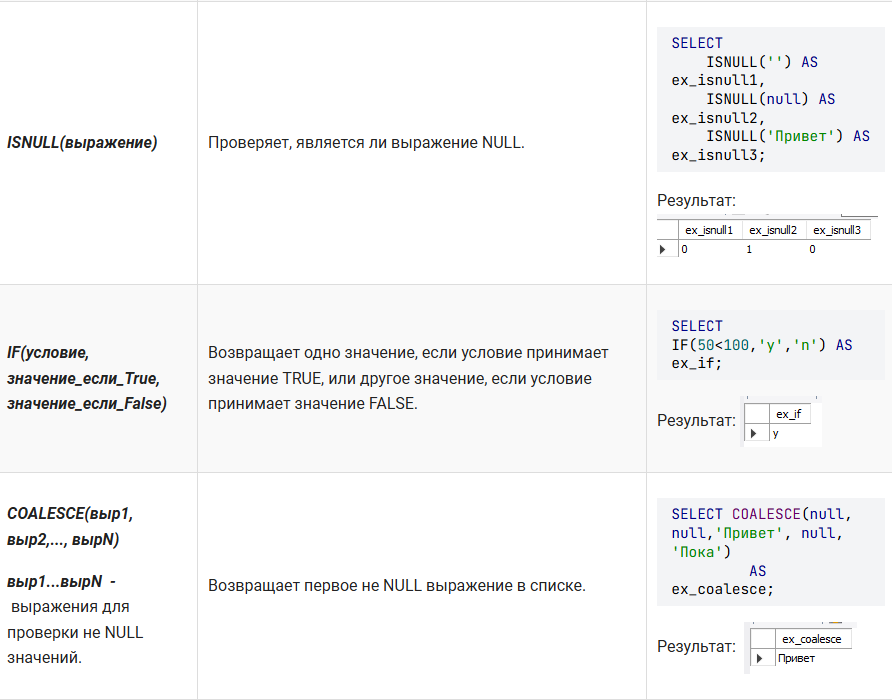

## COALESCE

**COALESCE** — это стандартная SQL-функция, которая возвращает **первое ненулевое значение** из списка аргументов. Она незаменима для обработки `NULL` и работы с необязательными данными. Вот всё, что нужно знать о её применении.

**Базовый синтаксис**
```sql
COALESCE(выражение1, выражение2, ..., выражениеN)
```
- Проверяет аргументы **слева направо**.
- Возвращает **первое значение, не равное NULL**.
- Если все аргументы `NULL` → возвращает `NULL`.

---

**Замена NULL на дефолтное значение**

**Ситуация:** В данных есть пропуски, но для расчётов нужен "заглушка"-значение.  
**Пример:**  
```sql
-- Заменить NULL в поле bonus на 0
SELECT
    employee_id,
    salary,
    COALESCE(bonus, 0) AS bonus  -- Если bonus = NULL → 0
FROM employees;
```

**Почему это важно?**  
Без `COALESCE` выражение `salary + bonus` для записей с `NULL` в `bonus` вернёт `NULL` (арифметика с `NULL` даёт `NULL`).

**Обработка нескольких источников данных**
**Ситуация:** Есть несколько полей с контактами, нужно выбрать первый доступный вариант.  
**Пример:**  
```sql
-- Вернуть первый доступный контакт: phone → email → 'No contact'
SELECT
    name,
    COALESCE(phone, email, 'No contact info') AS contact
FROM customers;
```

**Как работает:**  
| name   | phone     | email           | Результат                |
|--------|-----------|-----------------|--------------------------|
| Иван   | 123-456   | ivan@mail.com   | 123-456                  |
| Мария  | NULL      | maria@mail.com  | maria@mail.com           |
| Петр   | NULL      | NULL            | No contact info          |


**Использование с агрегатными функциями**

**Ситуация:** Нужно обработать `NULL` в результатах группировки.  
**Пример:**  
```sql
-- Для менеджеров без заказов показать 0 вместо NULL
SELECT
    manager_id,
    COALESCE(COUNT(order_id), 0) AS orders_count  -- Избыточно! COUNT не возвращает NULL
FROM orders
GROUP BY manager_id;
```

**Важное уточнение:**  
- `COUNT(*)` и `COUNT(столбец)` **никогда не возвращают `NULL`** (если нет строк в группе → 0).  
- `COALESCE` здесь избыточен, но полезен для других агрегатов:  
  ```sql
  -- AVG может вернуть NULL, если все значения NULL
  SELECT
      dept_id,
      COALESCE(AVG(salary), 0) AS avg_salary  -- Если в департаменте нет сотрудников
  FROM employees
  GROUP BY dept_id;
  ```

**В условиях фильтрации (`WHERE`/`HAVING`)**

**Ситуация:** Фильтрация по полям, которые могут содержать `NULL`.  
**Пример:**  
```sql
-- Найти клиентов без указания региона (NULL или пустая строка)
SELECT *
FROM customers
WHERE COALESCE(region, '') = '';
```

**Сравнение с `IS NULL`:**  
```sql
-- Эквивалентный запрос через OR
WHERE region IS NULL OR region = ''
```
→ `COALESCE` делает код короче и читаемее.


**Особенности и нюансы**

**Тип данных результата**
- Тип возвращаемого значения определяется **первым ненулевым аргументом**.  
- Все последующие аргументы **приводятся к этому типу** (если возможно).

**Пример ошибки:**  
```sql
-- Ошибка! Нельзя смешивать типы без неявного преобразования
SELECT COALESCE(NULL, 'text', 123);
-- В некоторых СУБД: ошибка приведения типов
-- В других: 'text' (как первый ненулевой)
```

**Решение:** Явно приводите типы:  
```sql
SELECT COALESCE(NULL, CAST(123 AS VARCHAR), 'text');
```

---

**Производительность**
- **Не вычисляет "лишние" аргументы.**  
  Если первый аргумент не `NULL`, остальные игнорируются:  
  ```sql
  COALESCE(expensive_function(), cheap_function()) -- expensive_function() не вызывается, если первый аргумент не NULL
  ```

- **Всегда быстрее, чем `CASE`:**  
  ```sql
  -- COALESCE
  COALESCE(a, b, c)
  
  -- Эквивалент через CASE
  CASE WHEN a IS NOT NULL THEN a
       WHEN b IS NOT NULL THEN b
       ELSE c END
  ```
  → Оптимизатор часто преобразует `COALESCE` в оптимизированный `CASE`.


**Практические примеры из реальных задач**

**Обработка NULL в расчётах**
```sql
-- Безопасное вычисление среднего чека (учитывает NULL)
SELECT
    customer_id,
    SUM(amount) / NULLIF(COUNT(order_id), 0) AS avg_check,
    COALESCE(SUM(amount) / NULLIF(COUNT(order_id), 0), 0) AS safe_avg_check
FROM orders
GROUP BY customer_id;
```
→ `COALESCE` защищает от `NULL` в итоговом результате.



**CTE с обработкой NULL**
```sql
WITH order_stats AS (
    SELECT
        customer_id,
        COUNT(*) AS total_orders,
        AVG(amount) AS avg_amount
    FROM orders
    GROUP BY customer_id
)
SELECT
    c.name,
    COALESCE(os.total_orders, 0) AS orders,
    COALESCE(os.avg_amount, 0) AS avg_check
FROM customers c
LEFT JOIN order_stats os ON c.id = os.customer_id;
```
→ Заменяет `NULL` у клиентов без заказов на 0.

**Работа с датами**
```sql
-- Показать дату последнего заказа или дату регистрации
SELECT
    customer_id,
    COALESCE(
        (SELECT MAX(order_date) FROM orders o WHERE o.customer_id = c.id),
        registration_date
    ) AS last_activity
FROM customers c;
```
→ Если заказов нет, использует дату регистрации.

**Распространённые ошибки**

**Смешение типов данных**
```sql
-- Ошибка в PostgreSQL: "text and integer cannot be matched"
SELECT COALESCE(NULL, 'N/A', 0);
```
**Исправление:**  
```sql
SELECT COALESCE(NULL, 'N/A', CAST(0 AS VARCHAR));
```

**Избыточное использование**
```sql
-- COUNT никогда не возвращает NULL!
SELECT COALESCE(COUNT(*), 0) FROM table;
```
**Правильно:**  
```sql
SELECT COUNT(*) FROM table; -- Результат всегда число (0+)
```

**Непонимание порядка аргументов**
```sql
-- Вернёт 'N/A', даже если discount = 0 (что может быть валидным значением)
COALESCE(discount, 'N/A')
```
**Решение:**  
Используйте `NULLIF`, если 0 нужно считать "пустым":  
```sql
COALESCE(NULLIF(discount, 0), 'N/A')
```

**Сравнение с другими методами обработки NULL**

| Метод                     | Пример                          | Когда использовать                     |
|---------------------------|---------------------------------|----------------------------------------|
| **COALESCE**              | `COALESCE(phone, email, 'N/A')` | Нужно несколько вариантов замены      |
| **CASE**                  | `CASE WHEN a IS NULL THEN b ELSE a END` | Сложные условия (не только NULL) |
| **ISNULL / NVL / IFNULL** | `ISNULL(phone, 'N/A')`          | Если работаете только с одной СУБД    |
| **NULLIF**                | `NULLIF(discount, 0)`           | Чтобы превратить 0 в NULL             |

---

**Частые вопросы**



✅ **Итог: когда использовать COALESCE**

Используйте **COALESCE**, когда:
- Нужно заменить `NULL` на дефолтное значение (0, пустая строка, заглушка).
- Есть несколько источников данных, и нужно взять первый доступный.
- Работаете с кроссплатформенными запросами (лучше аналогов).
- Хотите упростить условия вида `WHERE a IS NULL OR a = ...`.

**Не используйте**, если:
- Обрабатываете результаты `COUNT` (они никогда не `NULL`).
- Нужны сложные условия (используйте `CASE`).
- Столкнулись с проблемами типизации (явно приводите типы).

> **Золотое правило:**  
> *«Если в вашем запросе есть `NULL`, а вам нужно "нечто вместо него" — COALESCE ваш друг.  
> Если нужно проверить несколько условий (не только NULL) — переходите к CASE».*

## IF, CASE

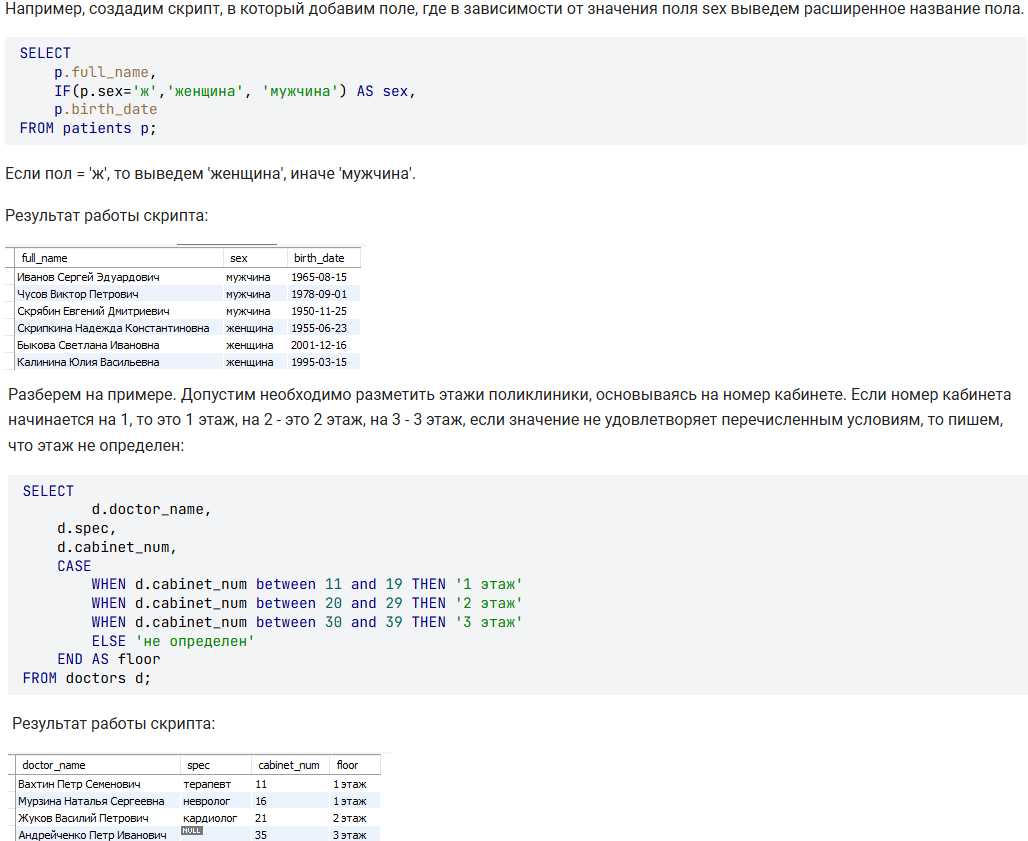

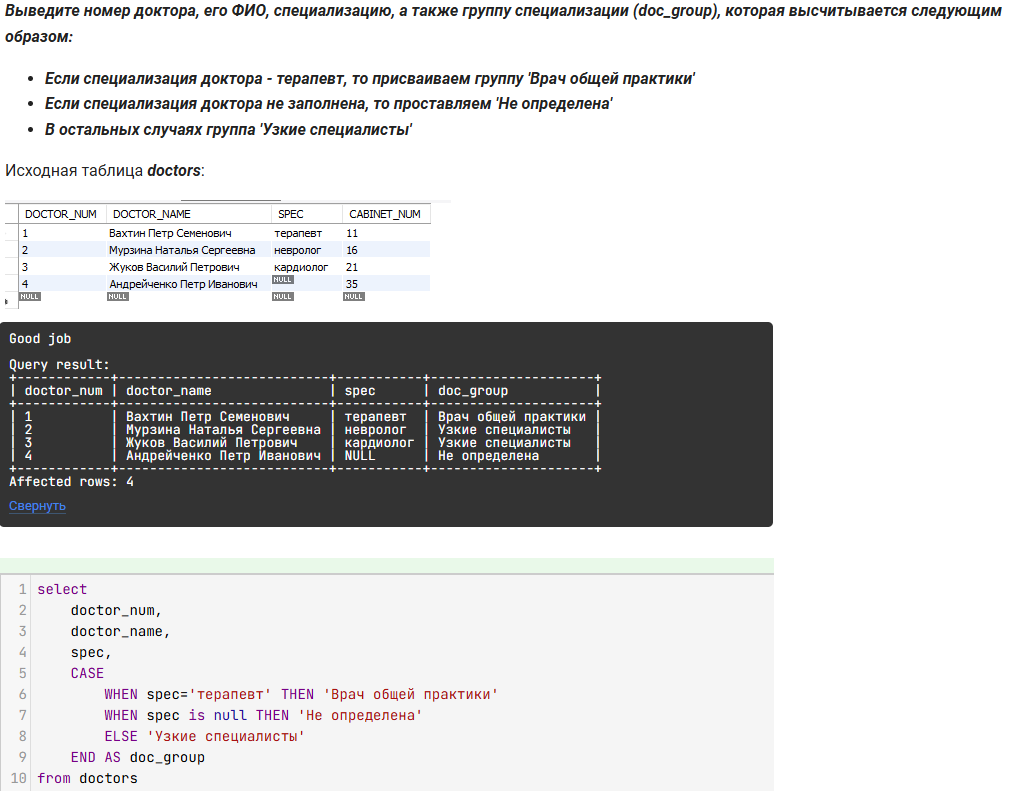

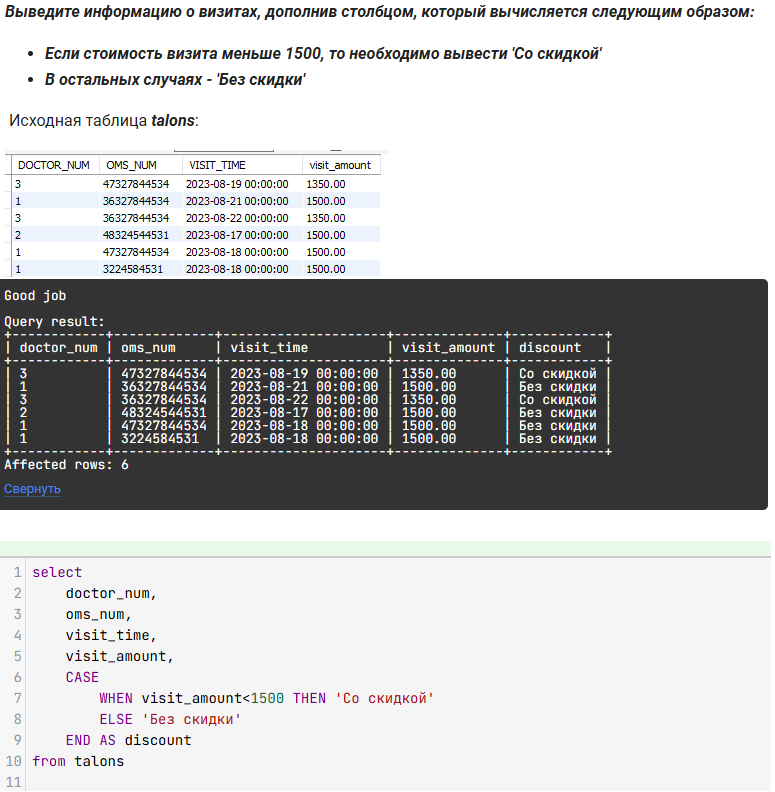

## Строковые

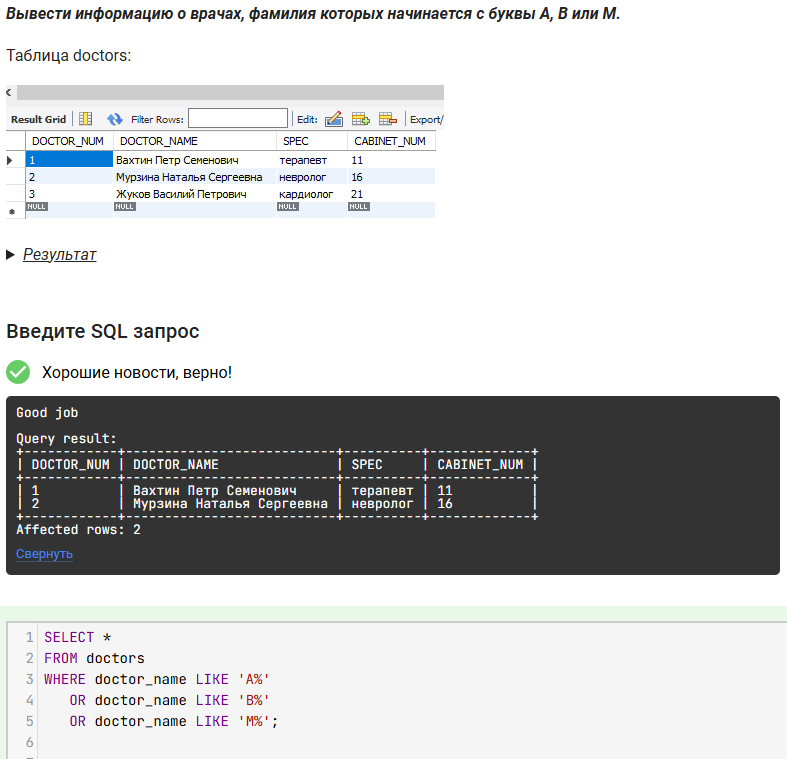

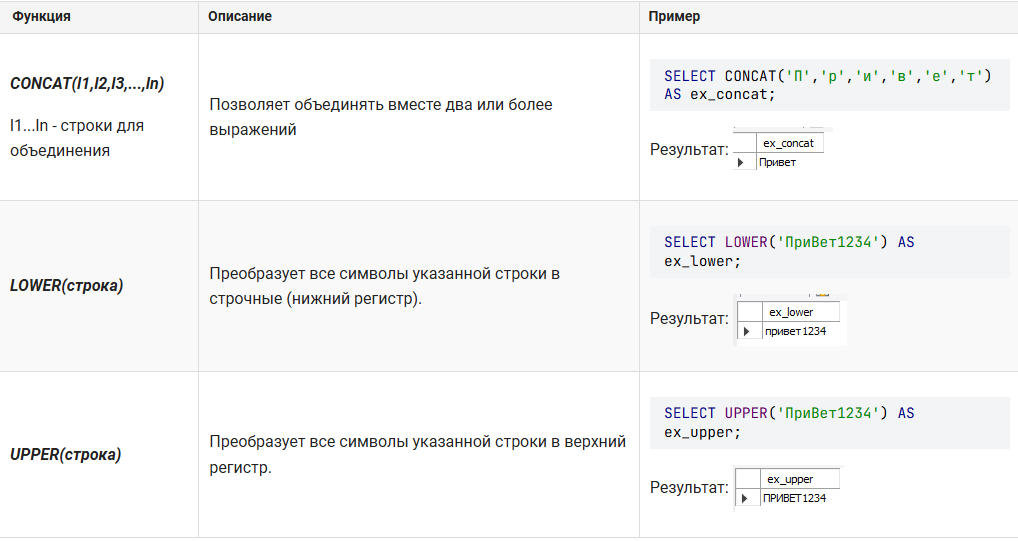

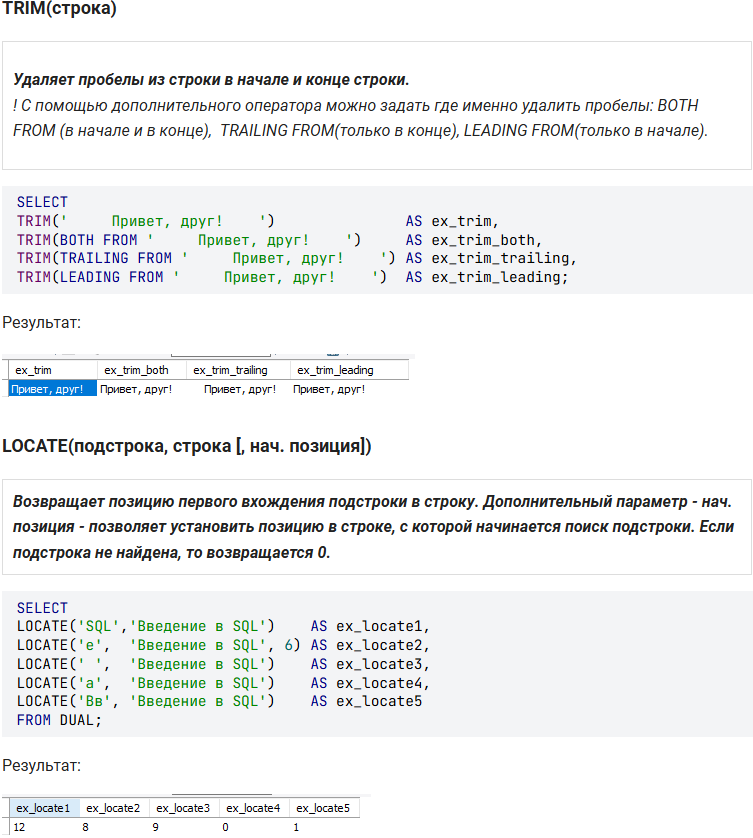

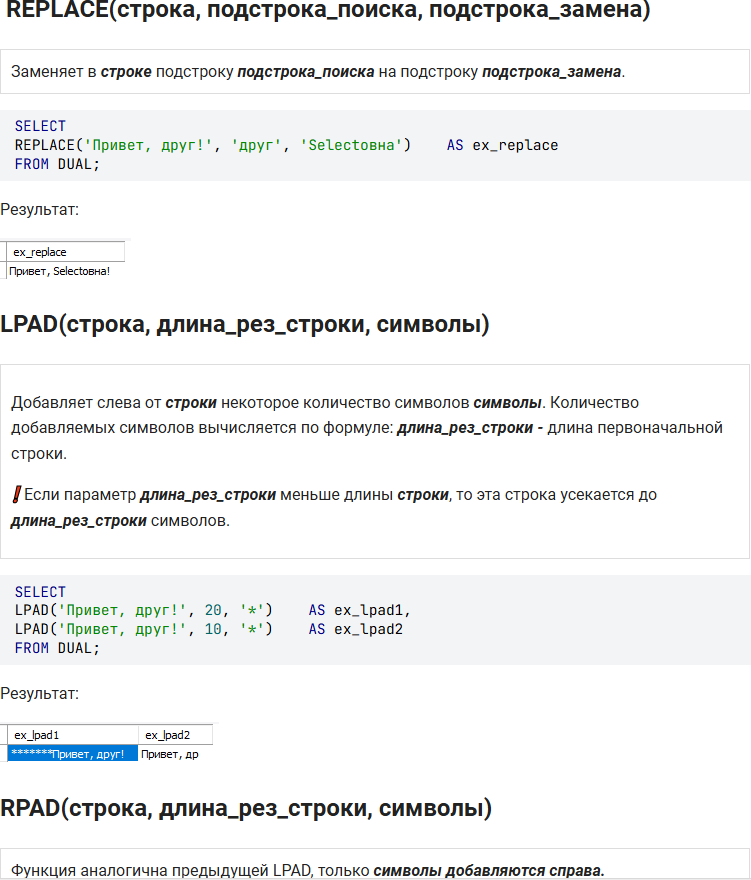

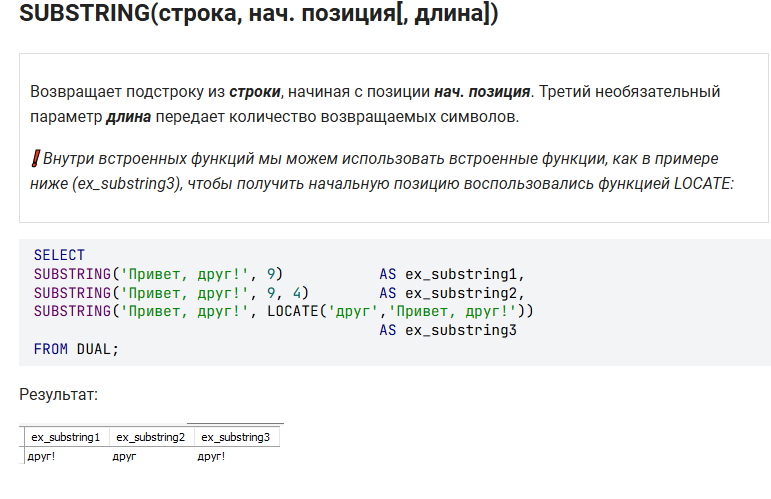

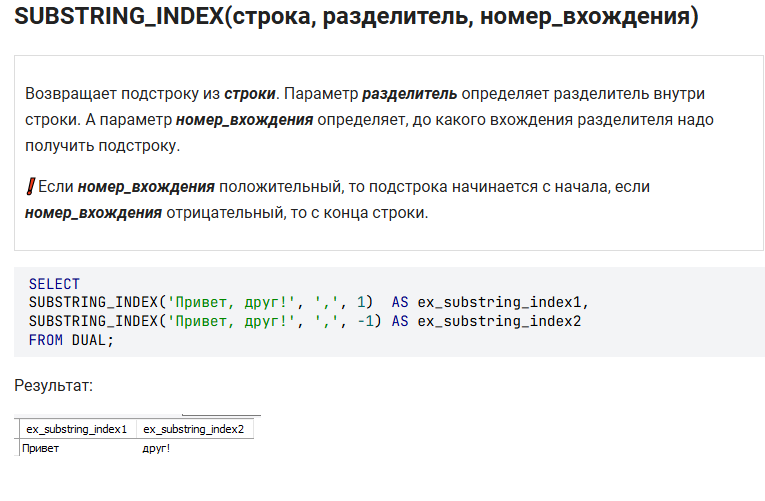

## Числовые

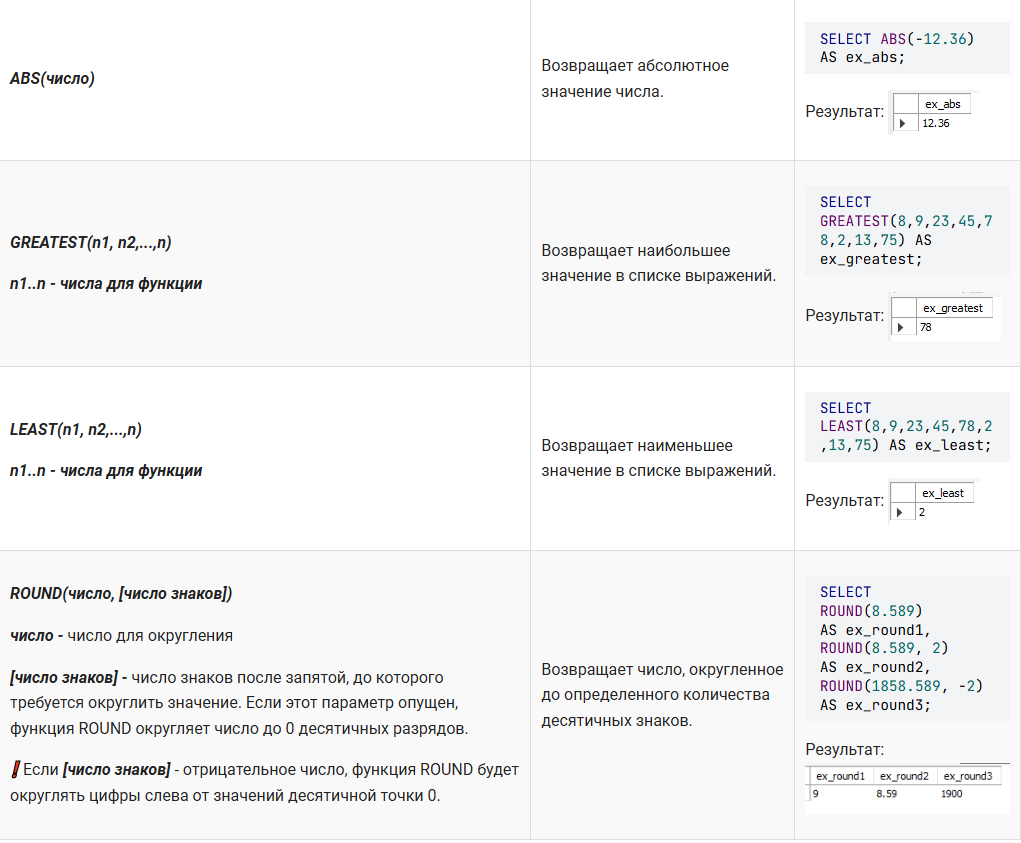

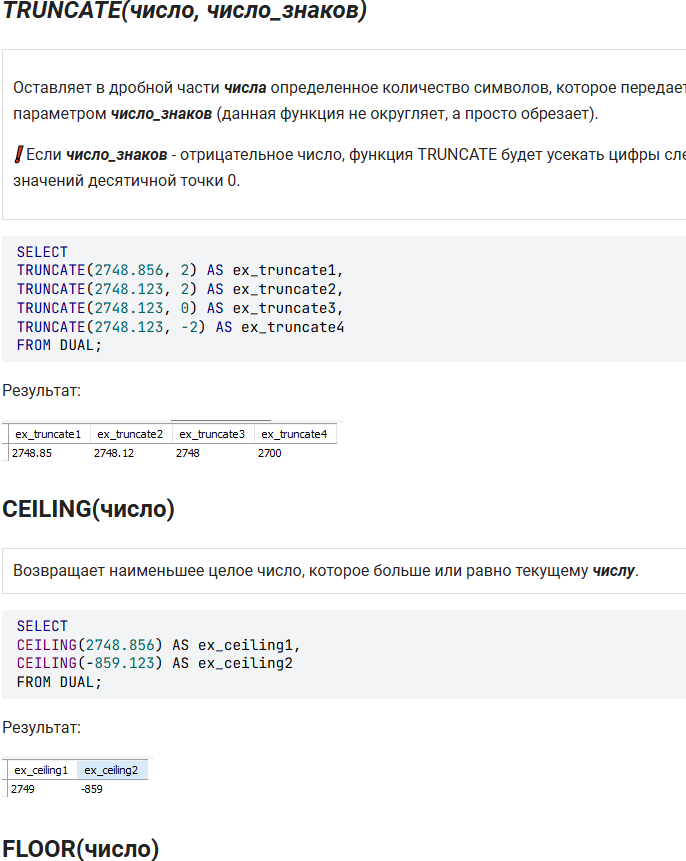

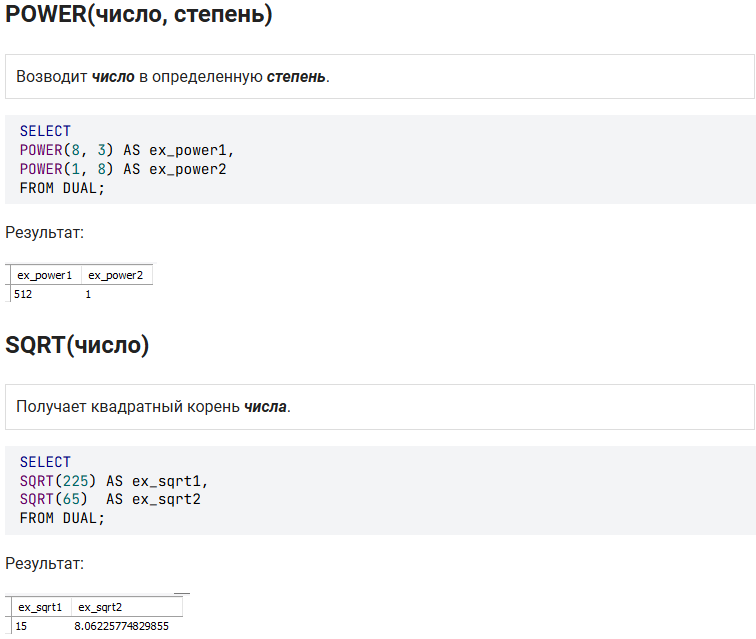

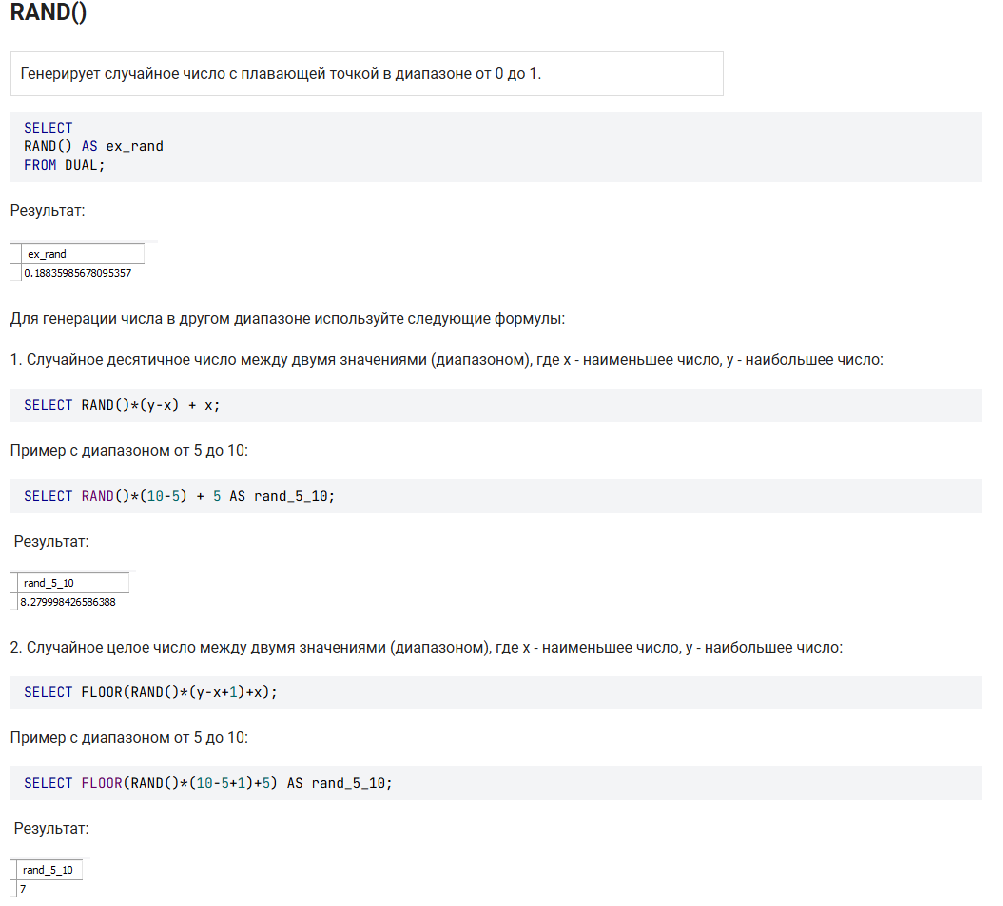

## **Date**

```sql
-- Эти выражения РАВНЫ и возвращают одну дату
SELECT
    DATE '2013-10-01' as date1,
    TO_DATE('01.10.2013', 'DD.MM.YYYY') as date2,
    TO_DATE('01.10.2013', 'DD.MM.YYYY') = DATE '2013-10-01' as are_equal;   
```

date1       | date2       | are_equal
------------|-------------|----------
2013-10-01  | 2013-10-01  | true

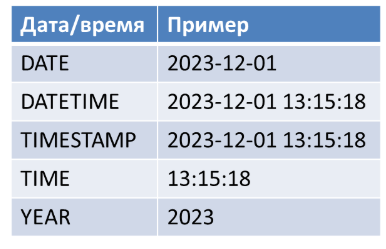

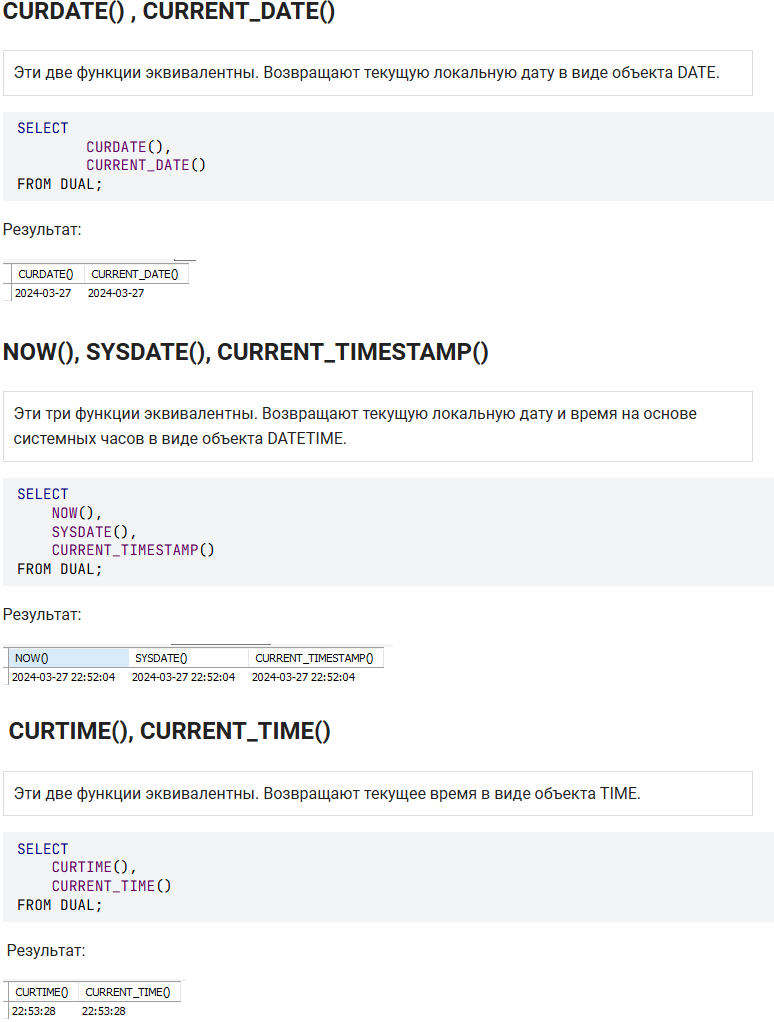

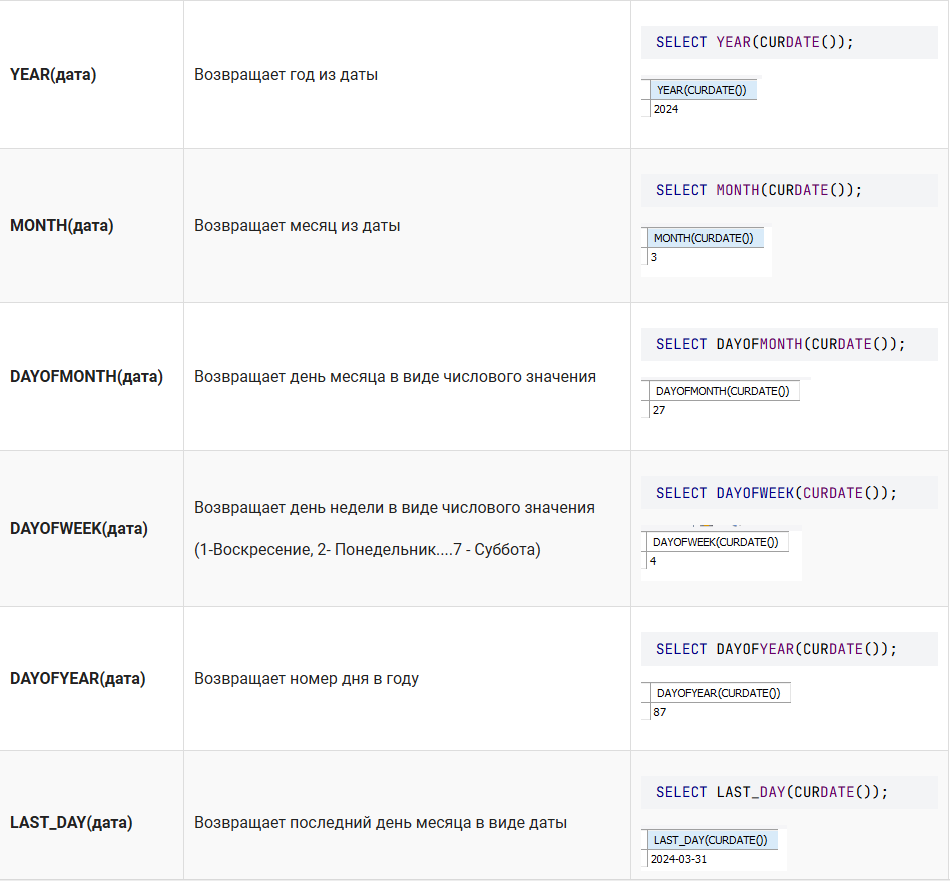

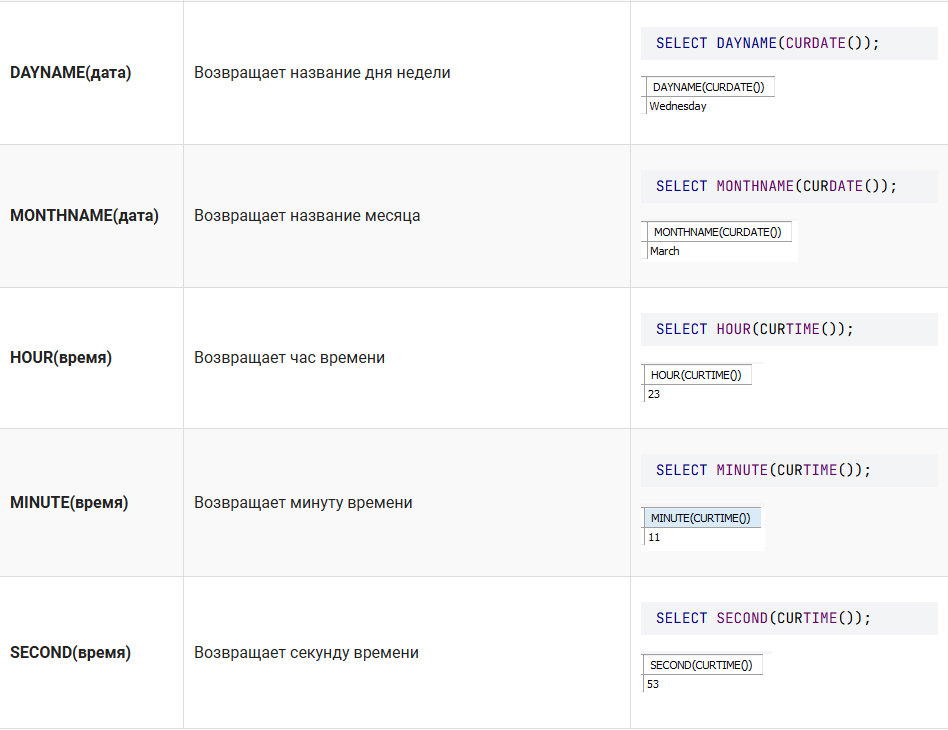

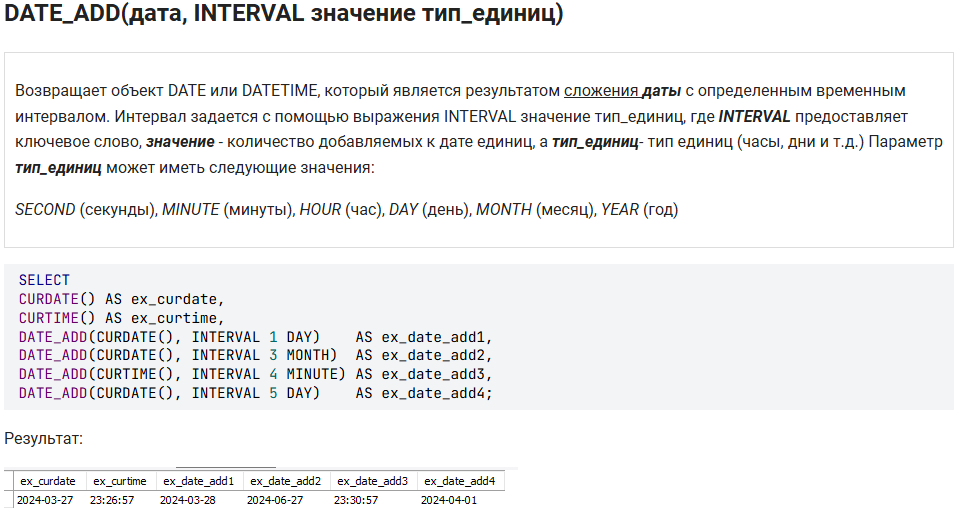

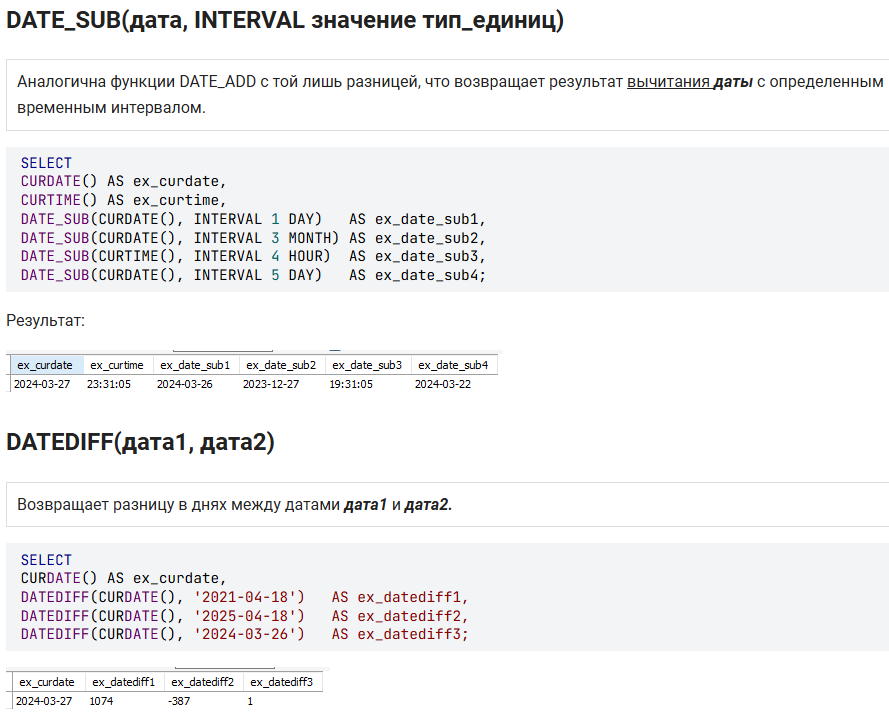

## **Count(*)**

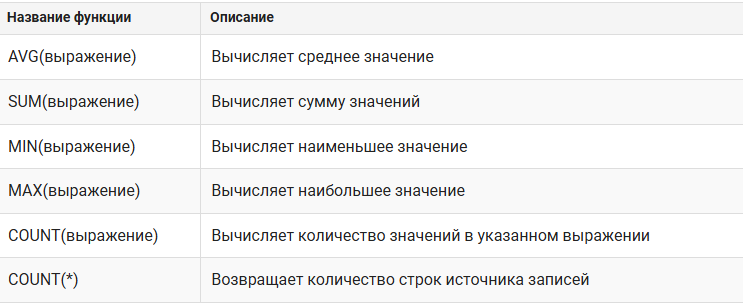

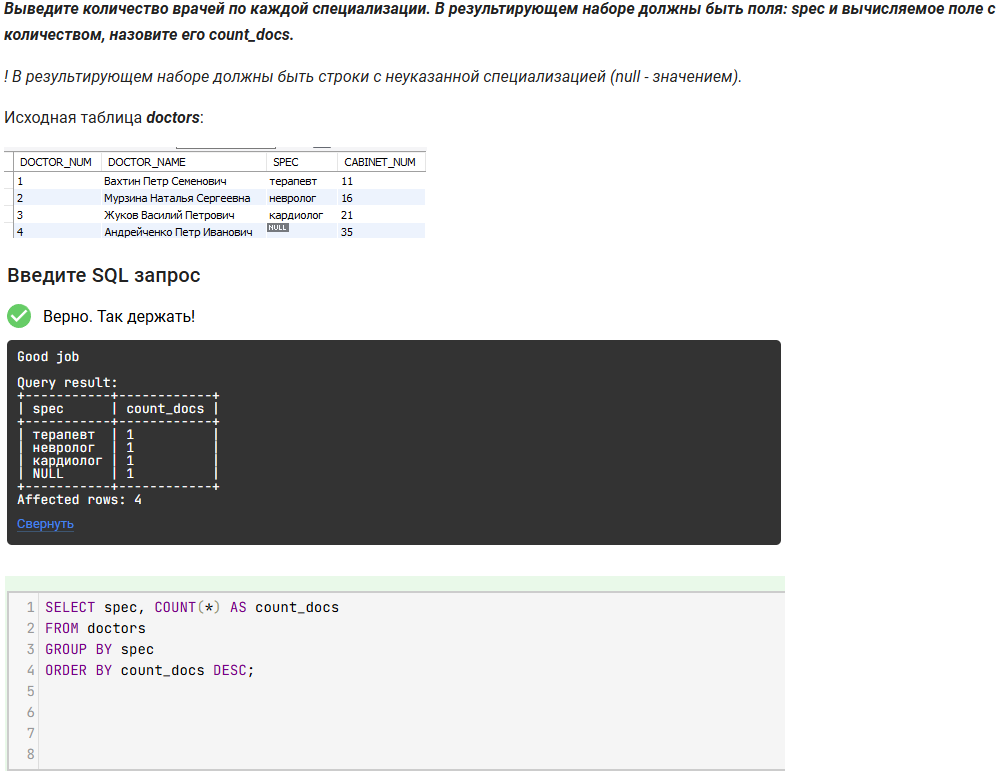

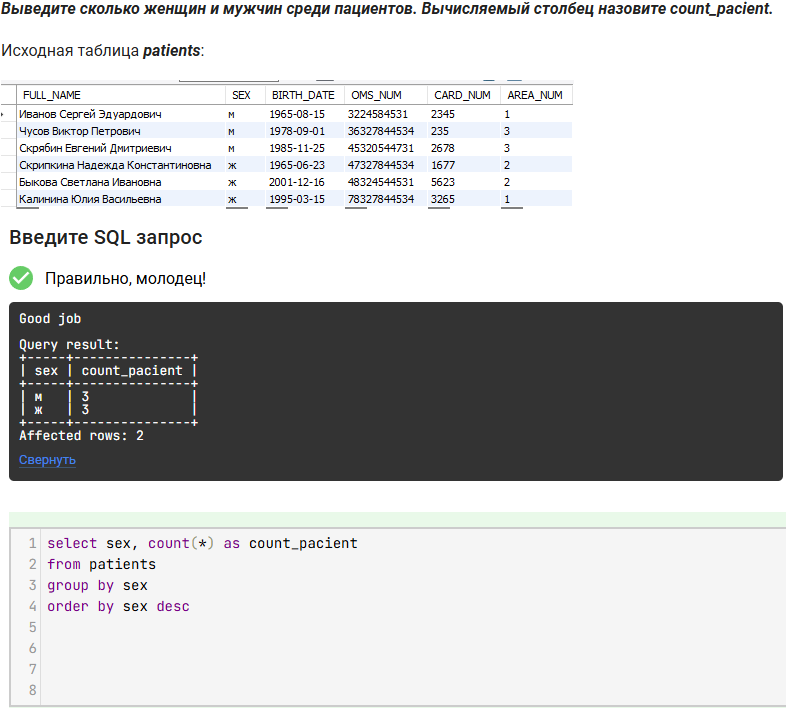

## **Having**

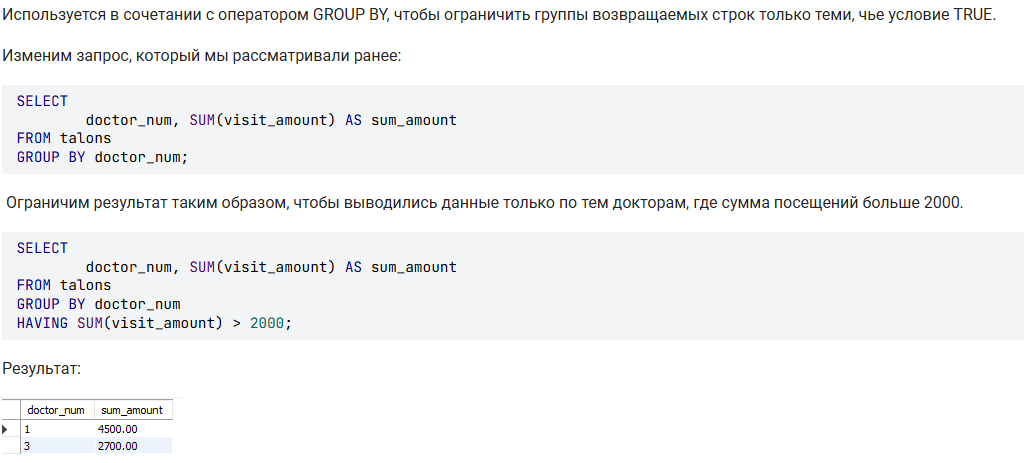

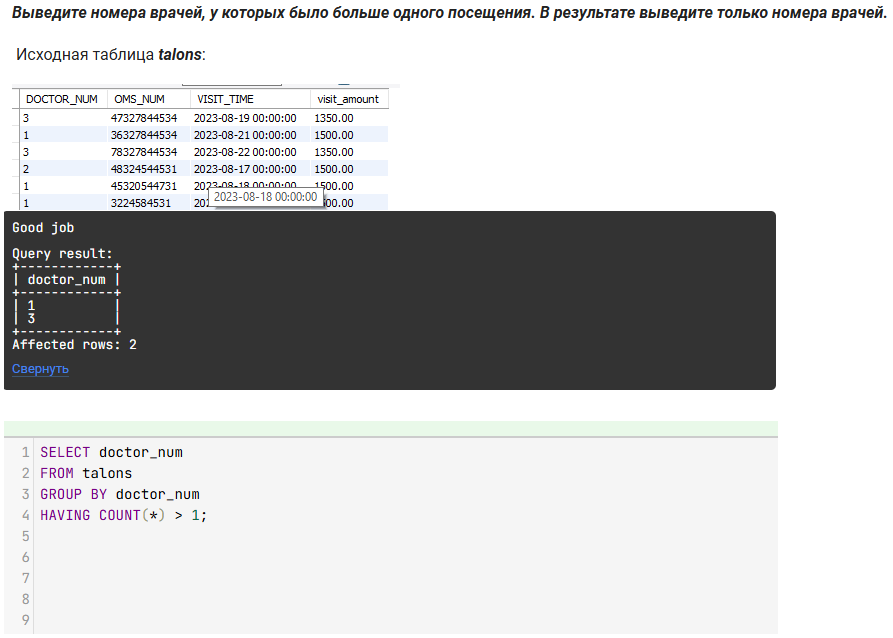

## **Having**

это ключевое слово, используемое для фильтрации групп строк после применения операции **GROUP BY**. Оно похоже на **WHERE**, но применяется именно к группам, а не к отдельным строкам.

**Основное назначение HAVING**

HAVING используется, когда нужно отфильтровать результаты агрегатных функций (например, `COUNT`, `SUM`, `AVG`, `MAX`, `MIN`), которые нельзя использовать в условии `WHERE`.


**Синтаксис**
```sql
SELECT столбцы
FROM таблица
GROUP BY столбец(ы)
HAVING условие;
```


**Пример использования**

Предположим, есть таблица `employees` с колонками `department_id` и `salary`. Нужно найти отделы, где **средняя зарплата сотрудников больше 5000**:
```sql
SELECT department_id, AVG(salary) AS avg_salary
FROM employees
GROUP BY department_id
HAVING AVG(salary) > 5000;
```

**Что происходит:**
1. Строки группируются по `department_id`.
2. Для каждой группы вычисляется средняя зарплата (`AVG(salary)`).
3. HAVING оставляет только те группы, где средняя зарплата больше 5000.


**HAVING vs WHERE**

| **WHERE** | **HAVING** |
|----------|------------|
| Фильтрует **отдельные строки** до группировки. | Фильтрует **группы** после группировки. |
| Нельзя использовать агрегатные функции. | Можно использовать агрегатные функции. |
| Пример: `WHERE salary > 5000` | Пример: `HAVING AVG(salary) > 5000` |


**Когда использовать HAVING?**
- Когда условие фильтрации зависит от результата агрегатной функции.
- Например, найти клиентов, у которых **сумма заказов за год превышает X**:
  ```sql
  SELECT customer_id, SUM(order_amount) AS total
  FROM orders
  GROUP BY customer_id
  HAVING SUM(order_amount) > 10000;
  ```


**Важные замечания**
1. **HAVING без GROUP BY**:
   - В некоторых СУБД (например, MySQL) `HAVING` может работать без `GROUP BY`, но это нестандартно и не рекомендуется.
   - Лучше всегда использовать `GROUP BY` с `HAVING`.

2. **Производительность**:
   - Используйте `WHERE` для фильтрации до группировки, чтобы уменьшить объем данных, с которыми работает `GROUP BY`.

3. **Сложные условия**:
   - В `HAVING` можно использовать логические операторы (`AND`, `OR`, `NOT`) и подзапросы.



**Пример с несколькими условиями**

Найти отделы, где **более 10 сотрудников** и **минимальная зарплата в отделе > 3000**:
```sql
SELECT department_id
FROM employees
GROUP BY department_id
HAVING COUNT(*) > 10 AND MIN(salary) > 3000;
```



**Итог**
- **HAVING** — это инструмент для фильтрации групп после агрегации.
- Используется с `GROUP BY` и агрегатными функциями.
- Позволяет решать задачи, где нужны условия на результаты вычислений (например, "показать только те группы, где сумма больше X").

Если остались вопросы — спрашивайте! 😊

## **EXTRACT**
**Что делает:** Извлекает компонент из даты/времени.

**Синтаксис:**  
`EXTRACT(компонент FROM дата_время)`

**Популярные компоненты:**
- `YEAR` → год (2023)
- `MONTH` → месяц (1-12)
- `DAY` → день месяца (1-31)
- `HOUR` → час (0-23)
- `MINUTE` → минуты (0-59)
- `SECOND` → секунды
- `WEEK` → номер недели
- `QUARTER` → квартал (1-4)

**Примеры:**
```sql
EXTRACT(YEAR FROM CURRENT_DATE)     → 2023
EXTRACT(MONTH FROM CURRENT_DATE)    → 10
EXTRACT(DAY FROM CURRENT_DATE)      → 15
EXTRACT(HOUR FROM CURRENT_TIMESTAMP) → 14
```

**Особенности:**
- Возвращает целое число
- Работает с типами DATE, TIMESTAMP
- Поддерживается в PostgreSQL, Oracle, SQL Server, MySQL

**Альтернатива в MySQL:**  
`YEAR(date)`, `MONTH(date)`, `DAY(date)` и т.д.

Используйте для извлечения отдельных частей даты без преобразования в строку.

## `date_trunc`

`DATE '2016-01-01' = TO_DATE('01.01.2016', 'DD.MM.YYYY')`


Выражение: **`date_trunc('month', TO_DATE('01.01.2016', 'DD.MM.YYYY'))`**

Это **вычислительное выражение**, которое **создает конкретную дату**:

```sql
date_trunc('month', TO_DATE('01.01.2016', 'DD.MM.YYYY'))
```

**Как это работает:**
1. `TO_DATE('01.01.2016', 'DD.MM.YYYY')` преобразует строку в дату: `2016-01-01`
2. `date_trunc('month', ...)` обрезает дату до начала месяца

**Результат:** `2016-01-01 00:00:00` (timestamp)

**Где используется:**
- В `SELECT` для создания столбца с фиксированной датой
- В условиях `WHERE` как константа для сравнения
- Для генерации временных рядов
- В арифметических операциях с датами

**Пример использования:**
```sql
-- Генерация даты начала января 2016
SELECT date_trunc('month', TO_DATE('01.01.2016', 'DD.MM.YYYY'));

-- Использование в расчетах
SELECT date_trunc('month', TO_DATE('01.01.2016', 'DD.MM.YYYY')) + INTERVAL '1 month';
-- Вернет 2016-02-01
```





Выражение: **`date_trunc('MONTH', ORDER_DATE) = DATE '2016-01-01'`**

Это **логическое условие фильтрации**, которое **проверяет принадлежность даты к периоду**:

```sql
date_trunc('MONTH', ORDER_DATE) = DATE '2016-01-01'
```

**Как это работает:**
1. `date_trunc('MONTH', ORDER_DATE)` обрезает каждую дату из поля ORDER_DATE до начала месяца
2. Результат сравнивается с `DATE '2016-01-01'`

**Результат:** `TRUE` или `FALSE` (логическое значение)

**Что фильтрует:**
- ✅ Включает: все даты с 2016-01-01 по 2016-01-31 включительно
- ❌ Не включает:
  - Все даты до 2016-01-01 (например, 2015-12-31)
  - Все даты начиная с 2016-02-01

**Где используется:**
- В `WHERE` для фильтрации данных за январь 2016
- В `HAVING` для фильтрации сгруппированных данных
- В условиях `CASE` для классификации данных по периодам

**Пример использования:**
```sql
-- Фильтрация продаж за январь 2016
SELECT *
FROM orders
WHERE date_trunc('MONTH', ORDER_DATE) = DATE '2016-01-01';

-- Эквивалентная запись
SELECT *
FROM orders
WHERE ORDER_DATE >= DATE '2016-01-01' AND ORDER_DATE < DATE '2016-02-01';
```


**Важное замечание**

Второе выражение **НЕ** обрезает данные до 01.02.2016, как могло показаться. Оно **ТОЛЬКО** выбирает данные за январь 2016 (с 01.01.2016 по 31.01.2016).

Если вам нужно выбрать все данные **до 01.02.2016**, используйте:
```sql
WHERE ORDER_DATE < DATE '2016-02-01'
```

**✅ Итог**

- **`date_trunc('month', TO_DATE('01.01.2016', 'DD.MM.YYYY'))`** — это **константа**, представляющая собой первый день января 2016 года. Это инструмент для **создания даты**.
  
- **`date_trunc('MONTH', ORDER_DATE) = DATE '2016-01-01'`** — это **условие фильтрации**, которое отбирает **только январь 2016 года**. Это инструмент для **выбора данных за конкретный месяц**.

Первое выражение используется для **определения точки отсчета**, второе — для **фильтрации данных по периоду**. Это принципиально разные операции, решающие разные задачи в SQL.

##  `generate_series`



```sql
all_months(sale_month) as (
    select generate_series(
        date_trunc('month', TO_DATE('01.10.2013', 'DD.MM.YYYY')),
        TO_DATE('01.12.2014', 'DD.MM.YYYY'), '1 month')::date as month)
```

**1. `TO_DATE('01.10.2013', 'DD.MM.YYYY')`**

- **Что делает:** Преобразует строку в объект даты
- **Как работает:**
  - `'01.10.2013'` - строка с датой в формате "день.месяц.год"
  - `'DD.MM.YYYY'` - шаблон, который указывает:
    - `DD` = день (2 цифры)
    - `MM` = месяц (2 цифры)
    - `YYYY` = год (4 цифры)
- **Результат:** Объект даты `2013-10-01` (1 октября 2013 года)

**2. `date_trunc('month', TO_DATE('01.10.2013', 'DD.MM.YYYY'))`**

- **Что делает:** "Обрезает" дату до начала указанного периода
- **Как работает:**
  - `'month'` - указывает, что нужно обрезать до начала месяца
  - Для даты `2013-10-01` результат будет `2013-10-01` (уже начало месяца)
  - Если бы дата была `2013-10-15`, результат был бы `2013-10-01`
- **Зачем нужно:** Гарантирует, что начальная точка - первый день месяца

**3. `generate_series(начало, конец, шаг)`**

- **Что делает:** Генерирует последовательность значений
- **В нашем случае:**
  - **Начало:** `date_trunc('month', TO_DATE('01.10.2013', 'DD.MM.YYYY'))` = `2013-10-01`
  - **Конец:** `TO_DATE('01.12.2014', 'DD.MM.YYYY')` = `2014-12-01`
  - **Шаг:** `'1 month'` - увеличивать дату на 1 месяц за раз
- **Результат:** Последовательность дат:
  ```
  2013-10-01
  2013-11-01
  2013-12-01
  2014-01-01
  ...
  2014-11-01
  2014-12-01
  ```

**4. `::date as month`**

- **`::date`** - оператор приведения типов в PostgreSQL
  - Преобразует результат функции `generate_series` в тип `DATE`
  - Без этого преобразования тип может быть `timestamp` (с временем)
- **`as month`** - дает алиас (псевдоним) столбцу - "month"

**5. `all_months(sale_month) as (...)`**

- Это определение CTE (Common Table Expression)
- `all_months` - имя CTE
- `(sale_month)` - явное указание имени столбца в CTE
- Вместо `as month` в CTE можно было бы написать `as sale_month`

**Как это работает в целом**

Этот код создает **таблицу с одним столбцом**, содержащим **первый день каждого месяца** от октября 2013 года по декабрь 2014 года:

| sale_month |
|------------|
| 2013-10-01 |
| 2013-11-01 |
| 2013-12-01 |
| 2014-01-01 |
| ...        |
| 2014-11-01 |
| 2014-12-01 |

**Зачем это нужно**

Такой подход часто используется для:
1. **Гарантии наличия всех месяцев в результате**, даже если в исходных данных за какой-то месяц нет записей
2. **Заполнения пропусков в данных** (например, месяцев без продаж)
3. **Построения временных рядов** с фиксированным интервалом

**Альтернативная запись (более современная)**

В современных версиях PostgreSQL можно упростить этот запрос:

```sql
all_months AS (
    SELECT
        generate_series(
            '2013-10-01'::date,
            '2014-12-01'::date,
            '1 month'
        )::date AS sale_month
)
```

Или даже так:

```sql
all_months AS (
    SELECT
        generate_series(
            DATE '2013-10-01',
            DATE '2014-12-01',
            INTERVAL '1 month'
        )::date AS sale_month
)
```

**Важные замечания**

1. **Функция `generate_series` - это специфика PostgreSQL**  
   В других СУБД (MySQL, SQL Server) аналогичные функции работают по-другому.

2. **Точность шага**  
   `'1 month'` гарантирует, что мы получим первый день каждого месяца, даже если в месяце разное количество дней.

3. **Преобразование `::date`**  
   Важно для удаления времени из timestamp, чтобы даты корректно сравнивались.

4. **Включает обе границы**  
   Последовательность включает как начальную дату (`2013-10-01`), так и конечную (`2014-12-01`).

Этот подход является стандартным приёмом для работы с временными рядами в SQL, особенно когда нужно убедиться, что в результате присутствуют все периоды, даже если данные за них отсутствуют.

## **Power**

POWER(x, y) - SQL-функция, которая возвращает x в степени y

## **NULLIF**

Сравнивает два значения и возвращает **NULL при их совпадении**.

**Синтаксис:**  
`NULLIF(выражение_1, выражение_2)`

**Как работает:**
- Если `выражение_1 = выражение_2` → возвращает **NULL**
- Если `выражение_1 ≠ выражение_2` → возвращает **выражение_1**

**Примеры:**
```sql
NULLIF(5, 5)       → NULL
NULLIF(5, 3)       → 5
NULLIF('text', 'text') → NULL
NULLIF('text', 'other') → 'text'
```

**Основные применения:**
1. **Предотвращение деления на ноль:**
   ```sql
   total_sales / NULLIF(total_orders, 0)
   ```

2. **Обработка "заглушек":**
   ```sql
   NULLIF(phone, 'N/A')  -- вернет NULL вместо 'N/A'
   ```

3. **Безопасная конкатенация:**
   ```sql
   'Phone: ' || NULLIF(phone, 'N/A')
   ```

**Важно:**
- Не работает с NULL (сравнение с NULL всегда дает UNKNOWN)
- Требует совместимых типов данных в обоих выражениях

Это компактная альтернатива простому CASE-выражению для обработки специфических значений.

## **INTERVAL, DATEDIFF**
`INTERVAL` — это **тип данных в SQL**, который представляет собой **промежуток времени** (разницу между двумя моментами времени). Это мощный инструмент для работы с датами и временем, особенно при анализе временных рядов, как в ваших запросах с расчетом продаж и премий.


`INTERVAL` представляет собой **размер временного промежутка** без привязки к конкретной точке во времени:
- `INTERVAL '1 day'` — один день
- `INTERVAL '3 months'` — три месяца
- `INTERVAL '2 hours 30 minutes'` — два часа тридцать минут

**Ключевое свойство:**  
`INTERVAL` позволяет **добавлять или вычитать временные промежутки из дат**, что критически важно для временных анализов.



**Базовый синтаксис**
```sql
INTERVAL 'значение единица_времени'
```
- **Значение** — число (может быть дробным)
- **Единица времени** — год, месяц, день, час и т.д.

**Примеры**
```sql
INTERVAL '1 day'
INTERVAL '3 months'
INTERVAL '2 hours 30 minutes'
INTERVAL '90 days'
INTERVAL '0.5 hours'  -- 30 минут
```

**Основные применения INTERVAL**

1. **Сдвиг даты на определенный период**
```sql
-- Текущая дата плюс 7 дней
SELECT CURRENT_DATE + INTERVAL '7 days';

-- Дата 3 месяца назад
SELECT CURRENT_DATE - INTERVAL '3 months';
```

2. **Фильтрация данных за период**
```sql
-- Продажи за последние 30 дней
SELECT * FROM sales
WHERE sale_date >= CURRENT_DATE - INTERVAL '30 days';

-- Продажи между 3 и 1 месяцем назад
SELECT * FROM sales
WHERE sale_date BETWEEN CURRENT_DATE - INTERVAL '3 months'
                    AND CURRENT_DATE - INTERVAL '1 month';
```

3. **Группировка и анализ временных рядов**
```sql
-- Ваш пример из предыдущего запроса
SELECT
    sale_month,
    SUM(sale_amount)
FROM sales
WHERE sale_month BETWEEN am.sale_month - INTERVAL '3 months'
                     AND am.sale_month - INTERVAL '1 month'
GROUP BY sale_month;
```

4. **Генерация временных последовательностей**
```sql
-- Ваш пример с generate_series
SELECT generate_series(
    DATE '2013-10-01',
    DATE '2014-12-01',
    '1 month'
);
```

**INTERVAL vs DATEDIFF: краткое сравнение**



| Критерий | INTERVAL | DATEDIFF |
|----------|----------|----------|
| **Назначение** | Манипуляция датами (добавление/вычитание периодов) | Расчет разницы между датами |
| **Возвращает** | Дату/время | Число (разница в единицах) |
| **Синтаксис** | `CURRENT_DATE + INTERVAL '3 months'` | `DATEDIFF(month, start_date, end_date)` |
| **Пример** | Получить дату 3 месяца назад | Посчитать сколько месяцев между датами |

**Когда использовать INTERVAL**
- **Когда нужно сдвинуть дату**:
  ```sql
  -- Продажи за последние 90 дней
  WHERE sale_date >= CURRENT_DATE - INTERVAL '90 days'
  ```
- **Для генерации последовательностей**:
  ```sql
  generate_series(start_date, end_date, '1 month')
  ```
- **Для определения периодов**:
  ```sql
  WHERE sale_month BETWEEN am.sale_month - INTERVAL '3 months'
                       AND am.sale_month - INTERVAL '1 month'
  ```

**Когда использовать DATEDIFF**
- **Для расчета продолжительности**:
  ```sql
  -- Возраст клиента
  SELECT DATEDIFF(year, birth_date, CURRENT_DATE) FROM customers
  ```
- **Для фильтрации по продолжительности**:
  ```sql
  -- Клиенты, зарегистрированные больше года назад
  WHERE DATEDIFF(day, signup_date, CURRENT_DATE) > 365
  ```
- **Для анализа временных паттернов**:
  ```sql
  -- Среднее время между покупками
  SELECT AVG(DATEDIFF(day, prev_purchase, current_purchase))
  ```


**Главное правило**

> **Используйте INTERVAL, когда нужно манипулировать датами**  
> **Используйте DATEDIFF, когда нужно измерить разницу между датами**

Это не взаимозаменяемые инструменты — они решают разные задачи. В вашем запросе с премиями менеджеров INTERVAL является **правильным выбором** для определения периода анализа.

## **Конкатенация `||`**

Объединяет строки в одну.

**Синтаксис:**  
`строка_1 || строка_2 || строка_3...`

**Как работает:**
- Объединяет строки последовательно слева направо
- Автоматически преобразует числа и другие типы в строки

**Примеры:**
```sql
'Hello' || ' ' || 'World'  → 'Hello World'
'ID: ' || 123               → 'ID: 123'
```

**Важно:**
- **С NULL дает NULL:** `'Text' || NULL → NULL`
- Для обработки NULL используйте `COALESCE`:  
  `'Name: ' || COALESCE(name, 'Unknown')`

**Особенности:**
- Стандартный оператор SQL (работает в PostgreSQL, Oracle)
- В MySQL по умолчанию `||` это логическое ИЛИ (нужно включить режим PIPES_AS_CONCAT)
- В SQL Server вместо `||` используется оператор `+`



##  `CAST` vs `::`  в SQL

 Сравним `CAST` и оператор `::` для преобразования типов в SQL.

**Основные различия**

| Характеристика | `CAST` | `::` |
|----------------|--------|------|
| **Стандарт** | ANSI SQL стандарт | PostgreSQL расширение |
| **Читаемость** | Более явная и понятная | Более компактная |
| **Переносимость** | Высокая (работает везде) | Только в PostgreSQL |
| **Использование** | Функциональный стиль | Операторный стиль |



**Базовые преобразования**

```sql
-- CAST (универсальный)
SELECT CAST('123' AS INTEGER);
SELECT CAST(123.45 AS VARCHAR);
SELECT CAST('2023-12-25' AS DATE);

-- :: (только PostgreSQL)
SELECT '123'::INTEGER;
SELECT 123.45::VARCHAR;
SELECT '2023-12-25'::DATE;
```

**В сложных выражениях**

```sql
-- CAST
SELECT
    CAST(price AS DECIMAL(10,2)) * CAST(quantity AS INTEGER) as total
FROM orders;

-- ::
SELECT
    price::DECIMAL(10,2) * quantity::INTEGER as total
FROM orders;
```

**примеры сравнения**

**Пример 1: Простые преобразования**

```sql
-- Оба делают одно и то же
SELECT CAST('123.45' AS DECIMAL(8,2));  -- Стандартный
SELECT '123.45'::DECIMAL(8,2);          -- PostgreSQL
```

**Пример 2: В условиях WHERE**

```sql
-- CAST
SELECT * FROM users
WHERE CAST(created_at AS DATE) = '2023-01-01';

-- ::
SELECT * FROM users
WHERE created_at::DATE = '2023-01-01';
```

**Пример 3: С агрегатными функциями**

```sql
-- CAST
SELECT AVG(CAST(price AS DECIMAL(10,2))) as avg_price
FROM products;

-- ::
SELECT AVG(price::DECIMAL(10,2)) as avg_price
FROM products;
```

**Преимущества CAST**

**1. Кроссплатформенность**
```sql
-- Работает в всех СУБД
SELECT CAST(column_name AS INTEGER) FROM table; -- MySQL, SQL Server, PostgreSQL, Oracle
```

**2. Лучшая читаемость в сложных запросах**
```sql
-- Более понятно, что происходит
SELECT
    CAST(COALESCE(data->>'amount', '0') AS DECIMAL(10,2)) as amount
FROM json_data;
```

**3. Совместимость с инструментами**
```sql
-- BI инструменты и ORM лучше понимают CAST
CAST(EXTRACT(YEAR FROM order_date) AS VARCHAR) || '-Q' || CAST(EXTRACT(QUARTER FROM order_date) AS VARCHAR)
```

**Преимущества `::`**

**1. Лаконичность**
```sql
-- Более компактная запись
SELECT id, name, price::NUMERIC(10,2) * 1.1::NUMERIC as new_price
FROM products;

-- vs CAST
SELECT id, name, CAST(price AS NUMERIC(10,2)) * CAST(1.1 AS NUMERIC) as new_price
FROM products;
```

**2. Удобство в цепочках преобразований**
```sql
-- Легко читаемая цепочка
SELECT
    data->>'price'::NUMERIC::INTEGER as rounded_price
FROM orders;

-- С CAST было бы громоздко
SELECT
    CAST(CAST(data->>'price' AS NUMERIC) AS INTEGER) as rounded_price
FROM orders;
```

**3. Быстрое написание**
```sql
-- Для ад-hoc запросов и анализа
SELECT '123'::INT, 'true'::BOOLEAN, '2023-01-01'::DATE;
```

**Сложные примеры сравнения**

**Пример с JSON данными (PostgreSQL)**

```sql
-- Использование ::
SELECT
    id,
    metadata->>'price'::DECIMAL(10,2) as price,
    metadata->>'quantity'::INTEGER as quantity,
    (metadata->>'price'::DECIMAL * metadata->>'quantity'::INTEGER) as total
FROM orders;

-- Эквивалент с CAST
SELECT
    id,
    CAST(metadata->>'price' AS DECIMAL(10,2)) as price,
    CAST(metadata->>'quantity' AS INTEGER) as quantity,
    CAST(metadata->>'price' AS DECIMAL) * CAST(metadata->>'quantity' AS INTEGER) as total
FROM orders;
```

**Пример с датами и интервалами**

```sql
-- ::
SELECT
    created_at::DATE as created_date,
    (created_at + INTERVAL '7 days')::DATE as week_later
FROM events;

-- CAST
SELECT
    CAST(created_at AS DATE) as created_date,
    CAST(created_at + INTERVAL '7 days' AS DATE) as week_later
FROM events;
```

**Рекомендации по использованию**

**Когда использовать CAST:**
- **Кросс-платформенные проекты**
- **Корпоративные приложения**, где код может мигрировать между СУБД
- **Когда важна максимальная читаемость** для команды

**Когда использовать `::`**
- **Только PostgreSQL проекты**
- **Ад-hoc запросы и анализ данных**
- **Быстрое прототипирование**
- **Когда команда привыкла к PostgreSQL синтаксису**

**Производительность**

**Нет разницы в производительности** - оба способа компилируются в одинаковый execution plan:

```sql
EXPLAIN ANALYZE SELECT CAST('123' AS INTEGER);
EXPLAIN ANALYZE SELECT '123'::INTEGER;
-- Оба покажут одинаковые планы выполнения
```

**Вывод**

- **CAST** - стандартный, переносимый, явный
- **::** - компактный, удобный, но специфичный для PostgreSQL

Выбор зависит от вашего контекста: для универсальности используйте `CAST`, для удобства в PostgreSQL - `::`.


 `::` это **оператор приведения типа (type casting)**, характерный для **PostgreSQL**. Он используется для преобразования значения одного типа данных в другой. Это сокращённая запись, специфичная для PostgreSQL, и **не является стандартом SQL** (в других СУБД, таких как MySQL или SQL Server, для этого используются функции `CAST()` или `CONVERT()`).

**Примеры использования:**
```sql
-- Преобразование строки в число
SELECT '123'::INTEGER;  -- Результат: 123 (тип INTEGER)

-- Преобразование числа в строку
SELECT 456::TEXT;        -- Результат: '456' (тип TEXT)

-- Преобразование строки в дату
SELECT '2023-01-01'::DATE;  -- Результат: DATE '2023-01-01'

-- Преобразование столбца в другой тип
SELECT column_name::NUMERIC(10,2) FROM table_name;
```



**Аналог в других СУБД:**
Если вы используете **MySQL**, **SQL Server** или хотите писать переносимый код, используйте стандартную функцию `CAST()`:
```sql
-- Стандартный SQL (работает везде)
SELECT CAST('123' AS INTEGER);  -- MySQL, SQL Server, PostgreSQL

-- В PostgreSQL эквивалентно:
SELECT '123'::INTEGER;
```


**Почему это важно знать?**
1. **PostgreSQL-специфика:**  
   Оператор `::` удобен для краткой записи, но **не переносим** в другие СУБД. Если вы пишете код для PostgreSQL, это нормально, но для общего SQL лучше использовать `CAST()`.

2. **Частые ошибки:**  
   Если вы используете `::` в MySQL или SQL Server, это вызовет ошибку, так как эти СУБД не поддерживают такой синтаксис.

3. **Контекст использования:**  
   Часто встречается в запросах к PostgreSQL для явного преобразования типов, особенно при работе с датами, числами и JSON.



**Пример с датами:**
```sql
-- Преобразование строки в дату
SELECT '2023-12-31'::DATE;

-- Фильтрация по дате
SELECT * FROM sales
WHERE sale_date > '2023-01-01'::DATE;
```



**Предупреждение о переносимости:**
Если вы пишете код, который должен работать в разных СУБД, лучше использовать `CAST()`:
```sql
-- Переносимый вариант
SELECT CAST('123' AS INTEGER);
```




## **TO_CHAR**

**Преобразует даты или числа в строку с заданным форматом**

**Синтаксис:**  
`TO_CHAR(значение, формат)`

**Для дат (основные форматы)**
```sql
TO_CHAR(CURRENT_DATE, 'YYYY-MM-DD')  → '2023-10-15'
TO_CHAR(CURRENT_DATE, 'DD.MM.YYYY')  → '15.10.2023'
TO_CHAR(CURRENT_DATE, 'Month')       → 'October    ' (с пробелами)
TO_CHAR(CURRENT_DATE, 'MON')         → 'OCT'
```

**Для чисел (основные форматы)**
```sql
TO_CHAR(1234.56, '9999.99')    → '1234.56'
TO_CHAR(1234.56, 'FM9999.99')  → '1234.56' (без ведущих пробелов)
TO_CHAR(1234.56, 'L999G999D99') → '¤1,234.56' (валюта)
```


**Форматирование с месяцем и годом**
```sql
-- Вариант 1: Полное название месяца + год
TO_CHAR(sale_month, 'Month YYYY') AS period  -- "March   2024"

-- Вариант 2: Полное название без пробелов + год
TO_CHAR(sale_month, 'FMMonth YYYY') AS period  -- "March 2024"

-- Вариант 3: Сокращенное название + год
TO_CHAR(sale_month, 'Mon YYYY') AS period  -- "Mar 2024"

-- Вариант 4: Числовой формат
TO_CHAR(sale_month, 'MM/YYYY') AS period  -- "03/2024"

-- Вариант 5: Международный формат
TO_CHAR(sale_month, 'YYYY-MM') AS period  -- "2024-03" (сортируется правильно!)
```



**Типичные применения**
- Форматирование дат для отображения:  
  `TO_CHAR(order_date, 'DD/MM/YYYY')`
- Добавление нулей:  
  `TO_CHAR(id, 'FM00000')` → '00123'
- Форматирование чисел с разделителями:  
  `TO_CHAR(amount, '999,999.99')`

**Важно**
- `FM` удаляет ведущие пробелы: `'FM0009'` → `'9'` вместо `'   9'`
- Работает в PostgreSQL и Oracle, в других СУБД есть аналоги:
  - MySQL: `DATE_FORMAT()`, `FORMAT()`
  - SQL Server: `FORMAT()`, `CONVERT()`


## **MAKE_DATE**

Создает дату из отдельных компонентов (год, месяц, день).

**Синтаксис:**  
`MAKE_DATE(год, месяц, день)`

**Пример:**  
`MAKE_DATE(2023, 10, 15)` → `2023-10-15`

**Особенности:**
- Принимает **целые числа** для года, месяца и дня
- **Проверяет корректность даты** (выдает ошибку при невалидной дате)
- Возвращает тип `DATE`

**Примеры:**
```sql
MAKE_DATE(2023, 1, 31)  -- 2023-01-31
MAKE_DATE(2023, 2, 28)  -- 2023-02-28
MAKE_DATE(2020, 2, 29)  -- 2020-02-29 (високосный год)
```

**Где используется:**
- PostgreSQL (начиная с версии 10)
- Аналоги в других СУБД:
  - MySQL: `CAST(CONCAT(year, '-', month, '-', day) AS DATE)`
  - SQL Server: `DATEFROMPARTS(year, month, day)`
  - Oracle: `TO_DATE(year || '-' || month || '-' || day, 'YYYY-MM-DD')`

**Зачем нужно:**  
Удобно, когда год, месяц и день хранятся в отдельных полях, но нужна полноценная дата для сравнения или группировки.

Это безопасный и читаемый способ создания даты без риска ошибок при конкатенации строк.

## **MAKE_DATE vs TO_CHAR**

Первый способ: **`TO_CHAR(TO_DATE(r.year || '-' || r.month, 'YYYY-MM'), 'Month')`**

r — это алиас (псевдоним) для таблицы или CTE, который был задан ранее в запросе.

**Как работает:**
1. Объединяет год и месяц в строку:  
   `r.year || '-' || r.month` → например, `'2014-5'`
2. Преобразует строку в дату:  
   `TO_DATE('2014-5', 'YYYY-MM')` → `2014-05-01` (первый день месяца)
3. Форматирует дату в название месяца:  
   `TO_CHAR(2014-05-01, 'Month')` → `'May      '` (с пробелами до 9 символов)

**Проблемы:**
- ❌ Может работать некорректно, если `r.month` - однозначное число (например, '5' вместо '05')
- ❌ Требует двойного преобразования (строка → дата → строка)
- ❌ Менее эффективен из-за конкатенации и преобразований
- ❌ Зависит от содержимого `r.year` (если в данных ошибки)

Второй способ: **`TO_CHAR(MAKE_DATE(2014, month::int, 1), 'Month')`**

**Как работает:**
1. Создает дату напрямую из чисел:  
   `MAKE_DATE(2014, 5, 1)` → `2014-05-01`
2. Форматирует дату в название месяца:  
   `TO_CHAR(2014-05-01, 'Month')` → `'May      '`

**Преимущества:**
- ✅ Гарантированно работает с числовыми значениями
- ✅ `month::int` явно преобразует в целое число
- ✅ Прямое создание даты без конкатенации строк
- ✅ Более эффективный и читаемый
- ✅ Проверяет корректность даты (ошибка при невалидном месяце)

**Ключевые различия**

| Критерий | Первый способ | Второй способ |
|----------|---------------|---------------|
| **Эффективность** | Низкая (конкатенация + 2 преобразования) | Высокая (прямое создание даты) |
| **Безопасность** | Может сломаться при некорректных данных | Проверяет валидность даты |
| **Читаемость** | Сложнее для понимания | Проще и понятнее |
| **Зависимость от данных** | Зависит от формата r.month | Гарантированно обрабатывает числа |
| **Гибкость** | Работает с любым годом из данных | Фиксированный год (2014) |

**Лучшая практика**

Второй способ **предпочтительнее** в большинстве случаев:
```sql
TO_CHAR(MAKE_DATE(2014, month::int, 1), 'Month')
```

Если нужно убрать лишние пробелы (чтобы получить `'May'` вместо `'May      '`):
```sql
TO_CHAR(MAKE_DATE(2014, month::int, 1), 'FMMonth')
```
`FM` удаляет ведущие пробелы и делает вывод более компактным.

Оба выражения возвращают название месяца, но второй способ надежнее, эффективнее и проще для понимания.

##  **ROWS vs RANGE в оконных функциях**


**ROWS - фрейм по ФИЗИЧЕСКИМ СТРОКАМ**

```sql
ROWS BETWEEN 3 PRECEDING AND CURRENT ROW
```
Берет 3 физические строки перед текущей и текущую строку
(4 строки)



```sql
ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING
```
Это интервал из 3 строк: три предыдущих месяца - без текущего месяца


**Пример:**
```sql
SELECT date, amount,
       SUM(amount) OVER (ORDER BY date ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) as moving_sum
FROM sales;
```
```
date       | amount | moving_sum
-----------|--------|------------
2024-01-01 | 100    | 100        -- (100)
2024-01-02 | 200    | 300        -- (100+200)
2024-01-03 | 150    | 450        -- (100+200+150)
2024-01-10 | 300    | 650        -- (200+150+300) - пропуск дат не важен!
2024-01-11 | 250    | 700        -- (150+300+250)
```

**RANGE - фрейм по ЛОГИЧЕСКИМ ЗНАЧЕНИЯМ**

```sql
RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
```
Это интервал из 8 календарных дней: 7 предыдущих дней + текущий день.

**Пример:**
```sql
SELECT date, amount,
       SUM(amount) OVER (ORDER BY date RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW) as weekly_sum
FROM sales;
```
```
date       | amount | weekly_sum
-----------|--------|------------
2024-01-01 | 100    | 100        -- только 01.01
2024-01-02 | 200    | 300        -- 01-02.01
2024-01-03 | 150    | 450        -- 01-03.01
2024-01-10 | 300    | 300        -- только 10.01 (предыдущие уже >7 дней)
2024-01-11 | 250    | 550        -- 10-11.01
```

**Ключевые различия:**

| Аспект | ROWS | RANGE |
|--------|------|-------|
| **Основа** | Физические строки | Логические значения |
| **Пропуски данных** | Игнорирует | Учитывает |
| **Производительность** | Быстрее | Медленнее |
| **Дубликаты в ORDER BY** | Обрабатывает отдельно | Группирует вместе |
| **Использование** | Простые скользящие окна | Временные периоды, диапазоны значений |

**Пример с дубликатами:**

```sql
-- Данные с одинаковыми датами
date       | amount
2024-01-01 | 100
2024-01-01 | 200  -- дубликат даты
2024-01-02 | 150

-- ROWS: обрабатывает каждую строку отдельно
ROWS BETWEEN 1 PRECEDING AND CURRENT ROW:
100  → 100
200  → 300  (100+200)
150  → 350  (200+150)

-- RANGE: группирует строки с одинаковыми значениями
RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT ROW:
100  → 300  (все строки за 01.01)
200  → 300  (все строки за 01.01)
150  → 450  (все за 01.01 + 02.01 = 100+200+150)
```


**Используйте ROWS для:**
- Скользящего среднего по N последним строкам
- Накопительного итога по порядку строк
- Когда важен порядок, а не значения

**Используйте RANGE для:**
- Сумм за последние 7/30/90 дней
- Диапазонов значений (например, ±10 единиц от текущего)
- Когда есть пропуски в данных, но нужна логическая группировка


**ROWS vs RANGE при работе с данными, сгруппированными по месяцам**

Если данные **гарантированно сгруппированы по месяцам без пропусков**, то `ROWS` и `RANGE` будут работать одинаково. **Но лучше использовать `RANGE`**, потому что это более точно отражает бизнес-логику и делает запрос устойчивым к изменениям.



**Когда ROWS и RANGE работают одинаково**

Если ваши данные:
- Уже **сгруппированы по месяцам** (каждый месяц = одна строка)
- Нет **пропущенных месяцев** в диапазоне
- Данные **отсортированы по дате** (месяцу)

Тогда для расчета за **предыдущие 3 месяца**:

```sql
-- Вариант 1: ROWS
ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING

-- Вариант 2: RANGE
RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH PRECEDING
```

**Оба варианта вернут одинаковый результат**, потому что:
- Каждая строка = один календарный месяц
- Нет пропущенных месяцев → физические строки = календарные месяцы
- Сортировка по дате гарантирует правильный порядок

Почему все равно лучше использовать RANGE

1. **Явное соответствие бизнес-логике**
- **Задача:** "сумма за предыдущие 3 календарных месяца"
- **RANGE** прямо указывает на работу с календарными периодами
- **ROWS** работает с физическими строками, что менее очевидно

2. **Устойчивость к изменениям**
Если в будущем:
- Появятся **данные внутри месяца** (например, недельные агрегаты)
- Изменится **частота данных** (например, добавятся квартальные отчеты)
- Появятся **новые типы периодов**

**RANGE** продолжит работать корректно, тогда как **ROWS** даст ошибку.

3. **Переход через год**
Даже при отсутствии пропусков, `RANGE` **явно обрабатывает переход через год**:
```sql
RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH PRECEDING
```
Для января 2014:
- Автоматически возьмет октябрь, ноябрь, декабрь 2013
- Не требует дополнительной обработки года

4. **Самодокументируемость**
```sql
RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH PRECEDING
```
Любой, кто прочитает этот запрос, **сразу поймет**, что речь о календарных месяцах.

```sql
ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING
```
Требует дополнительных комментариев, чтобы понять, что 3 строки = 3 месяца.

**Когда можно использовать ROWS**

Используйте `ROWS`, только если **гарантированно** выполняются все условия:
1. Данные **всегда будут сгруппированы по месяцам**
2. **Никогда не будет пропущенных месяцев**
3. **Не будет изменений** в структуре данных
4. **Не требуется** обработка перехода через год

**На практике такие гарантии редко существуют** в реальных бизнес-сценариях.

**Лучшая практика**

**Даже если данные сейчас сгруппированы по месяцам без пропусков, используйте RANGE:**

```sql
SUM(sales) OVER (
    ORDER BY sale_month
    RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH PRECEDING
)
```

**Почему:**
- Точно соответствует бизнес-требованиям (календарные месяцы)
- Защищен от будущих изменений в данных
- Самодокументируемый и понятный
- Корректно обрабатывает переход через год
- Соответствует SQL-стандартам для временных анализов

**Сравнение в таблице**

| Критерий | ROWS | RANGE |
|----------|------|-------|
| **Соответствие бизнес-логике** | ❌ Косвенное | ✅ Прямое |
| **Устойчивость к изменениям** | ❌ Низкая | ✅ Высокая |
| **Обработка перехода через год** | ⚠️ Требует проверки | ✅ Автоматическая |
| **Читаемость** | ⚠️ Требует комментариев | ✅ Самодокументируемый |
| **Гарантия корректности** | ❌ Зависит от данных | ✅ Всегда корректен |



**При идеальных условиях ROWS и RANGE дадут одинаковый результат.**

**Но RANGE — правильный выбор, потому что:**
- Точно соответствует бизнес-требованиям (работа с календарными месяцами)
- Делает запрос самодокументируемым
- Устойчив к возможным изменениям в структуре данных
- Корректно обрабатывает переходы через год без дополнительных усилий

> **Правило для аналитиков:**  
> *"Если в вашей задаче есть слово 'месяц', 'квартал' или 'год' — всегда используйте RANGE с INTERVAL.  
> ROWS подходит только для фиксированного количества записей, когда календарные периоды не важны."*

Даже если сейчас данные идеальны, использование RANGE защитит ваш запрос от будущих изменений и сделает его понятнее для коллег. Это признак профессионального подхода к SQL-разработке.

## **Шаблоны построения интервалов в оконных функциях**





**1. С ИНТЕРВАЛАМИ ВРЕМЕНИ (RANGE + INTERVAL)**

```sql
-- Последние 30 дней
RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW

-- Последние 3 месяца  
RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND CURRENT ROW

-- Последние 2 года
RANGE BETWEEN INTERVAL '2' YEAR PRECEDING AND CURRENT ROW

-- От 1 часа до 2 часов вперед
RANGE BETWEEN INTERVAL '1' HOUR PRECEDING AND INTERVAL '2' HOUR FOLLOWING

-- Текущий день (с 00:00 до текущего момента)
RANGE BETWEEN INTERVAL '1' DAY PRECEDING AND CURRENT RROW

-- Последние 2 недели
RANGE BETWEEN INTERVAL '14' DAY PRECEDING AND CURRENT ROW

-- Следующие 6 месяцев
RANGE BETWEEN CURRENT ROW AND INTERVAL '6' MONTH FOLLOWING

-- От 3 месяцев назад до 1 месяца вперед
RANGE BETWEEN INTERVAL '3' MONTH PRECEDING AND INTERVAL '1' MONTH FOLLOWING
```

**2. БЕЗ ИНТЕРВАЛОВ (числовые диапазоны)**

```sql
-- Все строки от начала до текущей
RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW

-- Все строки от текущей до конца
RANGE BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING

-- Полный набор данных
RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING

-- Диапазон ±100 от текущего значения
RANGE BETWEEN 100 PRECEDING AND 100 FOLLOWING

-- От текущего значения до +200
RANGE BETWEEN CURRENT ROW AND 200 FOLLOWING

-- От -50 до текущего значения
RANGE BETWEEN 50 PRECEDING AND CURRENT ROW
```

**3. КОМБИНАЦИИ С ROWS (физические строки)**

```sql
-- Все предыдущие строки + текущая
ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW

-- Текущая + все следующие строки
ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING

-- Полное окно раздела
ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING

-- 3 предыдущие строки + текущая + 2 следующие
ROWS BETWEEN 3 PRECEDING AND 2 FOLLOWING

-- Только текущая и предыдущая строка
ROWS BETWEEN 1 PRECEDING AND CURRENT ROW

-- Только следующие 3 строки
ROWS BETWEEN 1 FOLLOWING AND 3 FOLLOWING
```

**4. ПРАКТИЧЕСКИЕ ПРИМЕРЫ С ДАННЫМИ**

```sql
-- Пример с датами (временные интервалы)
SELECT
    sale_date,
    amount,
    -- Сумма за последние 7 дней (включая текущий)
    SUM(amount) OVER (
        ORDER BY sale_date
        RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND CURRENT ROW
    ) as last_7_days,
    
    -- Сумма за текущий месяц (с начала месяца до текущей даты)
    SUM(amount) OVER (
        ORDER BY sale_date
        RANGE BETWEEN INTERVAL '1' MONTH PRECEDING AND CURRENT ROW
    ) as month_to_date,
    
    -- Сумма за следующий квартал
    SUM(amount) OVER (
        ORDER BY sale_date
        RANGE BETWEEN CURRENT ROW AND INTERVAL '3' MONTH FOLLOWING
    ) as next_quarter
    
FROM sales;

-- Пример с числами (числовые диапазоны)
SELECT
    salary,
    employee_id,
    -- Сумма зарплат в диапазоне ±1000 от текущей
    SUM(salary) OVER (
        ORDER BY salary
        RANGE BETWEEN 1000 PRECEDING AND 1000 FOLLOWING
    ) as similar_salaries,
    
    -- Накопительная сумма от минимальной до текущей зарплаты
    SUM(salary) OVER (
        ORDER BY salary
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) as cumulative_sum,
    
    -- Сумма всех зарплат от текущей до максимальной
    SUM(salary) OVER (
        ORDER BY salary
        RANGE BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
    ) as remaining_sum
    
FROM employees;
```

**5. СМЕШАННЫЕ ШАБЛОНЫ ДЛЯ РАЗНЫХ СЦЕНАРИЕВ**

```sql
-- Для анализа трендов (скользящее среднее за 30 дней)
AVG(metric) OVER (
    ORDER BY event_date
    RANGE BETWEEN INTERVAL '30' DAY PRECEDING AND CURRENT ROW
)

-- Для выявления аномалий (сравнение с соседями по значению)
COUNT(*) OVER (
    ORDER BY value
    RANGE BETWEEN 50 PRECEDING AND 50 FOLLOWING
)

-- Для накопительных итогов (все предыдущие значения)
SUM(amount) OVER (
    ORDER BY transaction_id
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
)

-- Для расчета доли от общей суммы
amount / SUM(amount) OVER (
    ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
)

-- Для сравнения с будущими периодами
LEAD(value) OVER (
    ORDER BY date
    ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING
)
```

**Ключевые отличия:**

- **RANGE + INTERVAL** - для временных периодов и логических диапазонов
- **RANGE без INTERVAL** - для числовых диапазонов  
- **ROWS** - для работы с физическими строками
- **UNBOUNDED** - для указания начала/конца раздела
- **CURRENT ROW** - для указания текущей строки

Выбор шаблона зависит от бизнес-логики: нужны ли вам календарные периоды, числовые диапазоны или фиксированное количество строк.

# **Оконные функции**

## 1. Агрегирующие

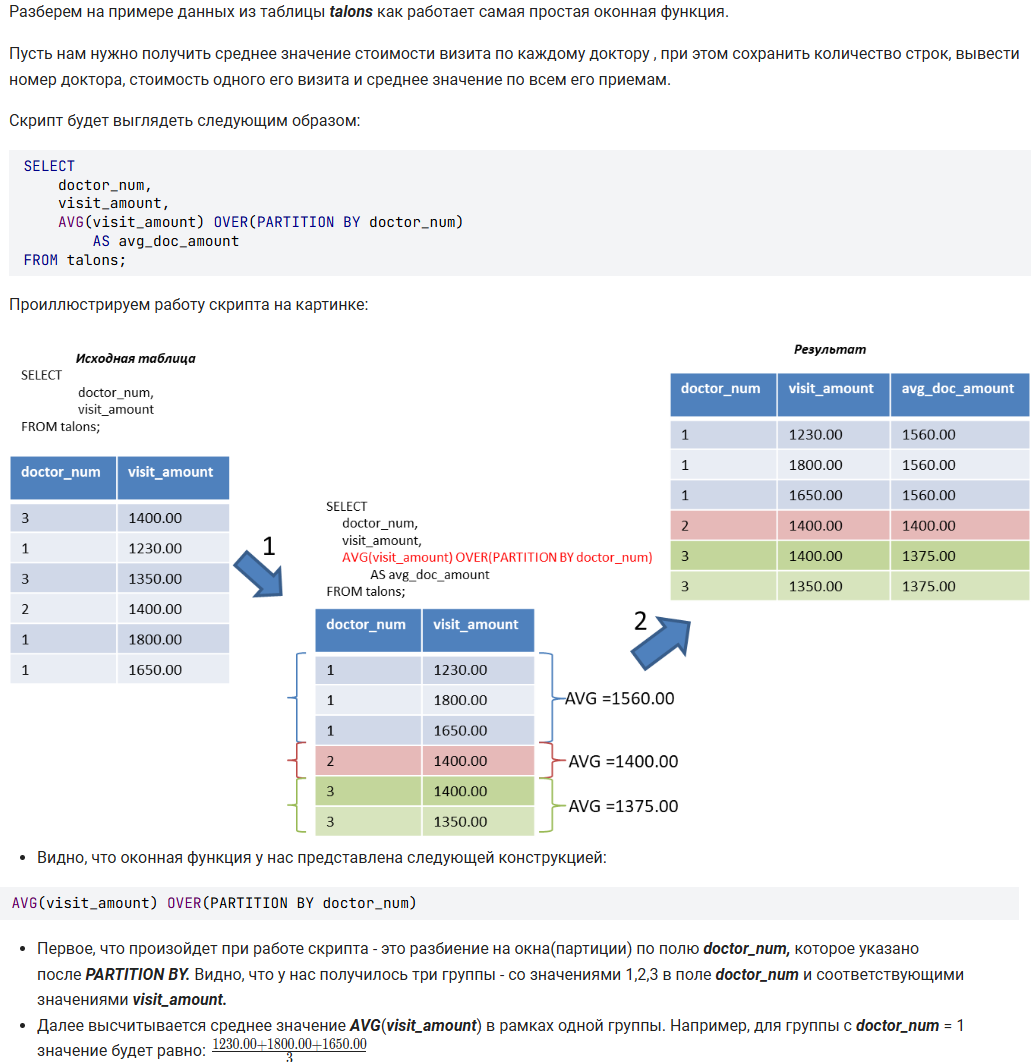

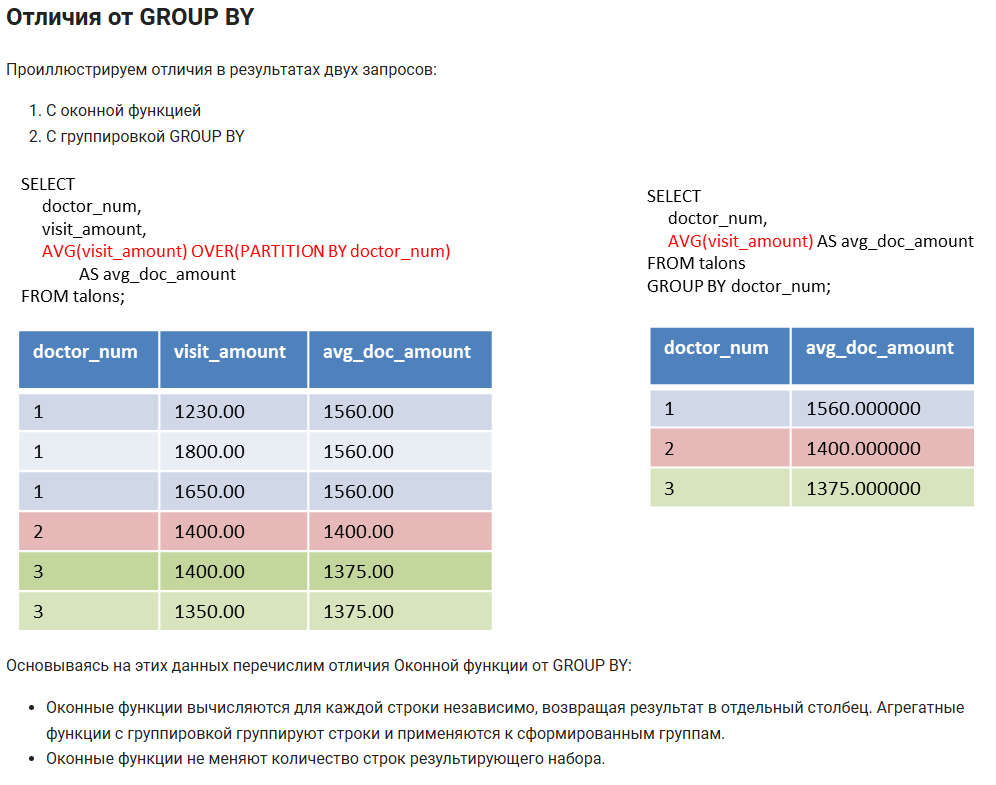

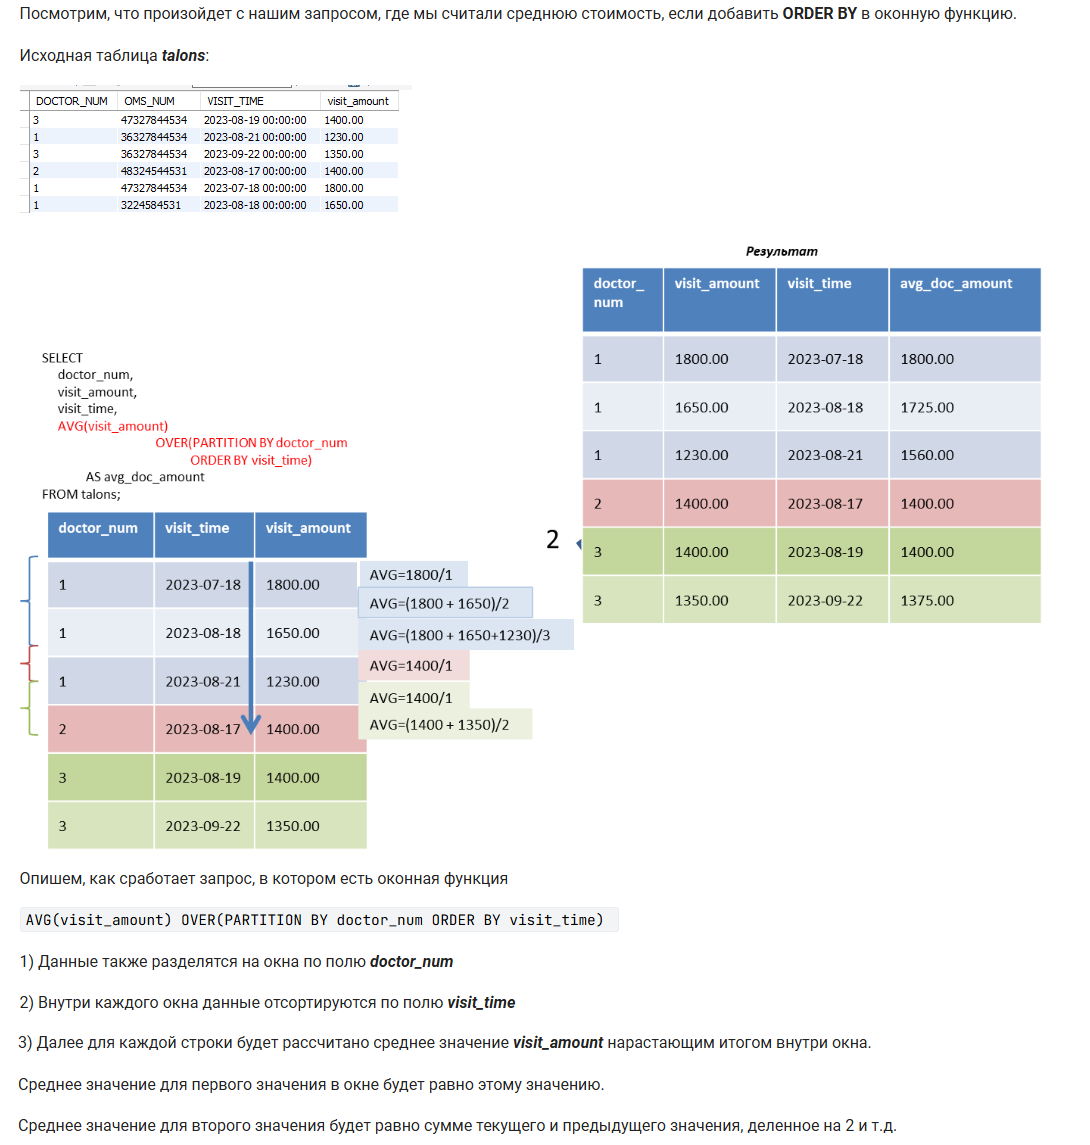

## 2. Ранжирующие

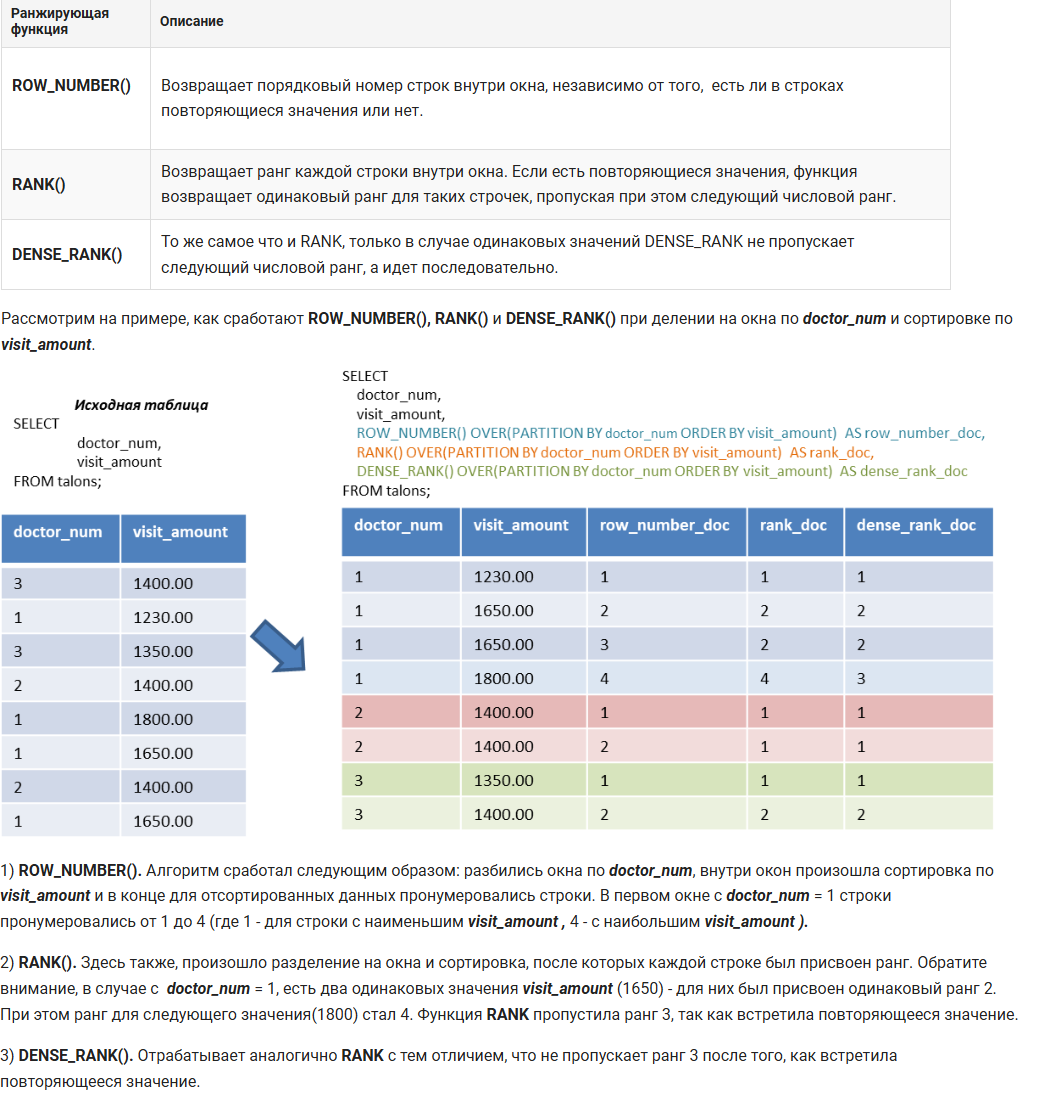

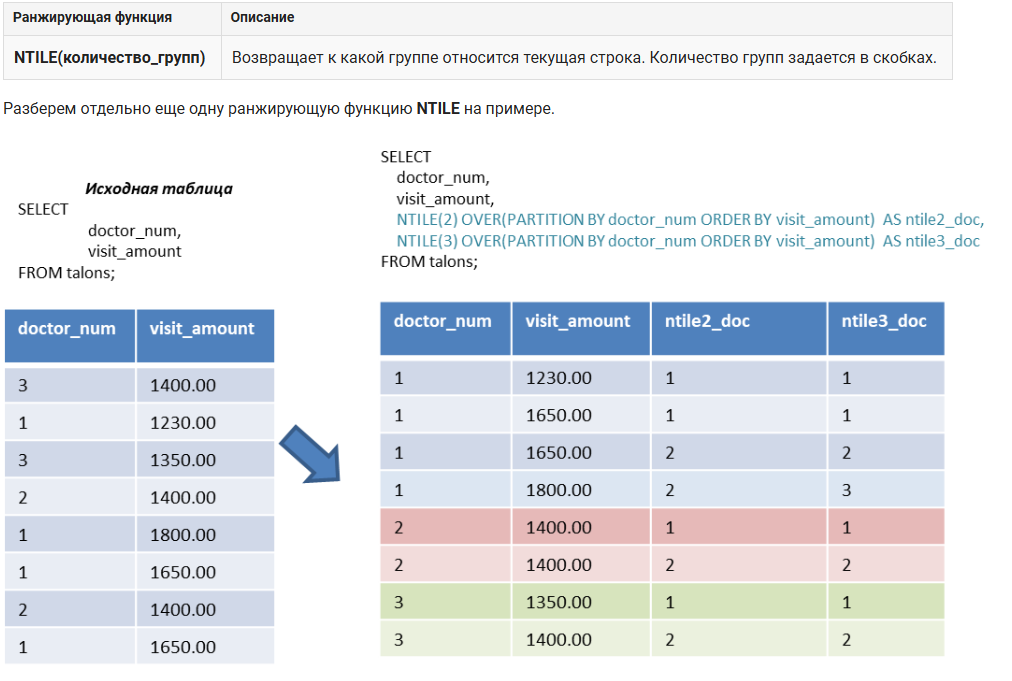

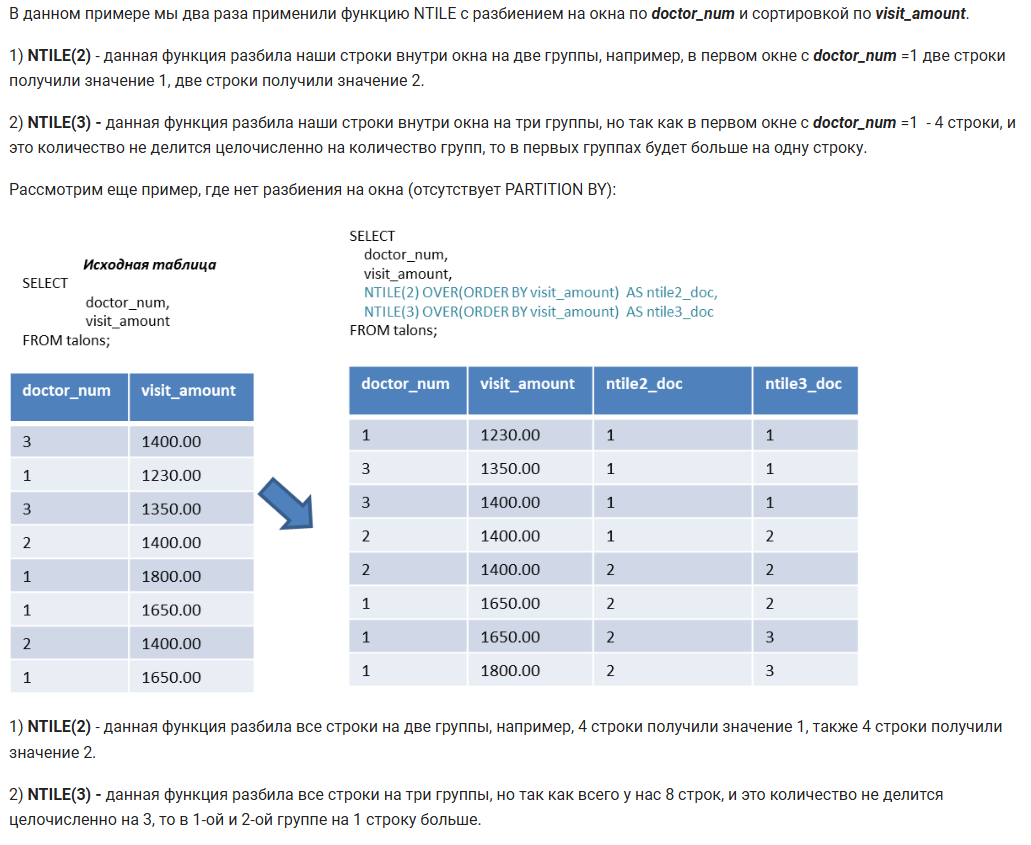

## 3. Функции смещения

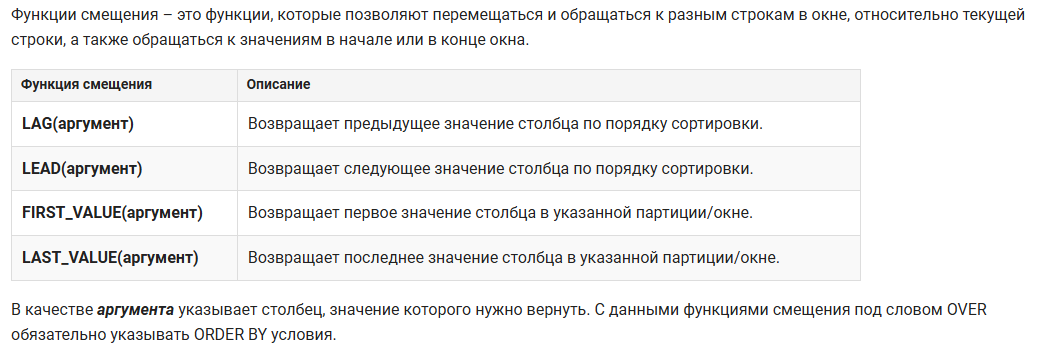

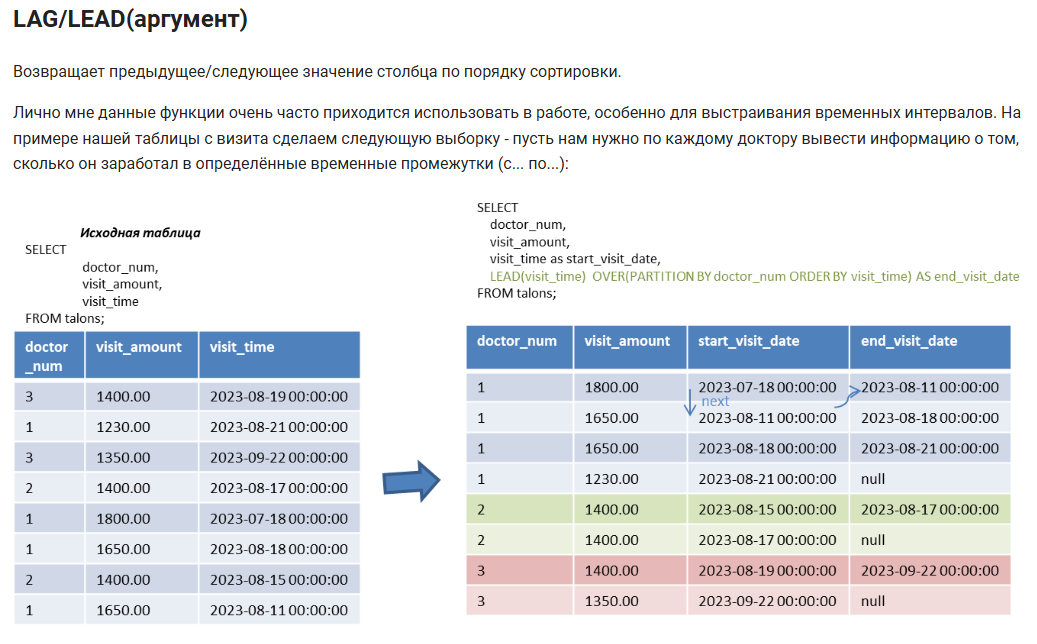

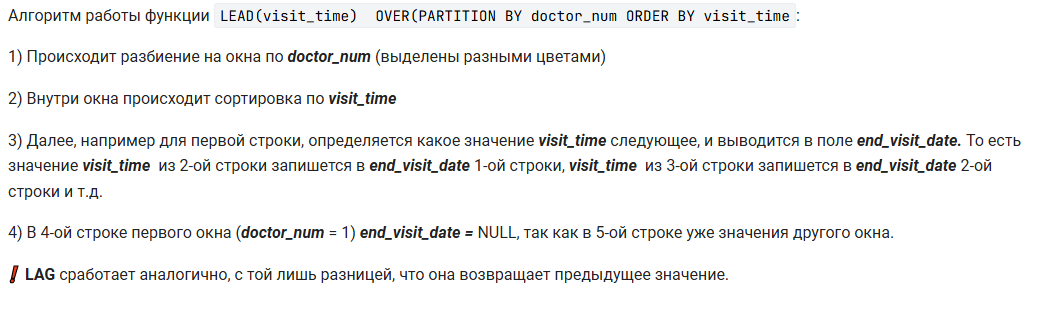

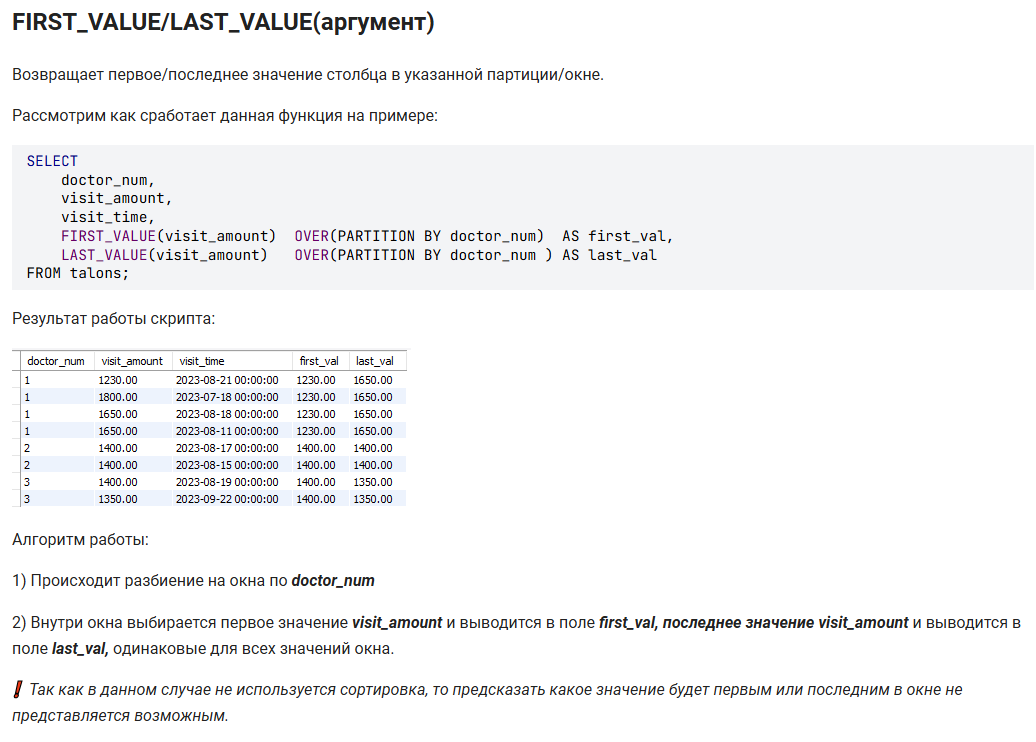

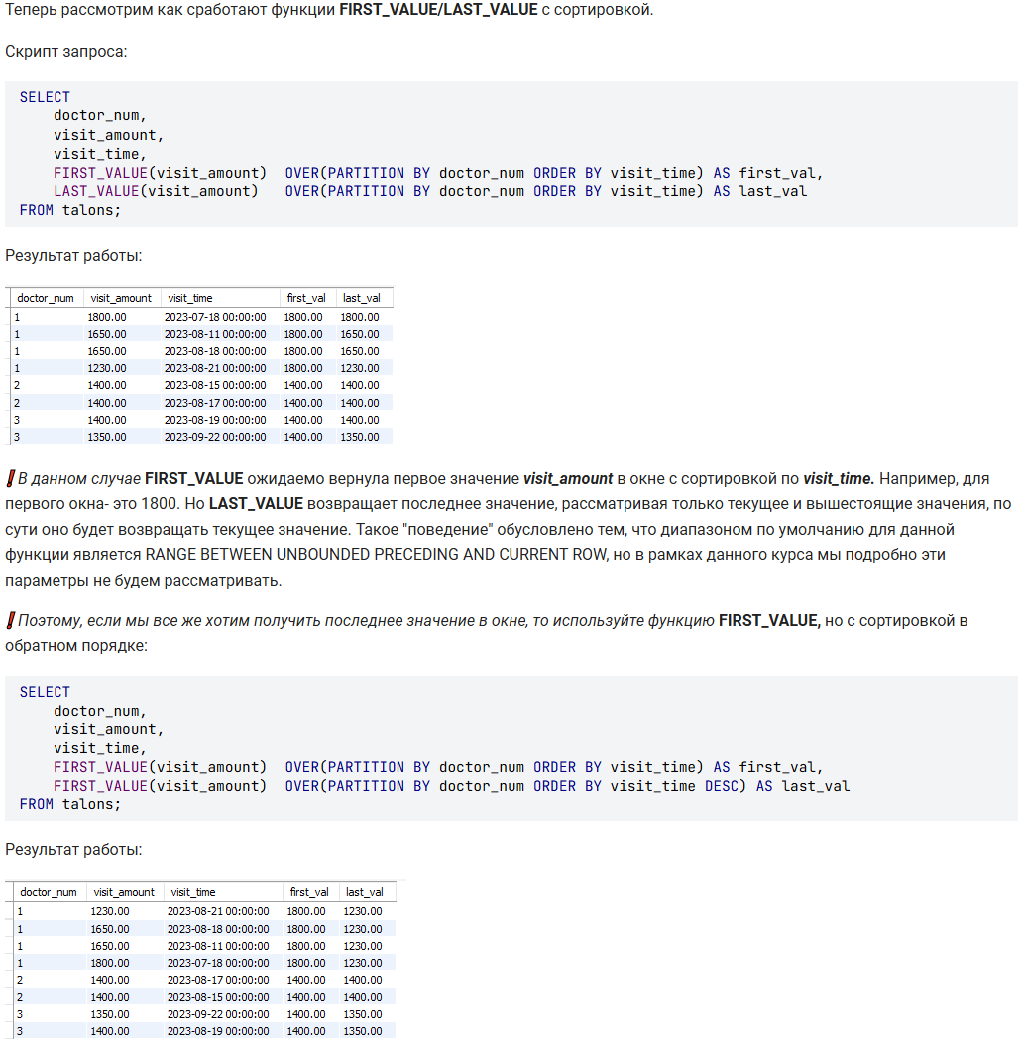

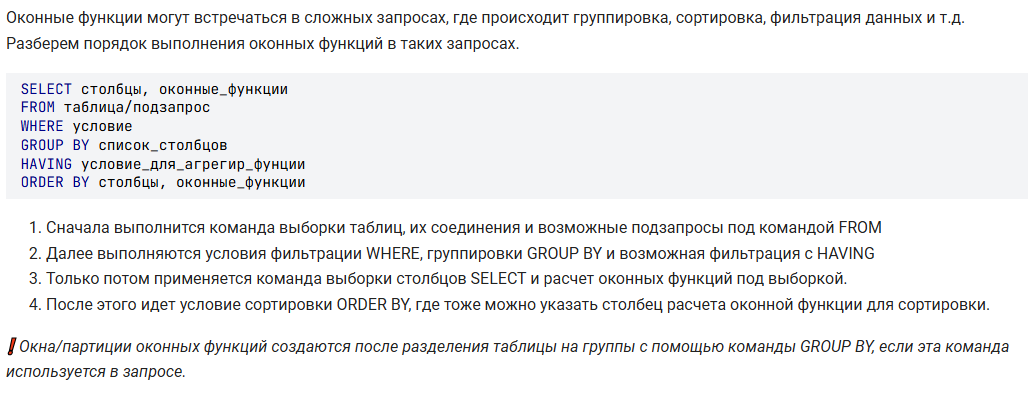

## **Общая сумма vs нарастающий итог**  


**Первый запрос: ОБЩАЯ сумма**
```sql
SUM(fine_amount) OVER (PARTITION BY reader_num) as reader_fine_amount
```

Вычисляет **общую сумму** всех штрафов для каждого читателя и повторяет это значение во всех строках.


**Второй  запрос: НАРАСТАЮЩИЙ итог**
```sql
SUM(fine_amount) OVER(PARTITION BY reader_num ORDER BY book_num) AS reader_book_amount
```

Вычисляет сумму штрафов для каждого читателя, которая **накапливается по мере упорядочения по book_num**.




Наглядный пример:

Допустим, у нас такие данные:
| reader_num | book_num | fine_amount |
|------------|----------|-------------|
| 1 | 101 | 100 |
| 1 | 102 | 50 |
| 1 | 103 | 200 |
| 2 | 201 | 75 |

Результат ПЕРВОГО запроса:
| reader_num | book_num | fine_amount | reader_fine_amount |
|------------|----------|-------------|-------------------|
| 1 | 101 | 100 | **350** ⬅ общая сумма |
| 1 | 102 | 50 | **350** ⬅ общая сумма |
| 1 | 103 | 200 | **350** ⬅ общая сумма |
| 2 | 201 | 75 | **75** ⬅ общая сумма |

Результат ВТОРОГО  запроса:
| reader_num | book_num | fine_amount | reader_book_amount |
|------------|----------|-------------|-------------------|
| 1 | 101 | 100 | **100** |
| 1 | 102 | 50 | **150** ⬅ накопленная сумма |
| 1 | 103 | 200 | **350** ⬅ накопленная сумма |
| 2 | 201 | 75 | **75** |



Ключевые различия:

| Аспект | Второй запрос | Первый запрос |
|--------|---------------|---------------|
| **Тип расчета** | Накопительный | Общая сумма |
| **ORDER BY** | Есть | Нет |
| **Окно расчета** | От начала до текущей строки | Все строки раздела |
| **Поведение** | Значение меняется в каждой строке | Значение одинаковое во всех строках раздела |

Когда использовать:
- **Первый** - когда нужно знать общую сумму штрафов читателя для каждой записи
- **Второй** - когда нужно видеть динамику накопления штрафов


**`PARTITION BY`** разбивает окно на партиции по выбранному полю

Когда вы используете оконные функции **без `PARTITION BY`**, окно применяется **ко всем строкам результата запроса**.

Когда вы используете оконные функции **c `ORDER BY`**, **НАРАСТАЮЩИЙ итог накапливается по мере упорядочения**.

Когда вы используете оконные функции **без `ORDER BY`**, **Вычисляет общую сумму и повторяет это значение во всех строках**.

**1. SUM без PARTITION BY**
```sql
SELECT
    date,
    amount,
    SUM(amount) OVER (ORDER BY date) as running_total,
    SUM(amount) OVER () as grand_total
FROM sales;
```
**Результат:**
```
date       | amount | running_total | grand_total
-----------|--------|---------------|------------
2024-01-01 | 100    | 100           | 1000
2024-01-02 | 200    | 300           | 1000
2024-01-03 | 150    | 450           | 1000
2024-01-04 | 300    | 750           | 1000
2024-01-05 | 250    | 1000          | 1000
```


Когда вы используете оконные функции **c `ORDER BY`**, **НАРАСТАЮЩИЙ итог накапливается по мере упорядочения**.


**Первый запрос: ОБЩАЯ сумма**
```sql
SUM(fine_amount) OVER (PARTITION BY reader_num) as reader_fine_amount
```

Вычисляет **общую сумму** всех штрафов для каждого читателя и повторяет это значение во всех строках.


**Второй  запрос: НАРАСТАЮЩИЙ итог**
```sql
SUM(fine_amount) OVER(PARTITION BY reader_num ORDER BY book_num) AS reader_book_amount
```

Вычисляет сумму штрафов для каждого читателя, которая **накапливается по мере упорядочения по book_num**.




## Оконные функции без PARTITION BY

Когда вы используете оконные функции **без `PARTITION BY`**, окно применяется **ко всем строкам результата запроса**.

**Базовый синтаксис:**
```sql
SELECT
    column1,
    column2,
    WINDOW_FUNCTION() OVER (ORDER BY column3) as window_result
FROM table_name;
```

**Примеры и отличия:**

**1. SUM без PARTITION BY**
```sql
SELECT
    date,
    amount,
    SUM(amount) OVER (ORDER BY date) as running_total,
    SUM(amount) OVER () as grand_total
FROM sales;
```
**Результат:**
```
date       | amount | running_total | grand_total
-----------|--------|---------------|------------
2024-01-01 | 100    | 100           | 1000
2024-01-02 | 200    | 300           | 1000
2024-01-03 | 150    | 450           | 1000
2024-01-04 | 300    | 750           | 1000
2024-01-05 | 250    | 1000          | 1000
```

**2. ROW_NUMBER, RANK без PARTITION BY**
```sql
SELECT
    employee_name,
    salary,
    ROW_NUMBER() OVER (ORDER BY salary DESC) as row_num,
    RANK() OVER (ORDER BY salary DESC) as rank
FROM employees;
```
**Результат:**
```
employee | salary | row_num | rank
---------|--------|---------|-----
Alice    | 5000   | 1       | 1
Bob      | 4500   | 2       | 2
Charlie  | 4500   | 3       | 2  -- одинаковый salary = одинаковый rank
David    | 4000   | 4       | 4
```

**3. AVG без PARTITION BY**
```sql
SELECT
    product,
    price,
    AVG(price) OVER () as avg_price
FROM products;
```
**Результат:**
```
product | price | avg_price
--------|-------|----------
A       | 100   | 183.33
B       | 200   | 183.33
C       | 250   | 183.33
```

**Сравнение с PARTITION BY:**

**Без PARTITION BY:**
```sql
-- Одно окно на всю таблицу
SELECT
    department,
    salary,
    AVG(salary) OVER () as company_avg
FROM employees;
```
```
department | salary | company_avg
-----------|--------|------------
IT         | 5000   | 4000
IT         | 4500   | 4000
HR         | 3500   | 4000
Sales      | 3000   | 4000
```

**С PARTITION BY:**
```sql
-- Отдельное окно для каждого отдела
SELECT
    department,
    salary,
    AVG(salary) OVER (PARTITION BY department) as dept_avg
FROM employees;
```
```
department | salary | dept_avg
-----------|--------|----------
IT         | 5000   | 4750
IT         | 4500   | 4750
HR         | 3500   | 3500
Sales      | 3000   | 3000
```

**Когда использовать без PARTITION BY:**

1. **Общие агрегаты по всем данным:**
   ```sql
   -- Средняя цена по всем товарам
   SELECT product, price, AVG(price) OVER () as overall_avg
   FROM products;
   ```

2. **Сквозная нумерация:**
   ```sql
   -- Пронумеровать всех сотрудников по зарплате
   SELECT name, salary, ROW_NUMBER() OVER (ORDER BY salary DESC) as position
   FROM employees;
   ```

3. **Накопительные итоги по всему набору:**
   ```sql
   -- Накопительная выручка за все время
   SELECT date, revenue, SUM(revenue) OVER (ORDER BY date) as cumulative
   FROM sales;
   ```

4. **Процентили по всей выборке:**
   ```sql
   -- Процентиль зарплаты среди всех сотрудников
   SELECT name, salary,
          PERCENT_RANK() OVER (ORDER BY salary) as percentile
   FROM employees;
   ```

**Важные нюансы:**

1. **Без ORDER BY:**
   ```sql
   -- Все строки рассматриваются как одна группа
   SELECT name, COUNT(*) OVER () as total_count FROM employees;
   ```

2. **С ORDER BY но без фрейма:**
   ```sql
   -- По умолчанию: RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
   SELECT date, SUM(amount) OVER (ORDER BY date) as running_total
   FROM sales;
   ```

3. **Явное указание фрейма:**
   ```sql
   -- Сумма всех строк, а не накопительная
   SELECT date, SUM(amount) OVER (ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as total
   FROM sales;
   ```


# Задачи

**Необходимо вывести список сотрудников, получающих заработную плату больше, чем у непосредственного руководителя**

```sql
SELECT a.*
FROM employee a
INNER JOIN employee b ON b.id = a.chief_id
WHERE a.salary > b.salary;
```
Вариант (с явным INNER JOIN) более правильный

```sql
SELECT a.*
FROM employee a, employee b
WHERE b.id = a.chief_id AND a.salary > b.salary
```



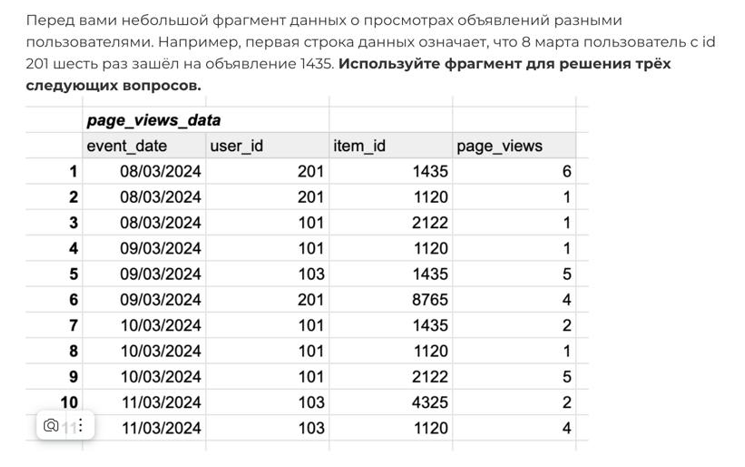

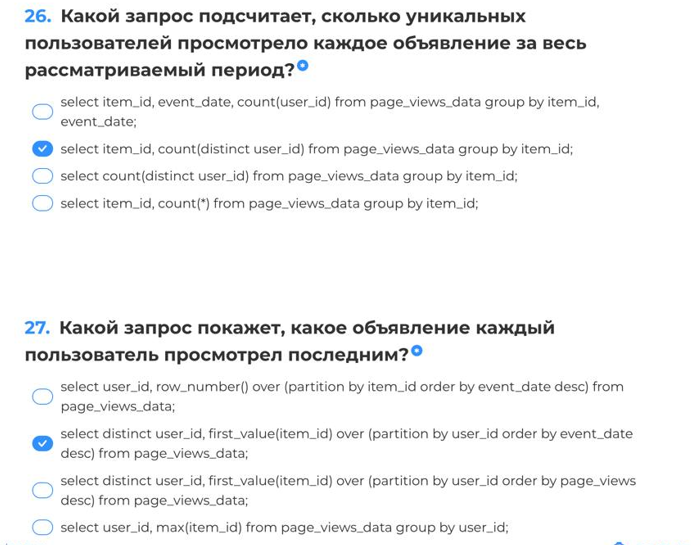

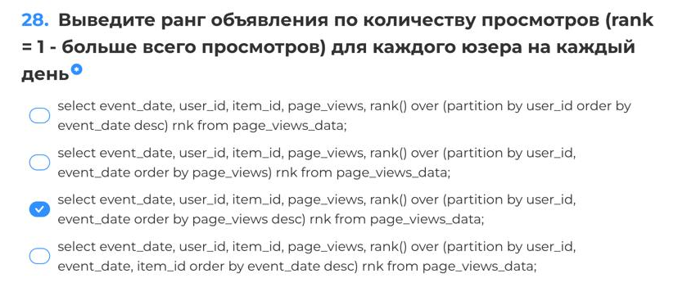

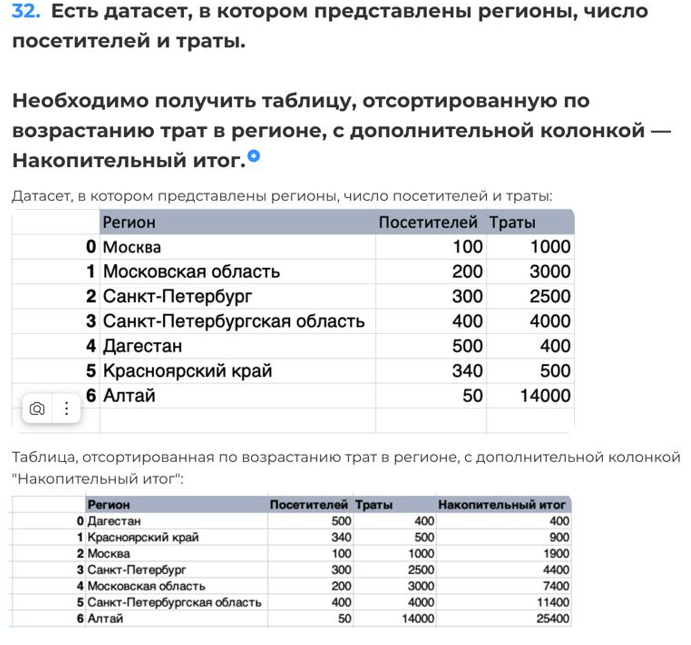

## Работа с БД

**Создайте новую таблицу - справочник с видами печатных изданий book_types**

```sql
CREATE TABLE book_types
(
    book_type_id INT AUTO_INCREMENT PRIMARY KEY,
    book_type_name VARCHAR(100),
    book_type_desc		  VARCHAR(100)
);
```

**Заполним таблицу book_types следующими данными:**

```sql
INSERT INTO book_types (book_type_name, book_type_desc)
VALUES
    ('Книги', 'Литературное или научное произведение'),
    ('Журналы', 'Печатное или электронное периодическое издание, имеющее постоянную рубрикацию и содержащее статьи или рефераты по различным общественно-политическим, научным, производственным и др. вопросам, литературно-художественные произведения'),
    ('Газеты', 'Печатное периодическое издание, выходящее под постоянным названием и не реже одного раза в месяц'),
    ('Архивные материалы', 'Опубликованные документы, существующие в виде идентичных копий, хранящихся в разных библиотеках');
```

**Добавьте в таблицу books новое поле - вид печатного издания book_type_id c типом данных INT.**


```sql
ALTER TABLE books
ADD COLUMN book_type_id INT;
```


**Добавьте внешний ключ, который свяжет таблицу books и book_types по полю book_type_id.**


```sql
ALTER TABLE books
ADD FOREIGN KEY(book_type_id) REFERENCES book_types(book_type_id)
```

**Измените значение book_type_id в таблице books, проставив всем записям book_type_id, который соответствует виду Книги.**

```sql
UPDATE books
SET  book_type_id = 1;
```

**Добавьте в таблицу books записи о журналах, газетах и архивных материалах, используя следующие данные:
( ! Для заполнения book_num используйте AUTO_INCREMENT, а не явное заполнение числами)**


```sql
INSERT INTO books (book_author, book_name, book_count, book_type_id)
VALUES
    ('Самиздал', 'Практика функционального программирования', 7, 2),
    ('Феникс', 'Садовод', 11, 2),
    ('ООО "5К"', '5 Колесо', 25, 2),
    ('ООО "Собеседник-Медиа"', 'Собеседник', 5, 3),
    ('ООО "МИЦ "Известия"', 'Известия', 37, 3),
    ('АО «Коммерсантъ»', 'КОММЕРСАНТЪ', 27, 3),
    ('ООО "Издательство "Моя Семья"', 'Моя семья', 18, 3),
    ('', 'Документы из архива СВР России по истории советского атомного проекта', 17, 4),
    ('', 'Документы о воинских советских мемориалах и захоронениях на территории Европы', 75, 4),
    ('', 'Документы из личного архива маршала Советского Союза Р. Я. Малиновского', 2, 4);
```





## **GROUP BY, HAVING**

ORDER BY, COUNT, LIKE

**Выведите количество врачей по каждой специализации. В результирующем наборе должны быть поля: spec и вычисляемое поле с количеством, назовите его count_docs. ! В результирующем наборе должны быть строки с неуказанной специализацией (null - значением).**


```sql
select spec, count(*) as count_docs
from doctors
group by doctor_num
order by count_docs desc
```
**Вывести сумму, которую потратили пациенты на посещения врачей, то есть по каждому номеру ОМС посчитайте сумму. Выведите ОМС пациента и сумму(вычисляемый столбец назовите sum_visit).**


```sql
select oms_num, sum(visit_amount) as sum_visit
from talons
group by oms_num
```


**Выведите сколько женщин и мужчин среди пациентов. Вычисляемый столбец назовите count_pacient.**


```sql
select sex, count(*) as count_pacient
from patients
group by sex
order by sex desc
```

**Сколько мужчин и женщин среди пациентов, родившихся после 1970 года? Вычисляемое поле назовите count_pacient.**


```sql
select sex, count(*) as count_pacient
from patients
where year(birth_date)>1970
group by sex
```

**Выведите номера врачей, у которых было больше одного посещения. В результате выведите только номера врачей.**


```sql
select doctor_num
from talons
group by doctor_num
having count(*)>1
```


**По каждому автору выведите количество книг (не экземпляров!). Вычисляемое поле назовите  books_count.**


```sql
SELECT
    book_author,
    COUNT(*) AS books_count
FROM
    books
GROUP BY
    book_author;
```


**Вывести общее количество книг (не экземпляров!) по каждому автору с фамилиями: Тургенев и Чехов. Вычисляемое поле назовите  books_count.**


```sql
SELECT book_author, COUNT(*) AS books_count
FROM books
WHERE book_author LIKE '%Тургенев' OR book_author LIKE '%Чехов'
GROUP BY book_author;

```


**Вывести список тех авторов, творчество которых представлено только одной книгой.**


```sql
SELECT book_author
FROM books
GROUP BY book_author
HAVING COUNT(*) = 1;
```


**Вывести информацию о трех книгах (все поля), которые представлены в библиотеке наибольшим количеством экземпляров.**


```sql
select *
from books
order by book_count desc
limit 3
```

**Вычислить среднюю величину штрафа по всем книгам. Округлите результат до двух знаков после запятой, назовите столбец - avg_fine_amount.**


```sql
select ROUND(avg(fine_amount),2) as avg_fine_amount
from books_in_use;
```


**Найти минимальный штраф за просроченную книгу, не учитывая значения с 0. Назовите столбец - min_fine_amount.**


```sql
select ROUND(min(fine_amount),2) as min_fine_amount
from books_in_use
where fine_amount is not null and fine_amount>0;
```


**Найти количество различных книг, которые есть в библиотеке, не учитывая количество конкретных копий. Назовите столбец - books_count.**


```sql
select count(book_name) as books_count
from books
```


**Вывести информацию о книгах, названия которых начинаются с буквы С, О или В.**

```sql
SELECT *
FROM books
WHERE book_name LIKE 'С%'
   OR book_name LIKE 'О%'
   OR book_name LIKE 'В%';
```




**Сколько заказов обработал каждый менеджер?**
```sql
SELECT manager_id, COUNT(order_id) AS orders_count
FROM orders
GROUP BY manager_id;
```

**Показать менеджеров с >10 заказами**
```sql
SELECT manager_id, COUNT(*)
FROM orders
GROUP BY manager_id
HAVING COUNT(*) > 10;
```

**Показать менеджеров с >10 заказами**
```sql
SELECT manager_id, COUNT(order_id) AS orders_count
FROM orders
GROUP BY manager_id
HAVING COUNT(order_id) > 10;
```


**Сколько уникальных клиентов купили товар категории Электроника?**
```sql
SELECT COUNT(DISTINCT customer_id) AS unique_customers
FROM orders
WHERE category = 'Electronics';
```

**Сколько департаментов представлено в таблице сотрудников?**
```sql
SELECT COUNT(DISTINCT dept_id) AS total_depts
FROM employees;
```

**Топ-3 самых активных клиентов**
```sql
SELECT
    customer_id,
    COUNT(*) AS total_orders
FROM orders
GROUP BY customer_id
ORDER BY total_orders DESC
LIMIT 3;
```

**Есть ли заказы у клиента с ID=100?**
```sql
SELECT CASE
         WHEN COUNT(*) > 0 THEN 'Есть заказы'
         ELSE 'Нет заказов'
       END
FROM orders
WHERE customer_id = 100;
```

**Для каждого заказа показать долю от общего числа**

```sql
SELECT
    order_id,
    COUNT(*) OVER () AS total_orders,
    100.0 * COUNT(*) OVER () / COUNT(*) OVER () AS percentage
FROM orders;
```










## **JOIN**

**Вывести информацию о выдаче печатных изданий с указанием их названий - автор, название, номер читательского билета,  дата выдачи, дата возврата.**


```sql
SELECT
	b.book_author,
	b.book_name,
	u.reader_num,
	u.issue_date,
	u.return_date
FROM books_in_use u
JOIN books b
ON (u.book_num = b.book_num);
```



**Вывести следующую информацию о выдаче книг: фамилия читателя, название книги, автор, дата выдачи, сумма штрафа за просроченные дни.**

```sql
SELECT
	r.reader_name,
	bb.book_name,
	bb.book_author,
	b.issue_date,
	b.fine_amount
FROM books_in_use b
JOIN readers r
ON (b.reader_num = r.reader_num)
JOIN books bb
ON (b.book_num = bb.book_num);
```

**Вывести информацию обо всех абонентах, указав шифры книг, которые были им выданы, если такие имеются.**

```sql
SELECT
    r.reader_num,
    r.reader_name,
    r.reader_adress,
    r.reader_phone,
    b.book_num
FROM
    readers r
LEFT JOIN
    books_in_use b
ON
    r.READER_NUM = b.READER_NUM;
```

**Вывести информацию о количестве книг, которые выданы каждому из читателей. В результирующем наборе должны быть- номер читательского, фамилия читателя и количество выданных ему книг. ! Для читателей, которые не брали книги, выведите количество = 0**
```sql
select r.reader_num as reader_num , r.reader_name as reader_name, count(b.reader_num) as count_books
from readers r
left join books_in_use b
on r.reader_num=b.reader_num
group by reader_num
```

**Вычислить полную сумму штрафов за просроченные книги, выданные читателю Дроздову. Вывести необходимо номер читательского, фамилию читателя и сумму штрафов .**
```sql
select r.reader_num as reader_num, r.reader_name as reader_name, sum(b.fine_amount) as fine_amount
from readers r
left join books_in_use b
on r.reader_num=b.reader_num
where r.reader_num=3
group by reader_num
```

**Вывести информацию обо всех книгах, количество экземпляров которых больше, чем у книги «Война и мир».**
```sql
select * from books
where book_count>15 and book_type_id=1
```

**Вывести информацию о книгах, количество экземпляров которых не ниже, чем среднее количество экземпляров книг.**
```sql
SELECT *
FROM books
WHERE book_type_id = 1
  AND book_count > (SELECT AVG(book_count)
                    FROM books
                    WHERE book_type_id = 1);
```

**Вывести фамилии читателей, которым был назначен наибольший штраф за просроченные дни.**
```sql
select reader_name
from readers r
join books_in_use b
on r.reader_num=b.reader_num
where b.fine_amount=(select max(fine_amount) from books_in_use)
```

**Вывести список читателей (все поля из таблицы readers), которым не выдавали какие-либо печатные издания.**
```sql
SELECT r.*
FROM readers r
WHERE r.READER_NUM NOT IN (SELECT READER_NUM FROM  books_in_use);
```

**Вывести информацию о всех печатных изданиях, количество экземпляров(book_count) которых больше или равно, чем количество экземпляров любой книги, хранимой в библиотеке.**

```sql
select * from books
where book_count>= all(select book_count from books where book_type_id=1)
```

**Вывести информацию о книгах, количество экземпляров которых, превышает количество экземпляров хотя бы одного из журналов.**

```sql
select * from books
where book_type_id=1 and book_count>any(select book_count from books where book_type_id=2 )
```

**Вывести информацию о тех читателях, которые хоть раз брали любое печатное издание в библиотеке.**
```sql
SELECT *
FROM readers r
WHERE EXISTS (SELECT * FROM books_in_use b WHERE r.reader_num = b.reader_num)
```

**Вывести список фамилий читателей, которые читали ТОЛЬКО книгу «Война и мир».**
```sql
SELECT r.reader_name
FROM readers r
JOIN books_in_use bu ON r.reader_num = bu.reader_num
JOIN books b ON bu.book_num = b.book_num
GROUP BY r.reader_name
HAVING COUNT(DISTINCT b.book_name) = 1  -- Читатель брал только одну книгу
   AND MAX(b.book_name) = 'Война и мир'; -- Эта книга — «Война и мир»
```

```sql
# Выбран кодовый формат
```

## **Оконные функции**


**Агрегирующие оконные функции**

**Выведите информацию о всех посещениях поликлиники - номер доктора, стоимость визита и максимальную стоимость визита, которая была у текущего доктора.**



```sql
SELECT
    doctor_num,
    visit_amount,
    MAX(visit_amount) OVER(PARTITION BY doctor_num)
        AS max_doc_amount
FROM talons;
```

**Измените предыдущий скрипт, вычислив процент суммы визита от максимальной суммы визита каждого доктора. Вычисляется по формуле:
`(visit_amount/Макс.сумма по доктору∗100)`
Выведите номер доктора, стоимость визита и процент, округленный до целого числа.**

```sql
SELECT
    doctor_num,
    visit_amount,
    ROUND((visit_amount / MAX(visit_amount) OVER (PARTITION BY doctor_num)) * 100,0)
    AS procent_amount
FROM talons;
```

**Выведите сколько заработал доктор с течением времени, то есть в первый день работы он заработал x рублей, во второй день работы x+y рублей и т.д.
В результирующем наборе должны быть: номер доктора, стоимость визита, дата визита и рассчитанная сумма визитов.**

```sql
SELECT
     doctor_num,
     visit_amount,
     visit_time,
     SUM(visit_amount) OVER(PARTITION BY doctor_num ORDER BY visit_time)  
              AS sum_doc_amount
FROM talons;
```

**Ранжирующие оконные функции**

**Из таблицы с визитами выберите самые первые(по времени) визиты по каждому доктору. Выведите все поля из таблицы talons.
❗️ Используйте функцию ROW_NUMBER() для разметки строк("оберните" результат в подзапрос), а затем отфильтруйте строки, где нумерация строк равна 1.**

```sql
SELECT
    doctor_num,
    oms_num,
    visit_time,
    visit_amount
FROM (SELECT *,
    ROW_NUMBER() OVER (PARTITION BY doctor_num ORDER BY visit_time) AS rn
    FROM talons) AS subquery
WHERE rn = 1;
```


```sql
SELECT
	doctor_num,
    oms_num,
    visit_time,
    visit_amount
FROM (SELECT t.*,
    ROW_NUMBER() OVER(PARTITION BY t.doctor_num ORDER BY t.visit_time)  AS rn
	FROM talons t) a
WHERE a.rn = 1;
```



Эквивалент через CTE
```sql
WITH ranked_talons AS (
    SELECT *,
    ROW_NUMBER() OVER (PARTITION BY doctor_num ORDER BY visit_time) AS rn
    FROM talons
)
SELECT
    doctor_num,
    oms_num,
    visit_time,
    visit_amount
FROM ranked_talons
WHERE rn = 1;
```


Через DISTINCT ON (в PostgreSQL):
```sql
SELECT DISTINCT ON (doctor_num)
    doctor_num,
    oms_num,
    visit_time,
    visit_amount
FROM talons
ORDER BY doctor_num, visit_time;
```


Через коррелированный подзапрос:
```sql
SELECT
    doctor_num,
    oms_num,
    visit_time,
    visit_amount
FROM talons t1
WHERE visit_time = (
    SELECT MIN(visit_time)
    FROM talons t2
    WHERE t2.doctor_num = t1.doctor_num
);
```




**Проставьте ранг для стоимости посещения от самой большой стоимости(ранг = 1) до самой маленькой. Выведите все поля из таблицы talons и ранг.**

```sql
SELECT
    doctor_num,
    oms_num,
    visit_time,
    visit_amount,
    DENSE_RANK() OVER (ORDER BY visit_amount DESC) AS dr
FROM talons;
```

**Функции смещения**

**Посчитайте и выведите разницу между текущей и предыдущей стоимостью визита для каждого доктора. Данные по докторам должны быть отсортированы по дате от меньшего к большему. Выведите номер доктора, стоимость, дату визита, и разницу. ! Для первого значения разницы вместо NULL выведите 0.**

```sql
SELECT
    doctor_num,
    visit_amount,
    visit_time,
    COALESCE(visit_amount - LAG(visit_amount) OVER (
            PARTITION BY doctor_num ORDER BY visit_time), 0) AS diff
FROM talons
ORDER BY doctor_num, visit_time;
```

**Выведите информацию о посещениях пациентов: ОМС пациента, дата визита, стоимость визита и дату первого посещения. Результат должен быть отсортирован по ОМС пациента и дате визита.**

```sql
SELECT
    oms_num,
    visit_time,
    visit_amount,
    MIN(visit_time) OVER (PARTITION BY oms_num) AS first_visit
FROM talons
ORDER BY oms_num, visit_time;
```

**Необходимо получить отчет о штрафах за просроченный период. Для этого выведите номер читательского, шифр печатного издания, дату выдачи, штраф за просрочку и сумму штрафов по каждому читателю.**

```sql
SELECT
    reader_num,
    book_num,
    issue_date,
    fine_amount,
    SUM(fine_amount) OVER (PARTITION BY reader_num) as reader_fine_amount
FROM books_in_use;
```

**Измените предыдущий скрипт, рассчитав сумму штрафов по каждому читателю нарастающим итогом, отсортировав данные по номеру печатного издания. Для этого выведите номер читательского, шифр печатного издания, дату выдачи, штраф за просрочку и сумму штрафов по каждому читателю нарастающим итогом.**

```sql
SELECT
	reader_num,
	book_num,
	issue_date,
	fine_amount,
	SUM(fine_amount) OVER(PARTITION BY reader_num ORDER BY book_num) AS reader_book_amount
FROM books_in_use;
```

**Измените предыдущий скрипт, в котором вместо номера читательского и номера печатного издания выведите фамилию читателя и название печатного издания. В результате должны быть следующие поля: фамилия читателя, название печатного издания, дату выдачи, штраф за просрочку и сумму штрафов по каждому читателю нарастающим итогом.
Отсортируйте результат по номеру читательского билета(по возрастанию).**

```sql
SELECT
    r.reader_name AS reader_name,
    b.book_name AS book_name,
    biu.issue_date,
    biu.fine_amount,
    SUM(biu.fine_amount) OVER(PARTITION BY biu.reader_num ORDER BY biu.book_num) AS sum
FROM books_in_use biu
JOIN readers r ON biu.reader_num = r.reader_num
JOIN books b ON biu.book_num = b.book_num
ORDER BY biu.reader_num;
```


**Пронумеруйте строки данных о выдачах каждого читателя, данные отсортируйте по дате выдачи по возрастанию. В результате выведите: номер читательского, шифр печатного издания, дату выдачи, номер строки в группе читателей.**

```sql
SELECT
    reader_num,
    book_num,
    issue_date,
    ROW_NUMBER() OVER (PARTITION BY reader_num ORDER BY issue_date) AS row_number_read
FROM books_in_use
ORDER BY reader_num;
```

**Используя предыдущий скрипт выведите только одно печатное издание по каждому читателю (то, которое он брал первым). В результате выведите: фамилию читателя, название печатного издания, дату выдачи. Результат отсортируйте по возрастанию фамилии читателя.
! Предыдущий скрипт сделайте подзапросом и используйте его для текущей задачи.**

```sql
WITH first_issue AS (
    SELECT
        reader_num,
        book_num,
        issue_date,
        ROW_NUMBER() OVER (PARTITION BY reader_num ORDER BY issue_date) AS row_number_read
    FROM books_in_use
)
SELECT
    r.reader_name AS reader_name,
    b.book_name AS book_name,
    fi.issue_date AS issue_date
FROM
    readers r
LEFT JOIN
    first_issue fi ON r.reader_num = fi.reader_num AND fi.row_number_read = 1
LEFT JOIN
    books b ON fi.book_num = b.book_num
WHERE
    b.book_name IS NOT NULL
ORDER BY
    r.reader_name ASC;
```

**Проранжируйте печатные издания по количеству экземпляров от большего к меньшему (1 ранг у самого большого количества, последний ранг у самого меньшего количества). При одинаковом количестве ранг не должен пропускать номер для последующего значения.
В результате должны быть следующие поля: ранг, номер печатного издания, наименование типа печатного издания и количество экземпляров.
! Результат отсортируйте по возрастанию ранга и номеру печатного издания.**

```sql
SELECT
    DENSE_RANK() OVER (ORDER BY b.book_count DESC) AS rank_books,
    b.book_num,
    bt.book_type_name,
    b.book_count
FROM
    books b
JOIN
    book_types bt ON b.book_type_id = bt.book_type_id
ORDER BY
    rank_books ASC, b.book_num ASC;
```


**Необходимо вывести информацию о выдачах книг :**
- **номер читательского билета**
- **шифр печатного издания**
- **дату выдачи**
- **предыдущее значение даты возврата для одного и того же читателя и для одного и того же печатного издания**
- **дату возврата**



```sql
SELECT
    reader_num,
    book_num,
    issue_date,
    LAG(return_date) OVER (
        PARTITION BY reader_num, book_num
        ORDER BY issue_date
    ) AS lag_return_date,
    return_date
FROM
    books_in_use
ORDER BY
    reader_num, book_num, issue_date;
```


## **Продвинутые оконные функции**

Оконные функции — это один из самых мощных инструментов SQL для анализа данных. Помимо базовых функций вроде `ROW_NUMBER()` и `SUM() OVER()`, существуют продвинутые техники, которые позволяют решать сложные аналитические задачи. Вот примеры неочевидных и мощных применений оконных функций.

**1. Скользящие окна с динамическими рамками**

**Пример: Экспоненциальное скользящее среднее (EMA)**

Используется в финансовых расчетах для сглаживания временных рядов с большим весом последним значениям.

```sql
WITH price_data AS (
    SELECT
        date,
        close_price,
        ROW_NUMBER() OVER (ORDER BY date) AS rn
    FROM stock_prices
)
SELECT
    date,
    close_price,
    AVG(close_price) OVER (ORDER BY date
        ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) AS simple_moving_avg,
    -- EMA = (Цена * K) + (Предыдущая EMA * (1 - K))
    -- K = 2/(N+1), где N = период
    SUM(close_price * POWER(0.1, rn - n.rn)) OVER (ORDER BY date
        ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) /
    SUM(POWER(0.2, rn - n.rn)) OVER (ORDER BY date
        ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) AS exponential_moving_avg
FROM price_data n;
```

**Почему это продвинуто:**
- Использует математическую формулу EMA через комбинацию `SUM` и `POWER`
- Динамический расчет весов для каждого значения в окне
- Требует нумерации строк через `ROW_NUMBER()` для вычисления относительных позиций

**2. Анализ воронки конверсии с кумулятивными метриками**

**Пример: Детальный анализ воронки продаж с потерями на каждом этапе**
```sql
WITH user_journey AS (
    SELECT
        user_id,
        event,
        timestamp,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS step
    FROM user_events
    WHERE event IN ('view', 'cart', 'checkout', 'purchase')
),
funnel_analysis AS (
    SELECT
        event,
        COUNT(DISTINCT user_id) AS users,
        COUNT(DISTINCT user_id) FILTER (WHERE step = 1) AS new_users,
        SUM(COUNT(*)) OVER (ORDER BY
            CASE event
                WHEN 'view' THEN 1
                WHEN 'cart' THEN 2
                WHEN 'checkout' THEN 3
                WHEN 'purchase' THEN 4
            END
            ROWS UNBOUNDED PRECEDING) AS cumulative_users
    FROM user_journey
    GROUP BY event
)
SELECT
    event,
    users,
    new_users,
    cumulative_users,
    ROUND(100.0 * users / NULLIF(LAG(users) OVER (ORDER BY
        CASE event WHEN 'view' THEN 1 WHEN 'cart' THEN 2 WHEN 'checkout' THEN 3 WHEN 'purchase' THEN 4 END
    ), 0), 2) AS conversion_rate,
    ROUND(100.0 * users / NULLIF(MAX(users) OVER (), 0), 2) AS funnel_percentage
FROM funnel_analysis
ORDER BY
    CASE event WHEN 'view' THEN 1 WHEN 'cart' THEN 2 WHEN 'checkout' THEN 3 WHEN 'purchase' THEN 4 END;
```

**Почему это продвинуто:**
- Комбинация `FILTER`, `LAG`, и `OVER` с пользовательским порядком
- Расчет конверсии между этапами воронки
- Использование `ROWS UNBOUNDED PRECEDING` для кумулятивных метрик
- Обработка новых пользователей через условную агрегацию

**3. Статистические функции: медиана и перцентили**

**Пример: Расчет медианы и межквартильного размаха (IQR) для анализа аномалий**
```sql
SELECT
    department,
    AVG(salary) AS mean_salary,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary)
        OVER (PARTITION BY department) AS median_salary,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary)
        OVER (PARTITION BY department) AS q3,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary)
        OVER (PARTITION BY department) AS q1,
    (PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary)
        OVER (PARTITION BY department) -
     PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary)
        OVER (PARTITION BY department)) AS iqr,
    salary,
    CASE
        WHEN salary > PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary)
                    OVER (PARTITION BY department) + 1.5 * (
                        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary)
                        OVER (PARTITION BY department) -
                        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary)
                        OVER (PARTITION BY department)
                    ) THEN 'High Outlier'
        WHEN salary < PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary)
                    OVER (PARTITION BY department) - 1.5 * (
                        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY salary)
                        OVER (PARTITION BY department) -
                        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY salary)
                        OVER (PARTITION BY department)
                    ) THEN 'Low Outlier'
        ELSE 'Normal'
    END AS anomaly_status
FROM employees;
```

**Почему это продвинуто:**
- Использование `PERCENTILE_CONT` для точного расчета квантилей
- Расчет межквартильного размаха (IQR) в реальном времени
- Динамическое определение аномалий на основе статистики группы
- Поддержка в PostgreSQL, Oracle, SQL Server (но не в MySQL)


**4. Обнаружение разрывов в данных (Gaps and Islands)**

**Пример: Определение непрерывных периодов активности пользователей**
```sql
WITH user_sessions AS (
    SELECT
        user_id,
        login_date,
        -- Создаем "остров" по разнице между датой и порядковым номером
        login_date - INTERVAL '1 day' *
            ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY login_date) AS grp
    FROM user_logins
),
session_groups AS (
    SELECT
        user_id,
        grp,
        MIN(login_date) AS session_start,
        MAX(login_date) AS session_end,
        COUNT(*) AS consecutive_days
    FROM user_sessions
    GROUP BY user_id, grp
)
SELECT
    user_id,
    session_start,
    session_end,
    consecutive_days,
    -- Определяем тип активности
    CASE
        WHEN consecutive_days = 1 THEN 'Single day'
        WHEN consecutive_days BETWEEN 2 AND 6 THEN 'Short streak'
        WHEN consecutive_days BETWEEN 7 AND 29 THEN 'Weekly streak'
        ELSE 'Long-term engagement'
    END AS engagement_type
FROM session_groups
WHERE consecutive_days >= 3 -- Фильтруем только значимые периоды
ORDER BY user_id, session_start;
```

**Почему это продвинуто:**
- Использование математического трюка с вычитанием ROW_NUMBER() для группировки непрерывных периодов
- Преобразование временных рядов в "острова" активности
- Классификация паттернов поведения на основе продолжительности
- Эффективная обработка больших временных рядов


**5. Прогнозирование с помощью линейной регрессии**

**Пример: Расчет тренда и прогноза продаж с использованием оконных функций**
```sql
WITH sales_data AS (
    SELECT
        EXTRACT(YEAR FROM sale_date) * 100 + EXTRACT(MONTH FROM sale_date) AS period,
        SUM(amount) AS monthly_sales,
        ROW_NUMBER() OVER (ORDER BY EXTRACT(YEAR FROM sale_date), EXTRACT(MONTH FROM sale_date)) AS x
    FROM sales
    GROUP BY period
),
regression_calc AS (
    SELECT
        period,
        monthly_sales,
        x,
        REGR_SLOPE(monthly_sales, x) OVER (ORDER BY x
            ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS slope,
        REGR_INTERCEPT(monthly_sales, x) OVER (ORDER BY x
            ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS intercept
    FROM sales_data
)
SELECT
    period,
    monthly_sales,
    slope * x + intercept AS trend_line,
    -- Прогноз на 3 месяца вперед
    LEAD(slope * x + intercept, 3) OVER (ORDER BY x) AS forecast_3m
FROM regression_calc
ORDER BY period;
```

**Почему это продвинуто:**
- Использование статистических функций `REGR_SLOPE` и `REGR_INTERCEPT`
- Скользящее окно для динамического расчета тренда
- Комбинация с `LEAD` для прогнозирования
- Поддержка в Oracle, PostgreSQL, SQL Server


**6. Графовые вычисления с оконными функциями**

**Пример: Расчет коэффициента кластеризации в социальной сети**
```sql
WITH user_connections AS (
    SELECT
        user_id,
        connected_user_id,
        COUNT(*) AS connections
    FROM social_network
    GROUP BY user_id, connected_user_id
),
user_metrics AS (
    SELECT
        user_id,
        COUNT(*) AS total_connections,
        SUM(CASE WHEN c2.connected_user_id IS NOT NULL THEN 1 ELSE 0 END) AS mutual_connections
    FROM user_connections c1
    LEFT JOIN user_connections c2
        ON c1.connected_user_id = c2.user_id
        AND c1.user_id = c2.connected_user_id
    GROUP BY user_id
)
SELECT
    user_id,
    total_connections,
    mutual_connections,
    -- Коэффициент кластеризации = 2 * количество взаимных связей / (n * (n-1))
    CASE
        WHEN total_connections < 2 THEN 0
        ELSE ROUND(2.0 * mutual_connections / (total_connections * (total_connections - 1)), 4)
    END AS clustering_coefficient,
    NTILE(5) OVER (ORDER BY
        CASE
            WHEN total_connections < 2 THEN 0
            ELSE 2.0 * mutual_connections / (total_connections * (total_connections - 1))
        END DESC
    ) AS influence_group
FROM user_metrics
ORDER BY clustering_coefficient DESC;
```

**Почему это продвинуто:**
- Моделирование графовых метрик без специальных расширений
- Расчет коэффициента кластеризации для анализа сообществ
- Использование `NTILE` для сегментации пользователей
- Сложные самосоединения для определения взаимных связей

**7. Динамическое окно на основе условий**

**Пример: Скользящее окно с переменной шириной (только для PostgreSQL)**
```sql
SELECT
    date,
    sales,
    -- Скользящее среднее за последние 7 дней, но только рабочие дни
    AVG(sales) FILTER (WHERE EXTRACT(ISODOW FROM date) NOT IN (6,7)) OVER (
        ORDER BY date
        RANGE BETWEEN INTERVAL '7 days' PRECEDING AND CURRENT ROW
    ) AS avg_weekday_sales,
    -- Скользящее среднее за последний месяц в рабочие часы (9-18)
    AVG(sales) FILTER (WHERE EXTRACT(HOUR FROM timestamp) BETWEEN 9 AND 18) OVER (
        ORDER BY date
        RANGE BETWEEN INTERVAL '1 month' PRECEDING AND CURRENT ROW
    ) AS avg_business_hours
FROM (
    SELECT
        date,
        EXTRACT(EPOCH FROM timestamp) AS timestamp,
        sales
    FROM sales_data
) AS converted
ORDER BY date;
```

**Почему это продвинуто:**
- Использование `RANGE` вместо `ROWS` для временных интервалов
- Фильтрация внутри окна через `FILTER`
- Учет календарных особенностей (выходные, рабочие часы)
- Требует преобразования временных меток в числовой формат для RANGE

**8. Рекурсивный анализ с CTE и оконными функциями**

**Пример: Расчет NPV (чистой приведенной стоимости) для инвестиционных проектов**
```sql
WITH RECURSIVE cash_flows AS (
    -- Инициализация: начальные инвестиции (отрицательные)
    SELECT
        project_id,
        0 AS year,
        -initial_investment AS amount,
        1.0 AS discount_factor
    FROM projects
    
    UNION ALL
    
    -- Рекурсивная часть: ежегодные денежные потоки
    SELECT
        cf.project_id,
        cf.year + 1,
        pcf.cash_flow,
        cf.discount_factor / (1 + p.discount_rate)
    FROM cash_flows cf
    JOIN projects p ON cf.project_id = p.project_id
    JOIN project_cash_flows pcf
        ON p.project_id = pcf.project_id AND pcf.year = cf.year + 1
    WHERE cf.year < 10 -- Ограничение горизонта расчета
),
npv_calc AS (
    SELECT
        project_id,
        year,
        amount,
        discount_factor,
        amount * discount_factor AS discounted_cash_flow
    FROM cash_flows
)
SELECT
    project_id,
    SUM(discounted_cash_flow) AS npv,
    -- Динамический расчет IRR через интерполяцию
    ROUND(
        AVG(discount_rate) FILTER (
            WHERE
                SUM(discounted_cash_flow) OVER (
                    PARTITION BY project_id
                    ORDER BY discount_rate
                ) > 0
                AND LEAD(SUM(discounted_cash_flow)) OVER (
                    PARTITION BY project_id
                    ORDER BY discount_rate
                ) <= 0
        ),
        4
    ) AS irr_approx
FROM (
    SELECT
        nc.*,
        dr.discount_rate
    FROM npv_calc nc
    CROSS JOIN (
        SELECT 0.01 * generate_series(0, 100) AS discount_rate
        FROM generate_series(1,1)
    ) dr
) sub
GROUP BY project_id, discount_rate
ORDER BY project_id, discount_rate;
```

**Почему это продвинуто:**
- Комбинация рекурсивного CTE с оконными функциями
- Расчет сложных финансовых метрик (NPV, приближенный IRR)
- Использование генератора последовательностей для аппроксимации IRR
- Многоуровневая агрегация и фильтрация

**Оптимизация продвинутых оконных функций**

**Советы для повышения производительности:**
1. **Используйте материализованные CTE** для тяжелых промежуточных вычислений:
   ```sql
   WITH RECURSIVE materialized_data AS MATERIALIZED (...)
   ```

2. **Ограничьте размер окна** там, где возможно:
   ```sql
   ROWS BETWEEN 100 PRECEDING AND CURRENT ROW  -- вместо UNBOUNDED
   ```

3. **Избегайте вложенных оконных функций** — выносите в CTE:
   ```sql
   -- Плохо
   AVG(AVG(sales) OVER (...)) OVER (...)
   
   -- Хорошо
   WITH step1 AS (SELECT ..., AVG(sales) OVER (...) AS avg_sales ...)
   SELECT AVG(avg_sales) OVER (...) ...
   ```

4. **Используйте PARTITION BY эффективно** — избегайте излишней детализации.

5. **Для PostgreSQL:** Используйте `PARALLEL SAFE` оконные функции при работе с большими данными.

**Итог: когда применять продвинутые оконные функции**

✅ **Используйте эти техники, когда:**
- Нужен анализ временных рядов с динамическими окнами
- Требуется статистический анализ в реальном времени
- Нужно выявлять сложные паттерны (воронки, аномалии, тренды)
- Работаете с графовыми структурами без специальных расширений
- Нужны финансовые или научные расчеты в SQL

🚫 **Не применяйте, когда:**
- Задачу можно решить простыми агрегатами и JOIN
- Нужна максимальная производительность на очень больших данных (возможно, лучше обработать в приложении)
- Используете СУБД без поддержки продвинутых функций (старые версии MySQL)

> **Профессиональный совет:**  
> *«Продвинутые оконные функции превращают SQL из инструмента извлечения данных в мощную аналитическую платформу.  
> Освойте их — и вы сможете решать 80% задач аналитики прямо в базе данных, без переноса данных в Python/R».*

## **Подзапросы**

**Вывести информацию о визитах, стоимость которых не ниже средней стоимости визитов по всем талонам.**

```sql
SELECT *
FROM talons
WHERE visit_amount >= (	SELECT AVG(visit_amount)
						FROM talons);
```

**Вывести уникальные ФИО врачей, к которому были визиты с минимальной стоимостью.
❗️ Используйте подзапрос для определения минимальной стоимости визита, а для присоединения таблицы doctors - JOIN.**


```sql
select distinct DOCTOR_NAME
from doctors d
join talons t
on (d.DOCTOR_NUM=t.DOCTOR_NUM)
where t.visit_amount=(select min(visit_amount) from talons)
```

**Вывести список врачей(всю информацию из таблицы doctors), у которых не было ни одного визита.**

```sql
SELECT d.*
FROM doctors d
WHERE d.DOCTOR_NUM NOT IN (SELECT t.DOCTOR_NUM FROM talons t);
```

**Вывести самого молодого пациента (дата рождения которого больше даты рождения всех остальных пациентов)❗️ Используйте ALL**

```sql
SELECT *
FROM patients
WHERE birth_date >= ALL (SELECT birth_date FROM patients);
```

**Вывести список пациентов, дата рождения которых превышает дату рождения хотя бы одного другого пациента.
❗️ Используйте ANY**

```sql
select *
from patients
where BIRTH_DATE> ANY (select BIRTH_DATE from patients)
```

**Подзапросы**

Чтобы определить, что в SQL-задаче требуется **подзапрос**, обратите внимание на следующие ключевые признаки и ситуации:


**1. Сравнение с агрегированным значением**

Если задача требует сравнения данных с результатом агрегатной функции (`AVG`, `MAX`, `MIN`, `SUM`, `COUNT`), **подзапрос почти всегда необходим**.  
**Пример:**  
> *«Найти сотрудников с зарплатой выше средней по компании»*  
```sql
SELECT name
FROM employees
WHERE salary > (SELECT AVG(salary) FROM employees);
```
- **Почему подзапрос?** Средняя зарплата вычисляется отдельно, и её результат используется для фильтрации.

**2. Условия на основе данных из другой таблицы**

Если нужно отфильтровать записи, ссылаясь на данные из **другой таблицы** (или той же таблицы), используйте подзапрос с `IN`, `NOT IN`, `EXISTS`, `ANY`, `ALL`.  
**Примеры:**  
- *«Найти клиентов, у которых нет заказов»*  
  ```sql
  SELECT *
  FROM customers
  WHERE customer_id NOT IN (SELECT customer_id FROM orders);
  ```
- *«Найти товары, проданные в определённый период»*  
  ```sql
  SELECT *
  FROM products
  WHERE product_id IN (SELECT product_id FROM sales WHERE date BETWEEN '2023-01-01' AND '2023-01-31');
  ```

**3. Группировка с дополнительными условиями**

Если задача требует **группировки данных** с фильтрацией по агрегированным значениям (например, `HAVING`), но результат группы нужно использовать в основном запросе.  
**Пример:**  
> *«Найти департаменты, где средняя зарплата выше 50 000»*  
```sql
SELECT dept_name
FROM departments
WHERE dept_id IN (
  SELECT dept_id
  FROM employees
  GROUP BY dept_id
  HAVING AVG(salary) > 50000
);
```

**4. Задачи с иерархическими условиями**
Если требуется найти записи, удовлетворяющие условию **«для каждой группы»** или **«в каждой категории»**.  
**Пример:**  
> *«Найти самый дорогой товар в каждой категории»*  
```sql
SELECT *
FROM products p1
WHERE price = (
  SELECT MAX(price)
  FROM products p2
  WHERE p2.category = p1.category
);
```
- **Почему подзапрос?** Нужно сравнить цену товара с максимальной ценой **в его категории**.

**5. Два уровня обработки данных**

Если задача требует **двухэтапного вычисления**:  
1. Сначала получить промежуточный результат (например, список ID, агрегированные значения).  
2. Затем использовать этот результат в основном запросе.  
**Пример:**  
> *«Найти среднюю зарплату среди департаментов с более чем 10 сотрудниками»*  
```sql
SELECT AVG(avg_salary)
FROM (
  SELECT dept_id, AVG(salary) AS avg_salary
  FROM employees
  GROUP BY dept_id
  HAVING COUNT(*) > 10
) AS dept_salaries;
```

**6. Условия с NOT EXISTS / EXISTS**
Если нужно проверить **существование или отсутствие связанных записей**.  
**Пример:**  
> *«Найти проекты без задач»*  
```sql
SELECT *
FROM projects p
WHERE NOT EXISTS (
  SELECT 1
  FROM tasks t
  WHERE t.project_id = p.project_id
);
```

**Как проверить, нужен ли подзапрос?**
1. **Есть ли в условии задачи слова:**  
   - «выше среднего», «ниже минимального», «максимальный среди»,  
   - «все», «ни один», «каждый»,  
   - «которые не», «среди тех, кто».  
   → Это сигнал для подзапроса.

2. **Можно ли решить задачу через `JOIN`?**  
   - Если требуется **агрегация перед соединением** (например, сначала посчитать сумму продаж по менеджерам, потом соединить с таблицей менеджеров), подзапрос предпочтительнее.  
   - Если задача решается через `JOIN` + `GROUP BY` — возможно, подзапрос не нужен (но не всегда!).

3. **Требуется ли сравнение с динамическим значением?**  
   Например, «зарплата выше, чем у менеджера». Тут нужен коррелированный подзапрос:
   ```sql
   SELECT e.name
   FROM employees e
   WHERE e.salary > (
     SELECT m.salary
     FROM employees m
     WHERE m.employee_id = e.manager_id
   );
   ```

**Когда подзапрос НЕ нужен?**
- Если можно использовать `JOIN` + `GROUP BY` (например, «найти количество заказов для каждого клиента»).  
- Если задача решается через **оконные функции** (например, «найти топ-3 зарплаты в каждом департаменте»).

**Итог**

Подзапрос **необходим**, если:  
✅ Нужно сравнить данные с агрегированным значением.  
✅ Условие зависит от данных другой таблицы или группы.  
✅ Требуется двухэтапная обработка (сначала агрегация, потом выборка).  
✅ Используются операторы `IN`, `EXISTS`, `ANY`, `ALL`.

Если сомневаетесь — попробуйте мысленно разделить задачу на два этапа:  
1. Что нужно посчитать/найти сначала?  
2. Как использовать этот результат в основном запросе?  
Если этапы есть — нужен подзапрос.

## **VIEW, CTE**

**VIEW**

**Создайте VIEW patient_expenses, которая содержит расходы по каждому пациенту. VIEW должна содержать следующие поля: oms_num, expenses_amount**


```sql
CREATE OR REPLACE VIEW patient_expenses(oms_num, expenses_amount)
AS
SELECT
    t.oms_num,
    SUM(t.visit_amount)
FROM talons t
GROUP BY t.oms_num;
```



**Вывести информацию о всех пациентах (ФИО, пол, дату рождения, номер ОМС) и сумму его расходов в поликлинике. Если у пациента нет расходов - выведите информацию о нем, в поле сумма расходов проставьте 0.**



```sql
SELECT
    p.full_name,
    p.sex,
    p.birth_date,
    p.oms_num,
    COALESCE(pe.expenses_amount, 0) AS total_expenses
FROM patients p
LEFT JOIN patient_expenses pe
ON (p.oms_num = pe.oms_num);
```



**Создайте представление fine_readers, которое выводит информацию о должниках (те у кого начислен штраф) - номер читательского, ФИО читателя, автор и наименование издания, сумма штрафа.**

```sql
CREATE OR REPLACE VIEW fine_readers(reader_num, reader_name, book_author, book_name, fine_amount)
AS
SELECT
    r.reader_num,
    r.reader_name,
    b.book_author,
    b.book_name,
    bu.fine_amount
FROM readers r
JOIN books_in_use bu
    ON r.reader_num = bu.reader_num
JOIN books b
    ON bu.book_num = b.book_num
WHERE bu.fine_amount > 0;
```



**На основе созданной ранее VIEW fine_readers выведите какую общую сумму должен заплатить каждый читатель. Для этого выведите номер читательского, ФИО читателя и общую сумму штрафа (одна строка - 1 читатель).**

```sql
select reader_num, reader_name, sum(fine_amount) as fine_amount
from fine_readers
group by reader_num
```



**Создайте представление book_copies, которое выводит информацию о том, какое количество экземпляров изданий у читателей на 1 октября 2023 года.  VIEW должна содержать следующие поля:  номер печатного издания (book_num) и количество экземпляров(book_copies).**

```sql
CREATE OR REPLACE VIEW book_copies AS
SELECT
    bu.book_num,
    COUNT(*) AS book_copies
FROM books_in_use bu
WHERE
    bu.issue_date <= '2023-10-01'  
    AND (bu.return_date IS NULL OR bu.return_date >= '2023-10-01')
GROUP BY bu.book_num;
```



**На основе созданной ранее VIEW book_copies выведите сколько экземпляров КНИГ доступно в библиотеке на 01 октября 2023. Для этого для ВСЕХ книг выведите автора, наименование издания и количество экземпляров, доступных для чтения.**


```sql
SELECT
    b.book_author,
    b.book_name,
    COALESCE(b.book_count, 0) - COALESCE(bc.book_copies, 0) AS book_count
FROM books b
LEFT JOIN book_copies bc
    ON b.book_num = bc.book_num
WHERE  b.book_type_id=1
```



**CTE**

**Вывести список фамилий врачей-терапевтов и их пациентов с 1 участка. В запросе сделайте два блока WITH, в одном выберите всех врачей-терапевтов, во втором - пациентов 1 участка.**



``` sql
WITH pat AS
(
	SELECT full_name,  oms_num FROM patients
    WHERE area_num = 1
),
docs AS
(
	SELECT doctor_name, doctor_num FROM doctors
    WHERE spec = 'терапевт'
)
SELECT
	d.doctor_name,
    p.full_name
FROM docs d
JOIN talons t
ON (d.doctor_num = t.doctor_num)
JOIN pat p
ON (t.oms_num = p.oms_num)

```




**Вывести ТОП 3 печатных изданиях, которые читатели брали чаще других. В результате выведите все поля из таблицы books.**

``` sql
WITH book_borrow_counts AS (
    SELECT
        bu.book_num,
        COUNT(*) AS borrow_count
    FROM books_in_use bu
    GROUP BY bu.book_num
)
SELECT
    b.*
FROM books b
JOIN book_borrow_counts bbc
    ON b.book_num = bbc.book_num
ORDER BY bbc.borrow_count DESC
LIMIT 3;
```




``` sql

WITH list_books AS
(
SELECT
	book_num,
	COUNT(1) AS cnt_book
FROM books_in_use
GROUP BY book_num
ORDER BY 2 DESC
)
SELECT
	b.*
FROM books b
JOIN list_books lb
ON (b.book_num = lb.book_num)
LIMIT 3;
```




## **Подзапрос vs CTE**

Чтобы понять, **когда использовать подзапрос, а когда CTE (Common Table Expression)**, важно учитывать **структуру запроса**, **его сложность** и **цель задачи**. Оба инструмента решают похожие задачи (промежуточные вычисления), но выбор между ними зависит от конкретной ситуации. Вот четкое руководство с примерами и критериями:

**Ключевые различия**
| **Критерий** | **Подзапрос** | **CTE** |
|--------------|---------------|---------|
| **Синтаксис** | Вложен внутрь `SELECT`, `FROM`, `WHERE`. | Определяется через `WITH` перед основным запросом. |
| **Повторное использование** | Нельзя использовать многократно без дублирования кода. | Можно ссылаться на CTE **несколько раз** в основном запросе. |
| **Читаемость** | Снижается при вложенности («лапша подзапросов»). | Улучшает структуру сложных запросов. |
| **Рекурсия** | ❌ Невозможна. | ✅ Поддерживается (`WITH RECURSIVE`). |
| **Производительность** | В 95% случаев одинакова с CTE (оптимизатор СУБД преобразует их в один план). | В некоторых СУБД (PostgreSQL) CTE материализуется, что может ускорить запрос. |
| **Срок жизни** | Существует только в рамках одной части запроса. | Доступен во всем основном запросе после определения. |



✅ **Когда использовать подзапрос**
1. **Простые условия в `WHERE`/`HAVING`**
   - **Ситуация:** Однократная проверка через `IN`, `EXISTS`, `ANY`, `ALL`.  
   - **Пример:**  
     ```sql
     -- Найти сотрудников с зарплатой выше средней
     SELECT name, salary
     FROM employees
     WHERE salary > (SELECT AVG(salary) FROM employees);
     ```
   - **Почему подзапрос?**  
     Условие простое, вложенный запрос короткий. CTE здесь избыточен.

2. **Однократное вычисление в `SELECT`**
   - **Ситуация:** Добавление одного агрегата к строкам.  
   - **Пример:**  
     ```sql
     -- Для каждого заказа показать долю от общей выручки
     SELECT
         order_id,
         amount,
         amount / (SELECT SUM(amount) FROM orders) AS share
     FROM orders;
     ```
   - **Почему подзапрос?**  
     Результат подзапроса используется один раз, оборачивать в CTE — перегрузка.

3. **Фильтрация через `EXISTS`/`NOT EXISTS`**
   - **Ситуация:** Проверка наличия связанных записей.  
   - **Пример:**  
     ```sql
     -- Найти клиентов без заказов
     SELECT *
     FROM customers c
     WHERE NOT EXISTS (
         SELECT 1
         FROM orders o
         WHERE o.customer_id = c.id
     );
     ```
   - **Почему подзапрос?**  
     Коррелированный подзапрос идеально вписывается в `EXISTS`.

4. **Короткие вычисления в `FROM`**
   - **Ситуация:** Простое преобразование данных для `JOIN`.  
   - **Пример:**  
     ```sql
     -- Посчитать средний чек по активным клиентам
     SELECT AVG(o.amount)
     FROM orders o
     JOIN (
         SELECT id
         FROM customers
         WHERE status = 'active'
     ) AS active_customers ON o.customer_id = active_customers.id;
     ```
   - **Почему подзапрос?**  
     Подзапрос короткий и используется один раз.

---

✅ **Когда использовать CTE**
1. **Сложные многоуровневые вычисления**
   - **Ситуация:** Несколько промежуточных шагов, каждый зависит от предыдущего.  
   - **Пример:**  
     ```sql
     WITH
       high_value_orders AS (
         SELECT customer_id, SUM(amount) AS total
         FROM orders
         WHERE amount > 1000
         GROUP BY customer_id
       ),
       loyal_customers AS (
         SELECT customer_id
         FROM high_value_orders
         WHERE total > 50000
       )
     SELECT c.name, hvo.total
     FROM loyal_customers lc
     JOIN high_value_orders hvo ON lc.customer_id = hvo.customer_id
     JOIN customers c ON lc.customer_id = c.id;
     ```
   - **Почему CTE?**  
     Подзапросы пришлось бы вкладывать друг в друга, ухудшая читаемость.

2. **Многократное использование одного результата**
   - **Ситуация:** Один промежуточный набор данных используется в нескольких местах.  
   - **Пример:**  
     ```sql
     WITH monthly_sales AS (
         SELECT
             EXTRACT(MONTH FROM order_date) AS month,
             SUM(amount) AS total
         FROM orders
         GROUP BY month
     )
     SELECT
         month,
         total,
         total / (SELECT SUM(total) FROM monthly_sales) AS share -- Использование 2 раза
     FROM monthly_sales;
     ```
   - **Почему CTE?**  
     С подзапросом пришлось бы дублировать код группировки.

3. **Рекурсивные запросы**
   - **Ситуация:** Обработка иерархий (оргструктура, категории, деревья).  
   - **Пример:**  
     ```sql
     WITH RECURSIVE category_tree AS (
         SELECT id, name, parent_id, 1 AS level
         FROM categories
         WHERE parent_id IS NULL
         UNION ALL
         SELECT c.id, c.name, c.parent_id, ct.level + 1
         FROM categories c
         JOIN category_tree ct ON c.parent_id = ct.id
     )
     SELECT * FROM category_tree;
     ```
   - **Почему CTE?**  
     Рекурсия **невозможна через подзапросы**.

4. **Улучшение читаемости сложных запросов**
   - **Ситуация:** Запрос содержит агрегацию, оконные функции, множественные `JOIN`.  
   - **Пример:**  
     ```sql
     WITH
       sales_data AS (...),
       ranked_products AS (...),
       customer_segments AS (...)
     SELECT ...
     FROM sales_data
     JOIN ranked_products ...
     JOIN customer_segments ...;
     ```
   - **Почему CTE?**  
     Разделение на логические блоки упрощает понимание и отладку.

5. **Комбинация с оконными функциями**
   - **Ситуация:** Нужно использовать результат оконной функции в `WHERE` или `JOIN`.  
   - **Пример:**  
     ```sql
     WITH ranked_orders AS (
         SELECT
             order_id,
             RANK() OVER (ORDER BY amount DESC) AS rnk
         FROM orders
     )
     SELECT * FROM ranked_orders WHERE rnk <= 10; -- Нельзя сделать без CTE/подзапроса
     ```
   - **Почему CTE?**  
     Оконные функции нельзя использовать напрямую в `WHERE`.

---

**Когда НЕ использовать CTE (и выбрать подзапрос)**
| **Сценарий** | **Почему подзапрос лучше** |
|--------------|---------------------------|
| **Запрос очень простой** (1–2 таблицы, одно условие) | CTE добавит «шум» без пользы. |
| **Результат подзапроса используется один раз** | Нет выгоды от многократного использования CTE. |
| **Нужна максимальная производительность в старых СУБД** | В MySQL до 8.0 CTE работали медленнее подзапросов. |
| **Подзапрос короткий и интуитивно понятный** | Например: `WHERE salary > (SELECT AVG(salary) ...)` |

📊 **Как выбрать? Чек-лист**
| Вопрос | Использовать подзапрос | Использовать CTE |
|--------|------------------------|------------------|
| Нужно ли **многократно** использовать промежуточный результат? | ❌ Нет | ✅ Да |
| Требуется **рекурсия**? | ❌ Нет | ✅ Да |
| Запрос содержит **более 2–3 уровней вложенности**? | ❌ Нет | ✅ Да |
| Промежуточный результат **сложный** (агрегация + JOIN + фильтрация)? | ❌ Нет | ✅ Да |
| Результат нужен **только один раз** в простом условии? | ✅ Да | ❌ Нет |

---

**Примеры для сравнения**

Задача: «Найти клиентов с суммарными покупками > 100 000 и средним чеком > 5000»
- **Подзапрос (однократное использование):**  
  ```sql
  SELECT *
  FROM customers
  WHERE
      id IN (SELECT customer_id FROM orders GROUP BY customer_id HAVING SUM(amount) > 100000)
      AND id IN (SELECT customer_id FROM orders GROUP BY customer_id HAVING AVG(amount) > 5000);
  ```
  → **Проблема:** Дублирование подзапроса, сложность при добавлении условий.

- **CTE (многократное использование):**  
  ```sql
  WITH customer_stats AS (
      SELECT
          customer_id,
          SUM(amount) AS total,
          AVG(amount) AS avg_check
      FROM orders
      GROUP BY customer_id
  )
  SELECT c.*
  FROM customers c
  JOIN customer_stats cs
      ON c.id = cs.customer_id
  WHERE
      cs.total > 100000
      AND cs.avg_check > 5000;
  ```
  → **Плюсы:** Читаемость, отсутствие дублирования, легко расширять.

Задача: «Рассчитать долю продаж по категории относительно общей выручки»
- **Подзапрос (простой случай):**  
  ```sql
  SELECT
      category,
      SUM(amount) AS category_sales,
      SUM(amount) / (SELECT SUM(amount) FROM sales) AS share
  FROM sales
  GROUP BY category;
  ```
  → **Почему подзапрос?** Общая сумма выручки вычисляется один раз.

- **CTE (если нужно больше деталей):**  
  ```sql
  WITH total_sales AS (
      SELECT SUM(amount) AS total FROM sales
  ),
  category_sales AS (
      SELECT category, SUM(amount) AS amount
      FROM sales
      GROUP BY category
  )
  SELECT
      category,
      amount,
      amount / total AS share
  FROM category_sales, total_sales;
  ```
  → **Когда выбрать CTE?** Если запрос будет дополняться (например, добавить ранжирование).

**Специальные случаи**
1. **CTE как «заменитель» временных таблиц**
   - **Ситуация:** Нужно избежать создания временных таблиц в сложном ETL-процессе.  
   - **Пример:**  
     ```sql
     WITH
       step1 AS (...),
       step2 AS (...),
       step3 AS (...)
     SELECT * FROM step3;
     ```
     → Лучше, чем создавать временные таблицы `#temp1`, `#temp2`, `#temp3`.

2. **Оптимизация в PostgreSQL**
   - **Ситуация:** CTE материализуется (сохраняется во временный буфер), что ускоряет многократное использование.  
   - **Пример:**  
     ```sql
     WITH heavy_calculation AS MATERIALIZED ( -- В PostgreSQL 12+
         SELECT /* тяжелый запрос */
     )
     SELECT * FROM heavy_calculation WHERE ...;
     ```
     → В других СУБД (MySQL, SQL Server) CTE не материализуются по умолчанию.

3. **CTE для документирования**
   - **Ситуация:** Добавление комментариев к промежуточным шагам.  
   - **Пример:**  
     ```sql
     WITH
       /* Шаг 1: Отфильтровать активных клиентов */
       active_customers AS (...),
       /* Шаг 2: Посчитать их покупки */
       customer_orders AS (...)
     ...
     ```

---

**Частые вопросы**

«Можно ли смешивать CTE и подзапросы?»
- **Да**, и это часто оптимально:  
  ```sql
  WITH filtered_orders AS (...)
  SELECT
      o.*,
      (SELECT AVG(amount) FROM filtered_orders) AS global_avg
  FROM orders o;
  ```

**«CTE или подзапрос — что быстрее?»**
- **В 95% случаев одинаково.** Оптимизатор СУБД преобразует их в один план выполнения.  
- **Исключение:**  
  - В PostgreSQL материализованный CTE может ускорить запрос.  
  - В старых версиях MySQL подзапросы работали быстрее CTE.

**«Можно ли использовать CTE в `WHERE`?»**
- **Нет.** CTE определяется в `WITH` и доступен только в основном запросе после определения.  
- **Решение:** Обернуть CTE в подзапрос:  
  ```sql
  SELECT *
  FROM (WITH cte AS (...) SELECT * FROM cte) AS subquery
  WHERE ...;
  ```

Итог
- **Используйте подзапрос, если:**  
  → Условие **простое** (например, `WHERE salary > (SELECT AVG(...))`).  
  → Результат нужен **один раз**.  
  → Нет необходимости в рекурсии или многократном использовании.  

- **Используйте CTE, если:**  
  → Запрос **сложный** и требует разделения на логические шаги.  
  → Нужно **многократно** использовать промежуточный результат.  
  → Требуется **рекурсия** (иерархии, деревья).  
  → Важна **читаемость** и поддерживаемость кода.  

**Главное правило:**  
> *«Если ваш подзапрос начинает напоминать лапшу — пора переходить на CTE.  
> Если CTE добавляет лишние строки к простому запросу — оставьте подзапрос».*  

Пример для запоминания:  
```sql
-- Подзапрос: коротко и ясно
SELECT * FROM employees WHERE salary > (SELECT AVG(salary) FROM employees);

-- CTE: для сложной логики
WITH dept_stats AS (
    SELECT dept_id, AVG(salary) AS avg_salary
    FROM employees
    GROUP BY dept_id
)
SELECT e.*
FROM employees e
JOIN dept_stats d ON e.dept_id = d.dept_id
WHERE e.salary > d.avg_salary;
```

## **Продвинутые CTE**

CTE (Common Table Expressions) — это гораздо больше, чем просто альтернатива подзапросам. Вот **реальные примеры продвинутого использования CTE** для решения сложных задач, которые демонстрируют их истинную мощь.

**1. Решение задачи коммивояжера с рекурсивным CTE**

**Задача: Найти кратчайший путь, посещающий все города ровно один раз**

```sql
WITH RECURSIVE
  cities AS (
    SELECT 1 AS city_id, 'Москва' AS city_name, 0 AS x, 0 AS y
    UNION ALL SELECT 2, 'Санкт-Петербург', 634, 12
    UNION ALL SELECT 3, 'Казань', 790, 543
    UNION ALL SELECT 4, 'Новосибирск', 2700, 800
    UNION ALL SELECT 5, 'Екатеринбург', 1400, 600
  ),
  distances AS (
    SELECT
      c1.city_id AS from_city,
      c2.city_id AS to_city,
      ROUND(SQRT(POWER(c2.x - c1.x, 2) + POWER(c2.y - c1.y, 2)), 2) AS distance
    FROM cities c1
    CROSS JOIN cities c2
    WHERE c1.city_id != c2.city_id
  ),
  path_search AS (
    -- Начальная точка: начинаем с города 1
    SELECT
      1 AS start_city,
      1 AS current_city,
      ARRAY[1] AS path,
      0.0 AS total_distance,
      1 AS visited_count
    FROM cities
    
    UNION ALL
    
    -- Рекурсивный шаг: добавляем новый город
    SELECT
      ps.start_city,
      d.to_city,
      ps.path || d.to_city,
      ps.total_distance + d.distance,
      ps.visited_count + 1
    FROM path_search ps
    JOIN distances d ON ps.current_city = d.from_city
    WHERE
      NOT d.to_city = ANY(ps.path)  -- Не посещаем уже пройденные города
      AND ps.visited_count < 5      -- Ограничение по количеству городов
  )
-- Фильтруем только полные маршруты (посетили все города)
SELECT
  start_city,
  path,
  total_distance,
  -- Добавляем возврат в начальный город
  total_distance + (
    SELECT distance
    FROM distances
    WHERE from_city = current_city AND to_city = start_city
  ) AS round_trip_distance
FROM path_search
WHERE visited_count = 5
ORDER BY round_trip_distance
LIMIT 1; -- Самый короткий путь
```

**Почему это продвинуто:**
- Решает NP-трудную задачу прямо в SQL
- Использует рекурсию с ограничением по посещенным городам
- Работает с массивами для хранения пути (`ARRAY[1]`, `path || d.to_city`)
- Динамически вычисляет евклидово расстояние
- Обрабатывает замкнутый маршрут (добавление возврата в начальный город)

**Результат:**
| start_city | path        | total_distance | round_trip_distance |
|------------|-------------|----------------|---------------------|
| 1          | {1,2,3,5,4} | 3214.56        | 4123.89             |


**2. Генерация временных рядов с заполнением пропусков**

**Задача: Заполнить пропущенные даты в данных о продажах нулями**

```sql
WITH
  -- Генерируем полную последовательность дат
  date_series AS (
    SELECT generate_series(
      (SELECT MIN(date) FROM sales),
      (SELECT MAX(date) FROM sales),
      INTERVAL '1 day'
    )::date AS date
  ),
  -- Подготавливаем данные по категориям
  category_sales AS (
    SELECT
      date,
      category,
      SUM(amount) AS daily_sales
    FROM sales
    GROUP BY date, category
  ),
  -- Создаем полную сетку дат x категорий
  full_grid AS (
    SELECT
      ds.date,
      c.category
    FROM date_series ds
    CROSS JOIN (SELECT DISTINCT category FROM products) c
  )
-- Собираем всё вместе с заполнением пропусков
SELECT
  fg.date,
  fg.category,
  COALESCE(cs.daily_sales, 0) AS sales,
  -- Скользящее среднее за 7 дней
  AVG(COALESCE(cs.daily_sales, 0)) OVER (
    PARTITION BY fg.category
    ORDER BY fg.date
    ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
  ) AS moving_avg_7d,
  -- Процент от максимальной продажи в категории
  COALESCE(cs.daily_sales, 0) * 100.0 / MAX(COALESCE(cs.daily_sales, 0))
    OVER (PARTITION BY fg.category) AS pct_of_max
FROM full_grid fg
LEFT JOIN category_sales cs
  ON fg.date = cs.date AND fg.category = cs.category
ORDER BY fg.date, fg.category;
```

**Почему это продвинуто:**
- Генерация динамического ряда дат через `generate_series`
- Создание полной сетки данных через `CROSS JOIN`
- Одновременное заполнение пропусков и расчет нескольких оконных функций
- Использование `COALESCE` внутри оконных функций
- Динамическое определение временного диапазона из данных

**Особенность:** Работает даже если в исходных данных есть пропущенные дни или категории.

**3. Анализ социальной сети с рекурсивным CTE и графовыми метриками**

**Задача: Найти все пути между пользователями и вычислить коэффициенты связности**

```sql
WITH RECURSIVE
  -- Исходные данные о связях
  network AS (
    SELECT 1 AS user_id, 'Иван' AS name UNION ALL
    SELECT 2, 'Мария' UNION ALL
    SELECT 3, 'Петр' UNION ALL
    SELECT 4, 'Анна' UNION ALL
    SELECT 5, 'Дмитрий'
  ),
  connections AS (
    SELECT 1 AS from_user, 2 AS to_user, 5 AS weight UNION ALL
    SELECT 1, 3, 3 UNION ALL
    SELECT 2, 3, 2 UNION ALL
    SELECT 2, 4, 4 UNION ALL
    SELECT 3, 5, 1 UNION ALL
    SELECT 4, 5, 3
  ),
  -- Рекурсивный поиск всех путей
  path_search AS (
    SELECT
      from_user AS source,
      to_user AS target,
      ARRAY[from_user, to_user] AS path,
      weight AS total_weight,
      1 AS depth
    FROM connections
    
    UNION ALL
    
    SELECT
      ps.source,
      c.to_user,
      ps.path || c.to_user,
      ps.total_weight + c.weight,
      ps.depth + 1
    FROM path_search ps
    JOIN connections c ON ps.target = c.from_user
    WHERE
      NOT c.to_user = ANY(ps.path)  -- Избегаем циклов
      AND ps.depth < 5              -- Ограничение глубины
  ),
  -- Анализ найденных путей
  path_analysis AS (
    SELECT
      source,
      target,
      path,
      total_weight,
      depth,
      -- Нормализованная длина пути
      total_weight::numeric / depth AS avg_weight,
      -- Ранг по кратчайшему пути
      RANK() OVER (
        PARTITION BY source, target
        ORDER BY total_weight, depth
      ) AS path_rank
    FROM path_search
  )
-- Финальный анализ
SELECT
  n1.name AS source_name,
  n2.name AS target_name,
  path,
  total_weight,
  depth,
  -- Коэффициент связности (обратно пропорционален весу)
  ROUND(1.0 / total_weight, 4) AS connectivity
FROM path_analysis pa
JOIN network n1 ON pa.source = n1.user_id
JOIN network n2 ON pa.target = n2.user_id
WHERE path_rank = 1  -- Только кратчайшие пути
  AND source != target
ORDER BY connectivity DESC;
```

**Почему это продвинуто:**
- Рекурсивный поиск всех возможных путей в графе
- Обнаружение циклов через проверку `NOT c.to_user = ANY(ps.path)`
- Расчет нормализованной длины пути и ранжирование
- Вычисление графовых метрик (коэффициент связности)
- Ограничение глубины для предотвращения бесконечных циклов

**Результат:** Показывает кратчайшие пути между всеми парами пользователей и их "силу связи".

**4. Прогнозирование временных рядов с ARIMA-подобной моделью**

**Задача: Реализовать простую модель прогнозирования прямо в SQL**

```sql
WITH
  -- Исходные данные с фильтрацией и подготовкой
  sales_data AS (
    SELECT
      date,
      EXTRACT(YEAR FROM date) * 100 + EXTRACT(MONTH FROM date) AS period,
      SUM(amount) AS monthly_sales,
      ROW_NUMBER() OVER (ORDER BY date) AS t
    FROM sales
    WHERE date >= CURRENT_DATE - INTERVAL '2 years'
    GROUP BY date, period
  ),
  -- Расчет скользящих средних и трендов
  moving_averages AS (
    SELECT
      *,
      AVG(monthly_sales) OVER (
        ORDER BY t
        ROWS BETWEEN 11 PRECEDING AND CURRENT ROW
      ) AS ma_12,
      -- Линейный тренд через метод наименьших квадратов
      REGR_SLOPE(monthly_sales, t) OVER (
        ORDER BY t
        ROWS BETWEEN 23 PRECEDING AND CURRENT ROW
      ) AS slope,
      REGR_INTERCEPT(monthly_sales, t) OVER (
        ORDER BY t
        ROWS BETWEEN 23 PRECEDING AND CURRENT ROW
      ) AS intercept
    FROM sales_data
  ),
  -- Добавление сезонных компонент
  seasonal_components AS (
    SELECT
      *,
      monthly_sales - ma_12 AS seasonal,
      -- Среднее сезонное отклонение для этого месяца
      AVG(monthly_sales - ma_12) OVER (
        PARTITION BY EXTRACT(MONTH FROM date)
      ) AS avg_seasonal
    FROM moving_averages
  ),
  -- Прогнозирование
  forecast AS (
    SELECT
      date,
      period,
      monthly_sales,
      -- Базовый прогноз: тренд + сезонность
      (slope * (t + 3) + intercept) + avg_seasonal AS forecast_3m,
      -- Доверительный интервал
      (slope * (t + 3) + intercept) + avg_seasonal -
        1.96 * STDDEV(monthly_sales - (slope * t + intercept + avg_seasonal))
        OVER (ORDER BY t ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS lower_bound,
      (slope * (t + 3) + intercept) + avg_seasonal +
        1.96 * STDDEV(monthly_sales - (slope * t + intercept + avg_seasonal))
        OVER (ORDER BY t ROWS BETWEEN 11 PRECEDING AND CURRENT ROW) AS upper_bound
    FROM seasonal_components
  )
-- Финальный результат с пометкой прогноза
SELECT
  date,
  monthly_sales AS actual,
  CASE
    WHEN date <= CURRENT_DATE THEN forecast_3m
    ELSE NULL
  END AS historical_forecast,
  CASE
    WHEN date > CURRENT_DATE THEN forecast_3m
    ELSE NULL
  END AS future_forecast,
  lower_bound,
  upper_bound
FROM forecast
ORDER BY date;
```

**Почему это продвинуто:**
- Реализация ARIMA-подобной модели без внешних библиотек
- Расчет скользящих средних, трендов и сезонных компонент
- Построение доверительных интервалов
- Использование статистических функций (`REGR_SLOPE`, `STDDEV`)
- Четкое разделение исторических данных и прогноза

**Особенность:** Полностью самодостаточное решение для прогнозирования временных рядов в SQL.

**5. Решение систем линейных уравнений через рекурсивный CTE**

**Задача: Реализовать метод Гаусса-Жордана для решения системы уравнений**

```sql
WITH RECURSIVE
  -- Определяем систему уравнений (3x + 2y - z = 1, 2x - 2y + 4z = -2, -x + 0.5y - z = 0)
  equations AS (
    SELECT 1 AS eq_id, 1 AS col, 3.0 AS val UNION ALL
    SELECT 1, 2, 2.0 UNION ALL
    SELECT 1, 3, -1.0 UNION ALL
    SELECT 1, 4, 1.0  -- Правая часть
    
    UNION ALL
    
    SELECT 2, 1, 2.0 UNION ALL
    SELECT 2, 2, -2.0 UNION ALL
    SELECT 2, 3, 4.0 UNION ALL
    SELECT 2, 4, -2.0
    
    UNION ALL
    
    SELECT 3, 1, -1.0 UNION ALL
    SELECT 3, 2, 0.5 UNION ALL
    SELECT 3, 3, -1.0 UNION ALL
    SELECT 3, 4, 0.0
  ),
  -- Приведение к треугольному виду
  elimination AS (
    -- Начальный шаг
    SELECT
      eq_id,
      col,
      val,
      1 AS step
    FROM equations
    
    UNION ALL
    
    -- Рекурсивный шаг: исключение переменных
    SELECT
      e.eq_id,
      e.col,
      CASE
        WHEN e.eq_id = step + 1 THEN e.val / pivot.val  -- Нормализация строки
        ELSE e.val - (e.val / pivot.val) * current.val  -- Исключение
      END AS val,
      step + 1
    FROM elimination e
    -- Текущая строка, которую обрабатываем
    JOIN elimination current
      ON current.eq_id = step + 1
      AND current.col = step
      AND current.step = step
    -- Опорный элемент (pivot)
    JOIN elimination pivot
      ON pivot.eq_id = step + 1
      AND pivot.col = step
      AND pivot.step = step
    WHERE e.step = step
      AND step < 3  -- Для 3x3 системы
  ),
  -- Обратный ход
  back_substitution AS (
    -- Начинаем с последней переменной
    SELECT
      3 AS var,
      (SELECT val FROM elimination
       WHERE eq_id = 3 AND col = 4 AND step = 3) /
      (SELECT val FROM elimination
       WHERE eq_id = 3 AND col = 3 AND step = 3) AS solution,
      3 AS step
    FROM elimination
    
    UNION ALL
    
    -- Рекурсивный обратный ход
    SELECT
      step - 1,
      (e4.val - SUM(e3.val * bs.solution)) / e2.val,
      step - 1
    FROM elimination e2
    JOIN elimination e3 ON e3.eq_id = bs.step AND e3.col BETWEEN bs.step + 1 AND 3
    JOIN elimination e4 ON e4.eq_id = bs.step AND e4.col = 4
    JOIN back_substitution bs ON e3.col = bs.var
    WHERE e2.eq_id = bs.step AND e2.col = bs.step
    GROUP BY e2.val, e4.val, bs.step
  )
-- Получаем окончательные решения
SELECT
  'x' || var AS variable,
  solution
FROM back_substitution
ORDER BY var;
```

**Почему это продвинуто:**
- Реализация численного метода решения систем уравнений
- Двухэтапный процесс: прямой ход (исключение) и обратный ход
- Использование рекурсии для итеративных преобразований матрицы
- Сложная логика с несколькими соединениями в рекурсивной части
- Работа с матричными операциями в реляционной модели

**Результат:**
| variable | solution |
|----------|----------|
| x1       | 1.0      |
| x2       | -2.0     |
| x3       | -2.0     |


**6. Генерация тестовых данных с рекурсивным CTE**

**Задача: Создать реалистичный набор тестовых данных с коррелированными полями**

```sql
WITH RECURSIVE
  -- Генерация временной шкалы
  time_series AS (
    SELECT
      CURRENT_DATE - INTERVAL '2 years' AS date,
      1 AS day_num
    UNION ALL
    SELECT
      date + INTERVAL '1 day',
      day_num + 1
    FROM time_series
    WHERE day_num < 730  -- 2 года
  ),
  -- Генерация пользователей с атрибутами
  users AS (
    SELECT
      1 AS user_id,
      'active' AS status,
      25 AS age,
      'Moscow' AS city,
      1000 + (RANDOM() * 5000)::int AS base_value
    UNION ALL
    SELECT
      user_id + 1,
      CASE WHEN RANDOM() < 0.05 THEN 'inactive' ELSE 'active' END,
      25 + (RANDOM() * 40)::int,
      CASE (user_id % 5)
        WHEN 0 THEN 'Moscow'
        WHEN 1 THEN 'St. Petersburg'
        WHEN 2 THEN 'Novosibirsk'
        WHEN 3 THEN 'Yekaterinburg'
        ELSE 'Kazan'
      END,
      1000 + (RANDOM() * 5000)::int
    FROM users
    WHERE user_id < 1000  -- 1000 пользователей
  ),
  -- Генерация событий с корреляцией
  events AS (
    SELECT
      ts.date,
      u.user_id,
      -- Сезонность: больше активности в будни
      (u.base_value *
        (1 + 0.2 * COS(2 * PI() * EXTRACT(DOW FROM ts.date) / 7)) *
        -- Случайные колебания
        (0.8 + RANDOM() * 0.4)
      )::int AS activity_score,
      -- Корреляция с возрастом
      (20 + u.age * 0.5 + RANDOM() * 10)::int AS session_duration
    FROM time_series ts
    CROSS JOIN users u
    WHERE RANDOM() < 0.3  -- 30% дней активны
  )
-- Финальные данные с дополнительными метриками
SELECT
  date,
  user_id,
  activity_score,
  session_duration,
  -- Скользящее среднее активности
  AVG(activity_score) OVER (
    PARTITION BY user_id
    ORDER BY date
    ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
  ) AS moving_avg_activity,
  -- Отклонение от среднего
  activity_score - AVG(activity_score) OVER (
    PARTITION BY EXTRACT(DOW FROM date)
  ) AS deviation_from_weekday_avg
FROM events
ORDER BY date DESC, activity_score DESC;
```

**Почему это продвинуто:**
- Генерация сложных коррелированных данных
- Внедрение математических моделей (сезонность через косинус)
- Создание реалистичных распределений (возраст, активность)
- Добавление шума и случайных колебаний
- Расчет аналитических метрик прямо в процессе генерации

**Особенность:** Данные выглядят реалистично благодаря встроенным корреляциям и паттернам.


**7. Анализ последовательностей событий (Sessionization)**

**Задача: Сегментация пользовательских сессий с динамическими правилами**

```sql
WITH
  -- Исходные данные о событиях
  user_events AS (
    SELECT
      user_id,
      event_time,
      event_type,
      -- Определяем потенциальные границы сессий
      CASE
        WHEN EXTRACT(EPOCH FROM event_time - LAG(event_time) OVER (
                PARTITION BY user_id ORDER BY event_time
              )) > 1800 -- 30 минут бездействия
        THEN 1
        ELSE 0
      END AS session_boundary
    FROM raw_events
    WHERE event_time >= CURRENT_DATE - INTERVAL '7 days'
  ),
  -- Нумерация сессий
  session_ids AS (
    SELECT
      user_id,
      event_time,
      event_type,
      SUM(session_boundary) OVER (
        PARTITION BY user_id
        ORDER BY event_time
      ) + 1 AS session_id
    FROM user_events
  ),
  -- Анализ сессий
  session_analysis AS (
    SELECT
      user_id,
      session_id,
      MIN(event_time) AS session_start,
      MAX(event_time) AS session_end,
      COUNT(*) AS event_count,
      EXTRACT(EPOCH FROM MAX(event_time) - MIN(event_time)) AS duration_sec,
      BOOL_OR(event_type = 'purchase') AS has_purchase,
      STRING_AGG(event_type, ' → ' ORDER BY event_time) AS event_sequence
    FROM session_ids
    GROUP BY user_id, session_id
  ),
  -- Сегментация пользователей
  user_segments AS (
    SELECT
      user_id,
      COUNT(*) AS total_sessions,
      AVG(duration_sec) AS avg_duration,
      SUM(CASE WHEN has_purchase THEN 1 ELSE 0 END) AS purchase_sessions,
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY duration_sec) AS median_duration,
      -- Сегментация на основе поведения
      NTILE(5) OVER (ORDER BY
        COUNT(*) * LOG(1 + AVG(duration_sec)) DESC
      ) AS engagement_level
    FROM session_analysis
    GROUP BY user_id
  )
-- Финальный анализ
SELECT
  us.user_id,
  us.total_sessions,
  us.avg_duration,
  us.purchase_sessions,
  us.median_duration,
  us.engagement_level,
  sa.event_sequence
FROM user_segments us
JOIN session_analysis sa
  ON us.user_id = sa.user_id
  AND sa.session_id = (
    SELECT session_id
    FROM session_analysis
    WHERE user_id = us.user_id
    ORDER BY session_start DESC
    LIMIT 1
  ) -- Последняя сессия
ORDER BY us.engagement_level, us.avg_duration DESC;
```

**Почему это продвинуто:**
- Динамическое определение границ сессий через анализ временных промежутков
- Использование оконных функций внутри CTE для нумерации сессий
- Анализ последовательности событий через `STRING_AGG`
- Расчет медианы и сегментация через `NTILE` и процентили
- Выбор последней сессии для каждого пользователя через коррелированный подзапрос

**Особенность:** Реализует сложную логику sessionization без использования процедурных языков.

**8. CTE в DML операциях для сложных обновлений**

**Задача: Атомарное обновление с предварительным анализом**

```sql
WITH
  -- Анализ данных перед обновлением
  potential_updates AS (
    SELECT
      p.product_id,
      p.current_price,
      c.category,
      AVG(p.current_price) OVER (PARTITION BY c.category) AS avg_category_price,
      p.current_price / AVG(p.current_price) OVER (PARTITION BY c.category) AS price_ratio
    FROM products p
    JOIN categories c ON p.category_id = c.category_id
    WHERE p.last_updated < CURRENT_DATE - INTERVAL '30 days'
  ),
  -- Определение необходимых изменений
  price_changes AS (
    SELECT
      product_id,
      current_price,
      -- Логика ценообразования: коррекция к средней по категории
      CASE
        WHEN price_ratio > 1.2 THEN current_price * 0.95  -- Слишком дорого
        WHEN price_ratio < 0.8 THEN current_price * 1.05  -- Слишком дешево
        ELSE current_price  -- Без изменений
      END AS new_price,
      price_ratio
    FROM potential_updates
  ),
  -- Фактическое обновление
  update_results AS (
    UPDATE products p
    SET
      current_price = pc.new_price,
      last_updated = CURRENT_TIMESTAMP
    FROM price_changes pc
    WHERE p.product_id = pc.product_id
      AND p.current_price != pc.new_price
    RETURNING p.product_id, p.current_price AS old_price, pc.new_price
  )
-- Отчет об изменениях
SELECT
  ur.product_id,
  ur.old_price,
  ur.new_price,
  (ur.new_price - ur.old_price) AS change,
  ROUND(100.0 * (ur.new_price - ur.old_price) / ur.old_price, 2) AS pct_change,
  pc.price_ratio
FROM update_results ur
JOIN price_changes pc ON ur.product_id = pc.product_id
ORDER BY ABS(pct_change) DESC;
```

**Почему это продвинуто:**
- Использование CTE в операциях DML (UPDATE)
- Предварительный анализ перед изменением данных
- Возврат измененных данных через `RETURNING`
- Сложная бизнес-логика ценообразования
- Гарантия атомарности всего процесса

**Особенность:** Объединяет анализ и модификацию данных в одной транзакции без временных таблиц.


**9. Генерация фракталов через рекурсивный CTE**

**Задача: Построение множества Мандельброта в SQL**

```sql
WITH RECURSIVE
  -- Параметры изображения
  image_params AS (
    SELECT
      -2.0 AS x_min, 1.0 AS x_max, 0.01 AS x_step,
      -1.5 AS y_min, 1.5 AS y_max, 0.01 AS y_step,
      100 AS max_iterations
  ),
  -- Генерация координат пикселей
  grid AS (
    SELECT
      x_min + (x * x_step) AS x,
      y_min + (y * y_step) AS y
    FROM image_params,
    generate_series(0, CAST((x_max - x_min) / x_step AS int)) AS x,
    generate_series(0, CAST((y_max - y_min) / y_step AS int)) AS y
  ),
  -- Рекурсивный расчет принадлежности к множеству
  mandelbrot AS (
    SELECT
      x,
      y,
      0::float AS z_real,
      0::float AS z_imag,
      0 AS iteration
    FROM grid
    
    UNION ALL
    
    SELECT
      m.x,
      m.y,
      z_real * z_real - z_imag * z_imag + m.x AS z_real,
      2 * z_real * z_imag + m.y AS z_imag,
      iteration + 1
    FROM mandelbrot m
    WHERE
      iteration < (SELECT max_iterations FROM image_params)
      AND (z_real * z_real + z_imag * z_imag) < 4  -- Условие выхода
  ),
  -- Финальная классификация
  final_points AS (
    SELECT
      x,
      y,
      MAX(iteration) AS max_iteration
    FROM mandelbrot
    GROUP BY x, y
  )
-- Визуализация (в виде ASCII-арта для простоты)
SELECT
  string_agg(
    CASE
      WHEN max_iteration = (SELECT max_iterations FROM image_params) THEN '█'
      WHEN max_iteration > 0.7 * (SELECT max_iterations FROM image_params) THEN '▓'
      WHEN max_iteration > 0.4 * (SELECT max_iterations FROM image_params) THEN '▒'
      ELSE ' '
    END,
    ''
    ORDER BY x
  ) AS mandelbrot_set
FROM final_points
GROUP BY y
ORDER BY y DESC;
```

**Почему это продвинуто:**
- Реализация математического алгоритма в чистом SQL
- Рекурсивный расчет итераций для каждого пикселя
- Генерация координат через `generate_series`
- Визуализация результата прямо в SQL
- Сложная математическая логика (комплексные числа)

**Результат:** Простая ASCII-визуализация множества Мандельброта, демонстрирующая вычислительную мощь SQL.


**Советы по использованию продвинутых CTE**

1. **Используйте материализацию в PostgreSQL:**
   ```sql
   WITH RECURSIVE materialized_data AS MATERIALIZED (...)
   ```
   Это ускорит многократное использование CTE.

2. **Для рекурсивных CTE всегда задавайте лимит:**
   ```sql
   WHERE depth < 100 -- Избегайте бесконечных циклов
   ```

3. **Разделяйте логику на этапы с комментариями:**
   ```sql
   WITH
     /* Этап 1: Подготовка данных */
     step1 AS (...),
     
     /* Этап 2: Расчет метрик */
     step2 AS (...),
     
     /* Этап 3: Финальная обработка */
     final AS (...)
   ```

4. **Используйте CTE для документирования:**
   ```sql
   WITH
     -- Формируем список активных клиентов за квартал
     active_customers AS (...),
     
     -- Рассчитываем LTV для каждого
     ltv_calculation AS (...)
   ```

5. **Тестируйте отдельные CTE:**
   ```sql
   WITH cte1 AS (...),
        cte2 AS (...)
   -- Сначала проверьте cte1:
   -- SELECT * FROM cte1;
   ```

**Итог: когда применять продвинутые CTE**

✅ **Используйте эти техники, когда:**
- Нужно решить сложную аналитическую задачу без переноса данных в приложение
- Требуется рекурсивная обработка иерархий или графов
- Нужно разделить сложный запрос на логические этапы
- Хотите повысить читаемость и поддерживаемость запросов
- Нужно выполнить сложные вычисления в рамках одной транзакции

🚫 **Не применяйте, когда:**
- Задачу можно решить простым запросом
- Работаете с устаревшей СУБД без поддержки CTE
- Нужна максимальная производительность на очень больших данных (иногда лучше использовать временные таблицы)

> **Профессиональный совет:**  
> *«Продвинутые CTE превращают SQL из языка запросов в полноценную аналитическую платформу.  
> Освойте их — и вы сможете решать 90% задач аналитики прямо в базе данных, минуя ETL-процессы и внешние инструменты».*

## Разбор 15 типовых задач по SQL с собеседований с решениями и объяснениями.

Задачи расположены от базовых к сложным.

---

**1. Выбор данных с условием**

**Задача:** Выбрать всех сотрудников из отдела 5 с зарплатой выше 5000.  
```sql
SELECT *
FROM employees
WHERE department_id = 5 AND salary > 5000;
```
**Пояснение:** Фильтрация через `WHERE` с комбинацией условий.

---

**2. Агрегация с группировкой**

**Задача:** Найти среднюю зарплату по отделам (отсортировать по убыванию).  
```sql
SELECT department_id, AVG(salary) AS avg_salary
FROM employees
GROUP BY department_id
ORDER BY avg_salary DESC;
```
**Пояснение:** `GROUP BY` группирует данные по отделам, `AVG()` считает среднее значение.

---

**3. JOIN двух таблиц**

**Задача:** Вывести имена сотрудников и названия их отделов.  
```sql
SELECT e.name, d.department_name
FROM employees e
JOIN departments d ON e.department_id = d.id;
```
**Пояснение:** Соединение таблиц по ключу `department_id`.

---

**4. LEFT JOIN с проверкой NULL**

**Задача:** Найти сотрудников без проекта (таблица `projects`).  
```sql
SELECT e.name
FROM employees e
LEFT JOIN projects p ON e.id = p.employee_id
WHERE p.id IS NULL;
```
**Пояснение:** `LEFT JOIN` возвращает всех сотрудников, а `WHERE p.id IS NULL` фильтрует тех, у кого нет проекта.

---

**5. Подзапрос в WHERE**

**Задача:** Выбрать сотрудников с зарплатой выше средней.  
```sql
SELECT name, salary
FROM employees
WHERE salary > (SELECT AVG(salary) FROM employees);
```
**Пояснение:** Подзапрос вычисляет среднюю зарплату по всей таблице.

---

**6. Ранжирование с оконными функциями**

**Задача:** Вывести топ-3 самых высокооплачиваемых сотрудников в каждом отделе.  
```sql
SELECT name, department_id, salary
FROM (
  SELECT
    name,
    department_id,
    salary,
    DENSE_RANK() OVER (PARTITION BY department_id ORDER BY salary DESC) AS rank
  FROM employees
) AS ranked
WHERE rank <= 3;
```
**Пояснение:** `DENSE_RANK()` присваивает ранг внутри отдела, внешний запрос фильтрует по рангу.

---

**7. Расчет накопленного итога**

**Задача:** Рассчитать накопленную зарплату сотрудников по дате приема.  
```sql
SELECT
  name,
  hire_date,
  salary,
  SUM(salary) OVER (ORDER BY hire_date) AS cumulative_salary
FROM employees;
```
**Пояснение:** Оконная функция `SUM() OVER` с сортировкой по дате приема.

---

**8. Поиск дубликатов**

**Задача:** Найти дубликаты email в таблице `users`.  
```sql
SELECT email, COUNT(*)
FROM users
GROUP BY email
HAVING COUNT(*) > 1;
```
**Пояснение:** Группировка по email и фильтрация групп с количеством записей > 1.

---

**9. Разница между датами**

**Задача:** Вычислить стаж сотрудника в годах (на сегодня).  
```sql
SELECT
  name,
  EXTRACT(YEAR FROM AGE(CURRENT_DATE, hire_date)) AS experience_years
FROM employees;
```
**Пояснение:** `AGE()` вычисляет интервал между датами, `EXTRACT()` извлекает годы.

---

**10. Условие CASE**

**Задача:** Классифицировать зарплату: "< 5000" = "Low", "5000-10000" = "Medium", "> 10000" = "High".  
```sql
SELECT
  name,
  salary,
  CASE
    WHEN salary < 5000 THEN 'Low'
    WHEN salary BETWEEN 5000 AND 10000 THEN 'Medium'
    ELSE 'High'
  END AS salary_category
FROM employees;
```
**Пояснение:** `CASE` создает условные метки.

---

**11. Самосоединение (Self JOIN)**

**Задача:** Найти сотрудников с одинаковой зарплатой.  
```sql
SELECT
  a.name,
  b.name,
  a.salary
FROM employees a
JOIN employees b
  ON a.salary = b.salary
  AND a.id != b.id;
```
**Пояснение:** Соединение таблицы с самой собой по зарплате с исключением одинаковых записей.

---

**12. Подзапрос в SELECT**

**Задача:** Вывести зарплату сотрудника и среднюю зарплату по его отделу.  
```sql
SELECT
  name,
  salary,
  (SELECT AVG(salary) FROM employees e2 WHERE e2.department_id = e1.department_id) AS avg_dept_salary
FROM employees e1;
```

```sql
SELECT
  name,
  salary,
  AVG(salary) OVER (PARTITION BY department_id) AS avg_dept_salary
FROM employees;
```

**Пояснение:** Коррелированный подзапрос вычисляет среднее значение для каждого отдела.

---

**13. Решение проблемы NULL в агрегации**

**Задача:** Посчитать общий бюджет отделов (NULL заменить на 0).  
```sql
SELECT
  department_id,
  COALESCE(SUM(budget), 0) AS total_budget
FROM departments
GROUP BY department_id;
```
**Пояснение:** `COALESCE` преобразует `NULL` в 0.

---

**14. Оконные функции: LAG/LEAD**

**Задача:** Вывести зарплату текущего сотрудника и предыдущую в отделе.  
```sql
SELECT
  name,
  department_id,
  salary,
  LAG(salary) OVER (PARTITION BY department_id ORDER BY hire_date) AS prev_salary
FROM employees;
```
**Пояснение:** `LAG()` обращается к предыдущей записи в рамках отдела.

---

**15. Рекурсивный запрос (иерархия)**

**Задача:** Вывести иерархию подчинения (сотрудник → менеджер).  
```sql
WITH RECURSIVE hierarchy AS (
  SELECT id, name, manager_id
  FROM employees
  WHERE manager_id IS NULL -- старт с топ-менеджеров
  UNION ALL
  SELECT e.id, e.name, e.manager_id
  FROM employees e
  JOIN hierarchy h ON e.manager_id = h.id
)
SELECT * FROM hierarchy;
```
**Пояснение:** Рекурсивный CTE проходит по дереву от менеджеров к подчиненным.

---

**Ключевые темы для собеседований:**
1. **Базовые операции:** `SELECT`, `WHERE`, `JOIN`, `GROUP BY`, `ORDER BY`.
2. **Агрегация:** `COUNT`, `SUM`, `AVG`, `MIN/MAX` + `HAVING`.
3. **Подзапросы:** В `WHERE`, `FROM`, `SELECT`.
4. **Оконные функции:** `RANK`, `ROW_NUMBER`, `SUM(...) OVER`, `LAG/LEAD`.
5. **Работа с датами:** `EXTRACT`, `AGE`, `INTERVAL`.
6. **Рекурсивные запросы:** `WITH RECURSIVE`.
7. **Оптимизация:** Понимание индексов, `EXPLAIN`.

📌 **Совет:** Всегда проверяйте крайние случаи (`NULL`, дубликаты, пустые группы) и оптимизацию запросов.

## Разбор типовых задач по SQL с собеседований (20 примеров)

---

**1. Подсчёт количества записей**

**Задача**: Сколько пользователей зарегистрировано в системе?  
**Таблица**: `users(id, name, created_at)`  
**Решение**:
```sql
SELECT COUNT(*) AS total_users FROM users;
```

---

**2. Агрегация (сумма, среднее, максимум)**

**Задача**: Найти общую сумму заказов, среднюю стоимость, максимальный заказ.  
**Таблица**: `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT SUM(amount) AS total, AVG(amount) AS avg_order, MAX(amount) AS max_order
FROM orders;
```

---

**3. Группировка и агрегация**

**Задача**: Сколько заказов сделал каждый пользователь?  
**Таблица**: `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT user_id, COUNT(*) AS orders_count
FROM orders
GROUP BY user_id;
```

---

**4. Фильтрация с HAVING**

**Задача**: Найти пользователей, у которых более 5 заказов.  
**Таблица**: `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT user_id
FROM orders
GROUP BY user_id
HAVING COUNT(*) > 5;
```

---

**5. INNER JOIN**

**Задача**: Получить список пользователей и их заказов.  
**Таблицы**:  
`users(id, name)`, `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT u.name, o.amount
FROM users u
JOIN orders o ON u.id = o.user_id;
```

---

**6. LEFT JOIN**

**Задача**: Найти пользователей, у которых нет заказов.  
**Таблицы**:  
`users(id, name)`, `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT u.name
FROM users u
LEFT JOIN orders o ON u.id = o.user_id
WHERE o.id IS NULL;
```

---

**7. SELF JOIN**

**Задача**: Найти сотрудников, у которых зарплата выше менеджера.  
**Таблица**: `employees(id, name, salary, manager_id)`  
**Решение**:
```sql
SELECT e.name
FROM employees e
JOIN employees m ON e.manager_id = m.id
WHERE e.salary > m.salary;
```

---

**8. Подзапросы в WHERE**

**Задача**: Найти пользователей, у которых сумма заказов > 1000.  
**Таблицы**:  
`users(id, name)`, `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT u.name
FROM users u
WHERE u.id IN (
    SELECT user_id
    FROM orders
    GROUP BY user_id
    HAVING SUM(amount) > 1000
);
```

---

**9. Вложенные подзапросы**

**Задача**: Найти самый дорогой заказ.  
**Таблица**: `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT *
FROM orders
WHERE amount = (SELECT MAX(amount) FROM orders);
```

---

**10. CASE WHEN**

**Задача**: Классифицировать пользователей по сумме заказов.  
**Таблицы**:  
`users(id, name)`, `orders(id, user_id, amount)`  
**Решение**:
```sql
SELECT u.name,
       CASE
           WHEN SUM(o.amount) > 1000 THEN 'High'
           WHEN SUM(o.amount) BETWEEN 500 AND 1000 THEN 'Medium'
           ELSE 'Low'
       END AS category
FROM users u
LEFT JOIN orders o ON u.id = o.user_id
GROUP BY u.name;
```

---

**11. Оконные функции (RANK, DENSE_RANK)**

**Задача**: Найти топ-3 самых покупаемых продуктов в каждой категории.  
**Таблица**: `products(id, category, sales)`  
**Решение**:
```sql
SELECT *
FROM (
    SELECT *,
           RANK() OVER (PARTITION BY category ORDER BY sales DESC) AS rnk
    FROM products
) AS ranked
WHERE rnk <= 3;
```

---

**12. Накопительные суммы**

**Задача**: Рассчитать накопительную сумму продаж по дням.  
**Таблица**: `sales(date, amount)`  
**Решение**:
```sql
SELECT date, amount,
       SUM(amount) OVER (ORDER BY date) AS cumulative_sum
FROM sales;
```

---

**13. LAG/LEAD**

**Задача**: Сравнить продажи текущего дня с предыдущим.  
**Таблица**: `sales(date, amount)`  
**Решение**:
```sql
SELECT date, amount,
       LAG(amount, 1) OVER (ORDER BY date) AS prev_day
FROM sales;
```

---

**14. Работа с датами**

**Задача**: Найти пользователей, зарегистрированных в прошлом месяце.  
**Таблица**: `users(id, name, created_at)`  
**Решение**:
```sql
SELECT *
FROM users
WHERE DATE_TRUNC('month', created_at) = DATE_TRUNC('month', CURRENT_DATE - INTERVAL '1 month');
```

---

 **15. Нахождение дубликатов**

**Задача**: Найти дубликаты в таблице `users` по полю `email`.  
**Таблица**: `users(id, email)`  
**Решение**:
```sql
SELECT email, COUNT(*)
FROM users
GROUP BY email
HAVING COUNT(*) > 1;
```

---

**16. Удаление дубликатов**

**Задача**: Удалить дубликаты из таблицы `users` по полю `email`.  
**Решение**:
```sql
DELETE FROM users
WHERE id NOT IN (
    SELECT MIN(id)
    FROM users
    GROUP BY email
);
```

---

**17. Рекурсивный CTE (иерархия)**

**Задача**: Найти всех подчинённых менеджера с ID=1.  
**Таблица**: `employees(id, name, manager_id)`  
**Решение**:
```sql
WITH RECURSIVE subordinates AS (
    SELECT id, name, manager_id
    FROM employees
    WHERE manager_id = 1
    UNION ALL
    SELECT e.id, e.name, e.manager_id
    FROM employees e
    INNER JOIN subordinates s ON e.manager_id = s.id
)
SELECT * FROM subordinates;
```

---

**18. UNION и UNION ALL**

**Задача**: Объединить результаты из двух таблиц.  
**Таблицы**:  
`orders_2022(id, amount)`, `orders_2023(id, amount)`  
**Решение**:
```sql
SELECT amount FROM orders_2022
UNION ALL
SELECT amount FROM orders_2023;
```

---

**19. PIVOT (транспонирование)**

**Задача**: Преобразовать строки в столбцы (например, продажи по кварталам).  
**Таблица**: `sales(product, quarter, amount)`  
**Решение** (для СУБД с поддержкой PIVOT, например, Oracle):
```sql
SELECT * FROM (
    SELECT product, quarter, amount
    FROM sales
)
PIVOT (
    SUM(amount)
    FOR quarter IN (1 AS Q1, 2 AS Q2, 3 AS Q3, 4 AS Q4)
);
```

---

**20. Сложные условия**

**Задача**: Найти пользователей, сделавших хотя бы 2 заказа на сумму > 500 в прошлом месяце.  
**Таблицы**:  
`users(id, name)`, `orders(id, user_id, amount, date)`  
**Решение**:
```sql
SELECT u.name
FROM users u
JOIN orders o ON u.id = o.user_id
WHERE o.date >= DATE_TRUNC('month', CURRENT_DATE - INTERVAL '1 month')
  AND o.date < DATE_TRUNC('month', CURRENT_DATE)
  AND o.amount > 500
GROUP BY u.id, u.name
HAVING COUNT(*) >= 2;
```

---

**Итог**

Эти задачи охватывают основные темы SQL:  
1. Агрегация и группировка.  
2. Соединения (`JOIN`, `SELF JOIN`).  
3. Подзапросы и CTE.  
4. Оконные функции (`RANK`, `LAG`, накопительные суммы).  
5. Работа с датами и временем.  
6. Обработка дубликатов.  
7. Рекурсивные запросы.  
8. Логические условия и классификация данных.  

Для собеседования важно не только решать задачи, но и объяснять логику, оптимизировать запросы и учитывать краевые случаи (например, `NULL`, дубликаты, пустые таблицы).

## 20 «Классических» задач, которые чаще всего задают на SQL-собеседованиях разного уровня.  
Для каждой задачи дана формулировка, минимальная структура данных, ожидаемый результат и **оптимальное решение** (ANSI-SQL).  
Если не оговорено, считаем БД = PostgreSQL (на MySQL/Oracle синтаксис почти не отличается).

---

**1. Найти 2-е по величине значение**

**Таблица** `salary(id INT, value INT)`  
**Ожидаемый результат**: одно число – второй максимум.

```sql
SELECT MAX(value) AS second_max
FROM salary
WHERE value < (SELECT MAX(value) FROM salary);
```

---

**2. N-ый по величине оклад**

**Таблица** `employee(id INT, salary INT)`  
Параметр `:n`.

```sql
SELECT DISTINCT salary
FROM employee
ORDER BY salary DESC
LIMIT 1 OFFSET :n-1;
```

---

**3. Топ-3 зарплаты в каждом департаменте**

**Таблица** `emp(id INT, dept_id INT, salary INT)`.

```sql
SELECT *
FROM (
    SELECT e.*,
           DENSE_RANK() OVER (PARTITION BY dept_id ORDER BY salary DESC) AS rnk
    FROM emp e
) q
WHERE rnk <= 3;
```

---

**4. Средняя зарплата по департаменту, где она выше глобальной средней**

```sql
SELECT dept_id, AVG(salary) AS avg_sal
FROM emp
GROUP BY dept_id
HAVING AVG(salary) > (SELECT AVG(salary) FROM emp);
```

---

**5. Сравнение текущей строки с предыдущей**

Найти сотрудников, у которых зарплата выросла относительно предыдущей записи (по `id`).

```sql
SELECT id, salary,
       LAG(salary) OVER (ORDER BY id) AS prev_salary
FROM emp
WHERE salary > LAG(salary) OVER (ORDER BY id);
```

---

**6. Работники без повышения ≥ 1 год**

Предположим есть таблица `salaries(emp_id INT, salary INT, eff_date DATE)`  
Найти `emp_id`, у которых последнее повышение было более года назад.

```sql
SELECT emp_id
FROM (
    SELECT emp_id,
           MAX(eff_date) AS last_raise
    FROM salaries
    GROUP BY emp_id
) t
WHERE last_raise < CURRENT_DATE - INTERVAL '1 year';
```

---

**7. Пары сотрудников из одного департамента**

**Таблица** `emp(id, dept_id, name)`.

```sql
SELECT e1.name AS emp1, e2.name AS emp2, e1.dept_id
FROM emp e1
JOIN emp e2
  ON e1.dept_id = e2.dept_id
 AND e1.id < e2.id;   -- избегаем дубликатов и себя с собой
```

---

**8. Сессии пользователей без разрыва 10 минут**

**Таблица** `events(user_id INT, event_time TIMESTAMP)`.  
Сгруппировать события в «сессии», если между соседними ≤ 10 минут.

```sql
WITH ordered AS (
  SELECT user_id, event_time,
         LAG(event_time) OVER (PARTITION BY user_id ORDER BY event_time) AS prev
  FROM events
),
flagged AS (
  SELECT user_id, event_time,
         SUM(CASE WHEN event_time - prev > interval '10 minutes' THEN 1 ELSE 0 END)
         OVER (PARTITION BY user_id ORDER BY event_time) AS grp
  FROM ordered
)
SELECT user_id,
       MIN(event_time) AS session_start,
       MAX(event_time) AS session_end
FROM flagged
GROUP BY user_id, grp;
```

---

**9. Найти дубликаты e-mail**

**Таблица** `users(id INT, email VARCHAR)`.

```sql
SELECT email
FROM users
GROUP BY email
HAVING COUNT(*) > 1;
```

---

**10. Обновление через JOIN**

Повысить зарплату сотрудникам из департамента 5 на 10 %.

```sql
UPDATE emp
SET salary = salary * 1.10
WHERE dept_id = 5;
```

Если нужно брать данные из другой таблицы:

```sql
UPDATE emp e
SET salary = salary * (1 + d.bonus_rate)
FROM dept_bonus d
WHERE e.dept_id = d.dept_id;
```

---

**11. Pivot (транспонировать строки в столбцы)**

**Таблица** `sales(dept VARCHAR, year INT, amount NUMERIC)`.

```sql
SELECT dept,
       SUM(CASE WHEN year = 2022 THEN amount END) AS y2022,
       SUM(CASE WHEN year = 2023 THEN amount END) AS y2023,
       SUM(CASE WHEN year = 2024 THEN amount END) AS y2024
FROM sales
GROUP BY dept;
```

---

**12. Найти «пробелы» в последовательности**

**Таблица** `seq(id INT)` содержит почти все числа от 1 до 100 000.  
Найти первый пропущенный.

```sql
SELECT MIN(s.id + 1) AS first_missing
FROM seq s
LEFT JOIN seq s2 ON s.id + 1 = s2.id
WHERE s2.id IS NULL;
```

---

**13. Рекурсивный запрос: всех подчинённых CEO**

**Таблица** `org(emp_id INT, mgr_id INT)`.

```sql
WITH RECURSIVE r AS (
    SELECT emp_id, mgr_id, 0 AS lvl
    FROM org
    WHERE mgr_id IS NULL          -- CEO
    UNION ALL
    SELECT o.emp_id, o.mgr_id, r.lvl + 1
    FROM org o
    JOIN r ON o.mgr_id = r.emp_id
)
SELECT * FROM r;
```

---

**14. Удалить все строки, кроме последней по каждому пользователю**

**Таблица** `log(user_id INT, event_time TIMESTAMP)`.

```sql
DELETE FROM log l1
WHERE EXISTS (
  SELECT 1
  FROM log l2
  WHERE l2.user_id = l1.user_id
    AND l2.event_time > l1.event_time
);
```

---

**15. Найти «медиану» зарплаты**

**Таблица** `emp(id INT, salary INT)`.

PostgreSQL ≥ 14:

```sql
SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary) AS median
FROM emp;
```

До 14 или MySQL 8:

```sql
SELECT AVG(salary) AS median
FROM (
  SELECT salary,
         ROW_NUMBER() OVER (ORDER BY salary) AS rn,
         COUNT(*) OVER () AS cnt
  FROM emp
) t
WHERE rn IN ( (cnt+1)/2, (cnt+2)/2 );
```

---

**16. Триггер/проверка: запретить зарплату меньше 0**

PostgreSQL:

```sql
CREATE OR REPLACE FUNCTION chk_sal() RETURNS trigger AS $$
BEGIN
    IF NEW.salary < 0 THEN
        RAISE EXCEPTION 'Salary must be >= 0';
    END IF;
    RETURN NEW;
END $$ LANGUAGE plpgsql;

CREATE TRIGGER trg_sal
BEFORE INSERT OR UPDATE ON emp
FOR EACH ROW EXECUTE FUNCTION chk_sal();
```

---

**17. Найти «наибольший рост» за день по акции**

**Таблица** `prices(ticker VARCHAR, price NUMERIC, dt DATE)`.

```sql
SELECT ticker,
       MAX(price) - MIN(price) AS max_intraday_gain
FROM prices
GROUP BY ticker, dt;
```

---

**18. Найти пользователей, которые купили все товары из списка**

**Таблица** `orders(user_id INT, product_id INT)`.

```sql
SELECT user_id
FROM orders
WHERE product_id IN (1,2,3)
GROUP BY user_id
HAVING COUNT(DISTINCT product_id) = 3;
```

---

**19. Сессии онлайн-игры > 30 минут**

**Таблица** `sessions(user_id INT, login TIMESTAMP, logout TIMESTAMP)`.

```sql
SELECT user_id, login, logout,
       logout - login AS duration
FROM sessions
WHERE logout - login > interval '30 minutes';
```

---

**20. Найти «длиннейшую» непрерывную последовательность дней посещения**

**Таблица** `visits(user_id INT, visit_date DATE)`.

```sql
WITH base AS (
  SELECT user_id, visit_date,
         visit_date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY visit_date)::int AS grp
  FROM visits
),
seqs AS (
  SELECT user_id, grp,
         COUNT(*) AS streak_len
  FROM base
  GROUP BY user_id, grp
)
SELECT user_id, MAX(streak_len) AS longest_streak
FROM seqs
GROUP BY user_id;
```

---

Эти 20 примеров покрывают подавляющее большинство «типовых» вопросов:  
- агрегации, HAVING, GROUP BY  
- оконные функции и ранжирование  
- джоины, CTE, рекурсия  
- пивоты и транспонирование  
- работа с датами и интервалами  
- триггеры и целостность  

Перед собеседованием достаточно потренироваться «набирать» их с нуля за 5–7 минут — и вы уже выглядите как middle+ кандидат.

# **Иерархические запросы в SQL**

это инструменты для работы с данными, которые имеют **древовидную структуру** (например, иерархия сотрудников, категории товаров, файловая система). Они позволяют строить деревья, находить предков, потомков, уровни вложенности и другие связи.


**1. Где применяются иерархические запросы?**
- **Организационные структуры:**  
  Сотрудники → Руководители → Департаменты.
- **Каталоги товаров:**  
  Категории → Подкатегории → Товары.
- **Файловые системы:**  
  Папки → Подпапки → Файлы.
- **Генеалогические деревья:**  
  Предки → Потомки.


**2. Как хранятся иерархические данные?**
Часто используются **рекурсивные связи** в таблице:
```sql
CREATE TABLE employees (
    employee_id INT PRIMARY KEY,
    name VARCHAR(100),
    manager_id INT REFERENCES employees(employee_id)  -- Ссылка на руководителя
);
```

**Пример данных:**

| employee_id | name       | manager_id |
|-------------|------------|------------|
| 1           | Иван       | NULL       |  -- Генеральный директор
| 2           | Мария      | 1          |  -- Заместитель
| 3           | Петр       | 2          |  -- Менеджер
| 4           | Ольга      | 2          |  -- Менеджер


**3. Базовый синтаксис иерархических запросов**

**В Oracle (CONNECT BY):**
```sql
SELECT employee_id, name, manager_id, LEVEL
FROM employees
START WITH manager_id IS NULL  -- Начальная точка (корень дерева)
CONNECT BY PRIOR employee_id = manager_id;  -- Связь между уровнями
```

- `START WITH` — определяет корень дерева (например, генеральный директор).
- `CONNECT BY PRIOR` — указывает связь между текущей и предыдущей строкой (`PRIOR` относится к родительской записи).
- `LEVEL` — встроенная переменная, показывающая уровень вложенности (глубину дерева).

**Результат:**

| employee_id | name   | manager_id | LEVEL |
|-------------|--------|------------|-------|
| 1           | Иван   | NULL       | 1     |
| 2           | Мария  | 1          | 2     |
| 3           | Петр   | 2          | 3     |
| 4           | Ольга  | 2          | 3     |


**В PostgreSQL, MySQL 8+, SQL Server (RECURSIVE CTE):**
```sql
WITH RECURSIVE employee_hierarchy AS (
    -- Базовый случай: корень дерева
    SELECT employee_id, name, manager_id, 1 AS level
    FROM employees
    WHERE manager_id IS NULL

    UNION ALL

    -- Рекурсивный случай: соединение с предыдущим уровнем
    SELECT e.employee_id, e.name, e.manager_id, eh.level + 1
    FROM employees e
    INNER JOIN employee_hierarchy eh ON e.manager_id = eh.employee_id
)
SELECT * FROM employee_hierarchy;
```

- `WITH RECURSIVE` — создает рекурсивное представление.
- Базовый запрос (`WHERE manager_id IS NULL`) — начало иерархии.
- Рекурсивная часть (`INNER JOIN`) — находит подчиненных на каждом уровне.


**4. Основные операции с иерархиями**

**A. Найти всех подчиненных сотрудника**
**Oracle:**
```sql
SELECT name
FROM employees
START WITH employee_id = 2  -- Начинаем с Марии
CONNECT BY PRIOR employee_id = manager_id;
```

**PostgreSQL:**
```sql
WITH RECURSIVE subordinates AS (
    SELECT employee_id, name
    FROM employees
    WHERE employee_id = 2  -- Мария

    UNION ALL

    SELECT e.employee_id, e.name
    FROM employees e
    INNER JOIN subordinates s ON e.manager_id = s.employee_id
)
SELECT name FROM subordinates;
```

**B. Найти путь от сотрудника к корню**
**Oracle:**
```sql
SELECT SYS_CONNECT_By_Path(name, ' → ') AS hierarchy_path
FROM employees
WHERE employee_id = 3  -- Петр
START WITH employee_id = 3
CONNECT BY PRIOR manager_id = employee_id;
```

**PostgreSQL:**
```sql
WITH RECURSIVE path AS (
    SELECT employee_id, name, manager_id, name::TEXT AS path
    FROM employees
    WHERE employee_id = 3  -- Петр

    UNION ALL

    SELECT e.employee_id, e.name, e.manager_id, e.name || ' → ' || p.path
    FROM employees e
    INNER JOIN path p ON e.employee_id = p.manager_id
)
SELECT path FROM path WHERE manager_id IS NULL;
```

**5. Ограничения и нюансы**
- **Циклы:**  
  Если данные содержат циклы (например, сотрудник A руководит B, B руководит C, C руководит A), запрос может зависнуть. В Oracle используется `NOCYCLE`, в PostgreSQL — `CYCLE` (начиная с версии 14):
  ```sql
  WITH RECURSIVE ... CYCLE employee_id SET is_cycle USING path
  ```

- **Производительность:**  
  Для глубоких иерархий (тысячи уровней) может потребоваться оптимизация (индексы на полях связи, ограничение глубины через `LEVEL` или `WHERE level < N`).

- **Сложные связи:**  
  Если связь не бинарная (например, один сотрудник имеет нескольких руководителей), требуется отдельная логика.



**6. Примеры использования в реальных задачах**
1. **Аналитика продаж по регионам:**  
   Найти сумму продаж по всем подчиненным менеджерам.
2. **Файловая система:**  
   Посчитать размер папки, включая вложенные файлы.
3. **Генеалогическое дерево:**  
   Найти всех предков или потомков человека.


**7. Когда использовать иерархические запросы?**
- Когда данные имеют **рекурсивные связи**.
- Нужно строить **деревья**, **графы** или **цепочки**.
- Требуется анализ **вложенности**, **иерархии** или **путей**.

Если структура данных простая (например, 2–3 уровня), иногда проще использовать обычные `JOIN`. Но для сложных иерархий иерархические запросы — единственный эффективный способ.


Если у вас есть конкретный пример данных или задача, могу помочь написать запрос под ваш случай!

# **Индексы в SQL: краткое объяснение**

Индексы — это **специальные структуры данных**, которые ускоряют поиск и сортировку в таблицах, действуя как «оглавление» для базы данных. Вот ключевые аспекты:


**1. Зачем нужны?**
- **Ускорение запросов:** Без индекса СУБД проверяет каждую строку (полное сканирование, `O(n)`). С индексом поиск работает за `O(log n)`.
- **Оптимизация условий:** Ускоряют `WHERE`, `JOIN`, `ORDER BY`, `GROUP BY`.
- **Обеспечение уникальности:** Уникальные индексы гарантируют отсутствие дубликатов.


**2. Как работают?**
- **Принцип:** На основе столбца создается отдельная структура (обычно **B-дерево**).
- **Пример:**  
  ```sql
  CREATE INDEX idx_salary ON employees (salary);  -- Создание индекса
  ```
  Запрос `SELECT * FROM employees WHERE salary > 5000;` использует индекс для быстрого поиска.



**3. Типы индексов**
| Тип                | Описание                                                                 |
|---------------------|--------------------------------------------------------------------------|
| **B-tree**          | Стандартный тип. Подходит для диапазонов (`>`, `<`, `BETWEEN`).         |
| **Хеш-индекс**      | Только для точных совпадений (`=`). Быстрее B-tree, но ограничен.       |
| **Составной**       | По нескольким столбцам (e.g., `(last_name, first_name)`).               |
| **Уникальный**      | Гарантирует уникальность значений (`UNIQUE` в SQL).                     |
| **Полнотекстовый**  | Для поиска по тексту (LIKE, полнотекстовый поиск).                       |


**4. Плюсы и минусы**
| **Преимущества**                     | **Недостатки**                          |
|--------------------------------------|-----------------------------------------|
| ➕ Ускорение `SELECT` до 100 раз.     | ➖ Замедление `INSERT`/`UPDATE`/`DELETE` (индекс нужно перестраивать). |
| ➕ Эффективная сортировка (`ORDER BY`).| ➖ Требуют дополнительного места на диске (до 20% от таблицы). |
| ➕ Ускорение `JOIN`.                  | ➖ Избыточные индексы снижают производительность. |

**5. Когда использовать?**
- **Стоит:**  
  - Частые поиски/фильтрации по столбцу.  
  - Крупные таблицы (> 10 000 строк).  
  - Критичные к скорости запросы.  
- **Не стоит:**  
  - Маленькие таблицы.  
  - Столбцы с частыми изменениями.  
  - Таблицы, где преобладают операции записи (`INSERT`/`UPDATE`).



**6. Пример оптимизации**
**Без индекса:**  
```sql
SELECT * FROM users WHERE email = 'user@example.com'; -- Полное сканирование таблицы
```
**С индексом:**  
```sql
CREATE INDEX idx_email ON users (email); -- Создаем индекс
SELECT * FROM users WHERE email = 'user@example.com'; -- Поиск по B-дереву
```



**Важно:** Индексы автоматически создаются для `PRIMARY KEY` и `UNIQUE`-ограничений. Для остальных случаев их нужно добавлять вручную, анализируя частые запросы через `EXPLAIN`.

Пример использования баз данных в современных приложениях
```
Пример e-commerce приложения:
- PostgreSQL: для заказов, пользователей, инвентаря (транзакции)
- Redis: для кэша сессий, корзин покупок
- Elasticsearch: для быстрого поиска
- MongoDB: для хранения логов и аналитики
```

